In [39]:
import numpy as np
import pandas as pd
from typing import Tuple, List
import matplotlib.pyplot as plt

## Data reading

In [40]:
# incarcarea datelor

# data source: http://archive.ics.uci.edu/ml/datasets/Condition+Based+Maintenance+of+Naval+Propulsion+Plants
file = 'data.txt'
data_df = pd.read_csv(file, sep=r'\s+', header=None)
data = data_df.values

In [41]:
# se sterge penultima coloana

data = np.delete(data,-2,1)
print(data.shape)
assert data.shape == (11934, 17)

(11934, 17)


## Input processing

In [42]:
# Functie pentru separarea datelor de intrare de cele de iesire

def get_input_output(mat: np.array) -> Tuple[np.array, np.array]:
    """Separa partea de intrare (variabile independente) de cea de iesire 
    (variabila dependenta).
    
    :param mat: np.array de forma (m, n). Fiecare linie este un caz 
    inregistrat, adica un vector de intrare. Primele n-1 coloane sunt valori 
    de intrare in model, ultima coloana este valoarea de iesire asociata 
    (ground truth).
    
    
    :return: un tuplu cu: matrice de (m, n-1) continand intrarile 
    (o linie = un vector de intrare); un vector coloana cu m linii continand
    valorile de iesire asociate intrarilor.
    """
    m, n = mat.shape
    X =mat[:,:-1] 
    y= mat[:,-1].reshape(-1,1)
    assert np.alltrue(X == mat[:, :-1])
    assert np.alltrue(y[:, -1] == mat[:, -1])
    return X, y

In [43]:
# separa matricea cu vectorii de intrare si vectorul coloana cu iesirile asociate
X, y = get_input_output(data)

In [44]:
# Functie pentru scalarea datelor in intervalul [0, 1]. 
# Scalele se calculeaza pe baza datelor furnizate

def scale_matrix(mat: np.array) -> np.array:
    """Preia o matrice cu valori reale si scaleaza toate coloanele in 
    intervalul [0, 1]. Coloanele constante vor fi transformate in 1.
    
    :param mat: matrice de forma (m, n)
    :return: matrice cu valori scalate in [0, 1]
    """
    
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    min_cols, max_cols =np.min(mat,axis=0),np.max(mat,axis=0)
    # de pe fiecare coloana a lui mat
    different_min_max =np.where(min_cols!=max_cols)
    print(different_min_max)
    result = np.ones_like(mat)
    result[:, different_min_max] = (mat[:,different_min_max]-min_cols[different_min_max])/(max_cols[different_min_max]
    -min_cols[different_min_max])
    
    assert result.shape == mat.shape
    assert np.alltrue(np.min(result, axis=0) >= 0)
    assert np.alltrue(np.max(result, axis=0) <= 1)
    return result, min_cols, max_cols

In [45]:
# Functie pentru scalarea datelor. 
# Scalele sunt furnizate, de regula calculate pe baza datelor din setul 
# de antrenare

def scale_matrix_with_known_minmax(mat: np.array, min_cols: np.array, max_cols: np.array) -> np.array:
    """Preia o matrice  :param mat: si efectueaza scalarea valorilor in 
    intervalul [0, 1] folosind valori de min si max pe fiecare coloana 
    precalculate si date prin parametrii :param min_cols:, :param max_cols:.
    
    :param mat: matricea de (m, n) care trebuie scalata.
    :param min_cols: minime pe coloane, precalculate
    :param max_cols: maxime pe coloane, precalculate
    :return: matrice de (m, n) cu valori scalate.
    """
    # calculeaza pe ce indecsi minimele si maximele difera. 
    # Doar pe acestea se va face scalare. Coloanele pentru care minimele si 
    # maximele sunt egale au valori constante si vor fi umplute automat cu 1.
    different_min_max = np.where(min_cols!=max_cols)
    # minimele si maximele (coloane cu valori necosntante)
    result = np.ones_like(mat)
    result[:, different_min_max] =(mat[:,different_min_max]-min_cols[different_min_max])/(max_cols[different_min_max]-min_cols[different_min_max])
    assert result.shape == mat.shape
    # folosind parametrii min_cols si max_cols dati
    assert result.shape == mat.shape
    return result

In [46]:
# scaleaza matricele
X, min_cols, max_cols = scale_matrix(X)
y, _, _ = scale_matrix(y)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 14, 15],
      dtype=int64),)
(array([0], dtype=int64),)


In [47]:
# calculeaza matricea de design: coloana de 1 adaugata in fata datelor originare

def design_matrix(mat: np.array) -> np.array:
    """Preia o matrice de forma (m, n) si returneaza o matrice de forma 
    (m, n+1), in care prima coloana este 1, iar ultimele n coloane sunt 
    coloanele lui :param mat:.
    
    :param mat: matrice de forma (m, n)
    :return: matrice de forma (m, n+1), cu prima coloana plina cu 1, ultimele 
    n coloane sunt cele din :param mat:
    """
    m, n = mat.shape
    result =np.insert(mat,0,1,axis=1)
    assert result.shape == (m, n+1)
    assert np.alltrue(result[:, 0] == 1)
    assert np.alltrue(result[:, 1:] == mat)
    return result

In [48]:
# calculeaza matricea de design: vechea matrice la care se adauga pe prima
# pozitie coloana cu 1
X =design_matrix(X)
print(X)

[[1.         0.         0.         ... 0.         0.07711007 0.00793651]
 [1.         0.11639304 0.125      ... 0.         0.1151195  0.12414966]
 [1.         0.24577309 0.25       ... 0.03030303 0.14138468 0.10827664]
 ...
 [1.         0.73633913 0.75       ... 0.51515152 0.45490298 0.43424036]
 [1.         0.86596422 0.875      ... 0.72727273 0.62733912 0.61281179]
 [1.         1.         1.         ... 1.         0.92989109 0.92743764]]


## Linear regression with stochastic gradient descent

### Model implementation

In [49]:
# Functie care implementeaza modelul de regresie liniara

def h(X: np.array, w: np.array) -> np.array:
    """Pentru un model liniar specificat prin parametrii w si un set de date 
    de intrare X produce valorile estimate de model: 
    y_hat[i] = X[i, 0] * w[0] + X[i, 1] * w[1] + ...  
   
   :param X: valori de intrare, structurate ca np.array de forma (m, n)
   :param w: vector de ponderi, de forma (n, 1)
   :return: vector cu valori de iesire estimate, de forma (n, 1). 
    """
    assert w.shape == (X.shape[1], 1)
    assert X.shape[1] == w.shape[0]
  
    y_hat = np.dot(X,w)
    print(y_hat)
    assert y_hat.shape == (X.shape[0], 1)
    return y_hat

### MSE function

In [50]:
# Implementare de eroare patratica medie

def mean_squared_error(y: np.array, y_hat: np.array) -> float:
    """Functie de eroare patratica medie.
    
    :param y: vector coloana de m elemente, continand valorile de iesire reale 
    (ground truth)
    :param y_hat': vector coloana de m elemente, continand valorile de iesire
    estimate.
    :return: eroarea patratica medie.
    """
    result = ((y-y_hat)**2).sum()
    result=result/np.shape(y)[0]
    return result

### Cost function

In [51]:
# Functia de eroare

def J(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> float:
    """Calculeaza valoarea functiei de eroare pentru intrarea curenta :param X:, 
    estimarea produsa de model folosind ponderile :param w: si iesirea corecta
    :param y: (ground truth).
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: jumatate din mean squared error plus penalizarea L2
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m = X.shape[0]
    y_hat =h(X,w)
    assert y_hat.shape == (X.shape[0], 1)
    term_squared_error =mean_squared_error(y,y_hat)/2
    l2_error =(w*w).sum();
    l2_error=l2_error*lmbda
    return term_squared_error + l2_error 

### Stochastic gradient descent implementation

In [52]:
# Calcul de gradient. gradientul se va folosi in actualizarea ponderilor. 

def gradient(X:np.array, w:np.array, y:np.array, lmbda: float = 0) -> np.array:
    """Calculeaza gradientul functiei de eroare
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param w: vector coloana de ponderi, definind coeficientii modelului de 
    regresie liniara. Are forma (n, 1).
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param lmda: coeficientul de penalizare L2
    :return: vector gradient
    """
    assert w.shape == (X.shape[1], 1)
    assert y.shape == (X.shape[0], 1)
    assert lmbda >= 0
    m, _ = X.shape
    y_hat =h(X,w)
    grad =np.dot(np.transpose((y_hat-y)),X)
    grad=grad/X.shape[0]
    l=np.transpose(lmbda*w)
    grad[1:, ] += l[1:,]
    grad=np.transpose(grad)
    assert grad.shape == w.shape
    return grad

In [53]:
# Implementarea algoritmului de antrenare

def train(X:np.array, y:np.array, max_iters:int = 100000, alpha:float = 0.01, lmbda: float = 0.01) -> Tuple[np.array, List[float]]:
    """Aplica algoritmul de instruire cu gradient. 
    
    :param X: matrice de valori de intrare pentru care modelul de regresie 
    liniara produce estimari. Are forma (m, n)
    :param y: vector coloana de valori de iesire cunoscute (ground truth). 
    Are forma (n, 1).
    :param alpha: rata de invatare
    :param lmda: coeficientul de penalizare L2
    :return: tuplu continand ponderile modelului rezultate dupa instruire, lista de erori pe setul de antrenare
    """
    m, n = X.shape
    assert y.shape == (m, 1)
    assert X.shape[0] == y.shape[0]
    w =np.zeros((n,1),dtype=type(X[0][0]))
    losses = [None] * max_iters
    for i in range(max_iters):
        # calculeaza si adauga loss-ul in lista
        # calculeaza gradientul si actualizaeaza ponderile w
        loss = J(X,w,y,lmbda)
        losses[i] = loss
        grad = gradient(X,w,y,lmbda)
        w -= alpha*grad
    return w, losses

In [54]:
# calcul ponderi si valorile functiei de cost

w, losses = train(X, y, max_iters=10000, alpha=0.3, lmbda=0.1)
print(losses)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.46315019]
 [0.53401237]
 [0.56885614]
 ...
 [0.93807649]
 [1.06481469]
 [1.25535748]]
[[0.46315019]
 [0.53401237]
 [0.56885614]
 ...
 [0.93807649]
 [1.06481469]
 [1.25535748]]
[[0.19282406]
 [0.19722028]
 [0.19956286]
 ...
 [0.21233763]
 [0.2151922 ]
 [0.21880668]]
[[0.19282406]
 [0.19722028]
 [0.19956286]
 ...
 [0.21233763]
 [0.2151922 ]
 [0.21880668]]
[[0.46455439]
 [0.50956343]
 [0.53195943]
 ...
 [0.75651409]
 [0.83197154]
 [0.94472109]]
[[0.46455439]
 [0.50956343]
 [0.53195943]
 ...
 [0.75651409]
 [0.83197154]
 [0.94472109]]
[[0.30995366]
 [0.31594785]
 [0.3193497 ]
 ...
 [0.33500061]
 [0.3377787 ]
 [0.34085268]]
[[0.30995366]
 [0.31594785]
 [0.3193497 ]
 ...
 [0.33500061]
 [0.3377787 ]
 [0.34085268]]
[[0.46952913]
 [0.49873062]
 [0.51367822]
 ...
 [0.6506787 ]
 [0.69498218]
 [0.76046638]]
[[0.46952913]
 [0.49873062]
 [0.51367822]
 ...
 [0.6506787 ]
 [0.69498218]
 [0.76046638]]
[[0.38126996]
 [

 [0.49855528]]
[[0.50777399]
 [0.47729886]
 [0.49301929]
 ...
 [0.51925588]
 [0.51044386]
 [0.49863057]]
[[0.50777399]
 [0.47729886]
 [0.49301929]
 ...
 [0.51925588]
 [0.51044386]
 [0.49863057]]
[[0.5078758 ]
 [0.47717573]
 [0.49296691]
 ...
 [0.5193551 ]
 [0.51052251]
 [0.49870594]]
[[0.5078758 ]
 [0.47717573]
 [0.49296691]
 ...
 [0.5193551 ]
 [0.51052251]
 [0.49870594]]
[[0.50797764]
 [0.47705275]
 [0.49291458]
 ...
 [0.51945417]
 [0.51060109]
 [0.49878141]]
[[0.50797764]
 [0.47705275]
 [0.49291458]
 ...
 [0.51945417]
 [0.51060109]
 [0.49878141]]
[[0.5080795 ]
 [0.47692992]
 [0.49286229]
 ...
 [0.51955309]
 [0.51067958]
 [0.49885696]]
[[0.5080795 ]
 [0.47692992]
 [0.49286229]
 ...
 [0.51955309]
 [0.51067958]
 [0.49885696]]
[[0.5081814 ]
 [0.47680724]
 [0.49281005]
 ...
 [0.51965185]
 [0.510758  ]
 [0.49893259]]
[[0.5081814 ]
 [0.47680724]
 [0.49281005]
 ...
 [0.51965185]
 [0.510758  ]
 [0.49893259]]
[[0.50828332]
 [0.4766847 ]
 [0.49275786]
 ...
 [0.51975047]
 [0.51083635]
 [0.499008

[[0.52325163]
 [0.45996789]
 [0.48552652]
 ...
 [0.53292969]
 [0.52159457]
 [0.51065974]]
[[0.52335185]
 [0.45986145]
 [0.48548002]
 ...
 [0.53301197]
 [0.52166302]
 [0.51074046]]
[[0.52335185]
 [0.45986145]
 [0.48548002]
 ...
 [0.53301197]
 [0.52166302]
 [0.51074046]]
[[0.52345204]
 [0.45975509]
 [0.48543355]
 ...
 [0.53309417]
 [0.52173141]
 [0.51082119]]
[[0.52345204]
 [0.45975509]
 [0.48543355]
 ...
 [0.53309417]
 [0.52173141]
 [0.51082119]]
[[0.52355218]
 [0.45964881]
 [0.48538711]
 ...
 [0.53317629]
 [0.52179975]
 [0.51090191]]
[[0.52355218]
 [0.45964881]
 [0.48538711]
 ...
 [0.53317629]
 [0.52179975]
 [0.51090191]]
[[0.52365229]
 [0.45954261]
 [0.4853407 ]
 ...
 [0.53325832]
 [0.52186802]
 [0.51098263]]
[[0.52365229]
 [0.45954261]
 [0.4853407 ]
 ...
 [0.53325832]
 [0.52186802]
 [0.51098263]]
[[0.52375237]
 [0.4594365 ]
 [0.48529433]
 ...
 [0.53334027]
 [0.52193623]
 [0.51106334]]
[[0.52375237]
 [0.4594365 ]
 [0.48529433]
 ...
 [0.53334027]
 [0.52193623]
 [0.51106334]]
[[0.523852

 [0.52279291]]
[[0.53807931]
 [0.44452705]
 [0.4787659 ]
 ...
 [0.54467281]
 [0.53142216]
 [0.52287119]]
[[0.53807931]
 [0.44452705]
 [0.4787659 ]
 ...
 [0.54467281]
 [0.53142216]
 [0.52287119]]
[[0.53817249]
 [0.44443112]
 [0.4787239 ]
 ...
 [0.5447446 ]
 [0.53148238]
 [0.52294945]]
[[0.53817249]
 [0.44443112]
 [0.4787239 ]
 ...
 [0.5447446 ]
 [0.53148238]
 [0.52294945]]
[[0.53826562]
 [0.44433525]
 [0.47868193]
 ...
 [0.54481633]
 [0.53154254]
 [0.52302769]]
[[0.53826562]
 [0.44433525]
 [0.47868193]
 ...
 [0.54481633]
 [0.53154254]
 [0.52302769]]
[[0.5383587 ]
 [0.44423944]
 [0.47863998]
 ...
 [0.54488801]
 [0.53160266]
 [0.52310589]]
[[0.5383587 ]
 [0.44423944]
 [0.47863998]
 ...
 [0.54488801]
 [0.53160266]
 [0.52310589]]
[[0.53845172]
 [0.44414369]
 [0.47859806]
 ...
 [0.54495963]
 [0.53166272]
 [0.52318408]]
[[0.53845172]
 [0.44414369]
 [0.47859806]
 ...
 [0.54495963]
 [0.53166272]
 [0.52318408]]
[[0.5385447 ]
 [0.444048  ]
 [0.47855617]
 ...
 [0.54503119]
 [0.53172274]
 [0.523262

[[0.55308336]
 [0.42908558]
 [0.47202466]
 ...
 [0.55605471]
 [0.54093758]
 [0.53568791]]
[[0.55316769]
 [0.42899852]
 [0.47198679]
 ...
 [0.55611791]
 [0.54099014]
 [0.53576114]]
[[0.55316769]
 [0.42899852]
 [0.47198679]
 ...
 [0.55611791]
 [0.54099014]
 [0.53576114]]
[[0.55325198]
 [0.4289115 ]
 [0.47194894]
 ...
 [0.55618106]
 [0.54104266]
 [0.53583435]]
[[0.55325198]
 [0.4289115 ]
 [0.47194894]
 ...
 [0.55618106]
 [0.54104266]
 [0.53583435]]
[[0.55333621]
 [0.42882453]
 [0.47191112]
 ...
 [0.55624416]
 [0.54109514]
 [0.53590753]]
[[0.55333621]
 [0.42882453]
 [0.47191112]
 ...
 [0.55624416]
 [0.54109514]
 [0.53590753]]
[[0.55342039]
 [0.42873761]
 [0.47187331]
 ...
 [0.55630723]
 [0.54114757]
 [0.53598067]]
[[0.55342039]
 [0.42873761]
 [0.47187331]
 ...
 [0.55630723]
 [0.54114757]
 [0.53598067]]
[[0.55350451]
 [0.42865073]
 [0.47183553]
 ...
 [0.55637024]
 [0.54119997]
 [0.53605378]]
[[0.55350451]
 [0.42865073]
 [0.47183553]
 ...
 [0.55637024]
 [0.54119997]
 [0.53605378]]
[[0.553588

 [0.54741462]]
[[0.5664687 ]
 [0.41517473]
 [0.46599807]
 ...
 [0.5660147 ]
 [0.54916566]
 [0.54748266]]
[[0.5664687 ]
 [0.41517473]
 [0.46599807]
 ...
 [0.5660147 ]
 [0.54916566]
 [0.54748266]]
[[0.56654474]
 [0.41509507]
 [0.4659637 ]
 ...
 [0.56607093]
 [0.54921176]
 [0.54755067]]
[[0.56654474]
 [0.41509507]
 [0.4659637 ]
 ...
 [0.56607093]
 [0.54921176]
 [0.54755067]]
[[0.56662074]
 [0.41501546]
 [0.46592936]
 ...
 [0.56612713]
 [0.54925783]
 [0.54761865]]
[[0.56662074]
 [0.41501546]
 [0.46592936]
 ...
 [0.56612713]
 [0.54925783]
 [0.54761865]]
[[0.56669668]
 [0.41493589]
 [0.46589503]
 ...
 [0.56618328]
 [0.54930386]
 [0.5476866 ]]
[[0.56669668]
 [0.41493589]
 [0.46589503]
 ...
 [0.56618328]
 [0.54930386]
 [0.5476866 ]]
[[0.56677258]
 [0.41485637]
 [0.46586073]
 ...
 [0.5662394 ]
 [0.54934985]
 [0.54775452]]
[[0.56677258]
 [0.41485637]
 [0.46586073]
 ...
 [0.5662394 ]
 [0.54934985]
 [0.54775452]]
[[0.56684844]
 [0.41477688]
 [0.46582644]
 ...
 [0.56629548]
 [0.54939581]
 [0.547822

[[0.57846591]
 [0.40250181]
 [0.46055028]
 ...
 [0.57484718]
 [0.55635045]
 [0.55836336]]
[[0.57846591]
 [0.40250181]
 [0.46055028]
 ...
 [0.57484718]
 [0.55635045]
 [0.55836336]]
[[0.5785345 ]
 [0.4024287 ]
 [0.46051896]
 ...
 [0.57489747]
 [0.55639101]
 [0.55842648]]
[[0.5785345 ]
 [0.4024287 ]
 [0.46051896]
 ...
 [0.57489747]
 [0.55639101]
 [0.55842648]]
[[0.57860305]
 [0.40235562]
 [0.46048766]
 ...
 [0.57494772]
 [0.55643154]
 [0.55848957]]
[[0.57860305]
 [0.40235562]
 [0.46048766]
 ...
 [0.57494772]
 [0.55643154]
 [0.55848957]]
[[0.57867156]
 [0.40228258]
 [0.46045637]
 ...
 [0.57499793]
 [0.55647204]
 [0.55855263]]
[[0.57867156]
 [0.40228258]
 [0.46045637]
 ...
 [0.57499793]
 [0.55647204]
 [0.55855263]]
[[0.57874003]
 [0.40220958]
 [0.46042511]
 ...
 [0.57504812]
 [0.55651251]
 [0.55861566]]
[[0.57874003]
 [0.40220958]
 [0.46042511]
 ...
 [0.57504812]
 [0.55651251]
 [0.55861566]]
[[0.57880846]
 [0.40213662]
 [0.46039386]
 ...
 [0.57509827]
 [0.55655295]
 [0.55867866]]
[[0.578808

 [0.56781881]]
[[0.58861001]
 [0.39160115]
 [0.45589368]
 ...
 [0.58225802]
 [0.56228359]
 [0.56781881]]
[[0.58867238]
 [0.39153356]
 [0.45586488]
 ...
 [0.58230343]
 [0.56231965]
 [0.56787773]]
[[0.58867238]
 [0.39153356]
 [0.45586488]
 ...
 [0.58230343]
 [0.56231965]
 [0.56787773]]
[[0.58873471]
 [0.391466  ]
 [0.4558361 ]
 ...
 [0.58234881]
 [0.56235569]
 [0.56793663]]
[[0.58873471]
 [0.391466  ]
 [0.4558361 ]
 ...
 [0.58234881]
 [0.56235569]
 [0.56793663]]
[[0.588797  ]
 [0.39139848]
 [0.45580733]
 ...
 [0.58239415]
 [0.5623917 ]
 [0.5679955 ]]
[[0.588797  ]
 [0.39139848]
 [0.45580733]
 ...
 [0.58239415]
 [0.5623917 ]
 [0.5679955 ]]
[[0.58885926]
 [0.39133099]
 [0.45577858]
 ...
 [0.58243947]
 [0.56242769]
 [0.56805434]]
[[0.58885926]
 [0.39133099]
 [0.45577858]
 ...
 [0.58243947]
 [0.56242769]
 [0.56805434]]
[[0.58892147]
 [0.39126354]
 [0.45574984]
 ...
 [0.58248476]
 [0.56246365]
 [0.56811316]]
[[0.58892147]
 [0.39126354]
 [0.45574984]
 ...
 [0.58248476]
 [0.56246365]
 [0.568113

[[0.59846232]
 [0.38083189]
 [0.45131465]
 ...
 [0.58940715]
 [0.56791634]
 [0.5772565 ]]
[[0.59851873]
 [0.38076968]
 [0.45128825]
 ...
 [0.58944794]
 [0.56794822]
 [0.57731133]]
[[0.59851873]
 [0.38076968]
 [0.45128825]
 ...
 [0.58944794]
 [0.56794822]
 [0.57731133]]
[[0.59857511]
 [0.38070749]
 [0.45126186]
 ...
 [0.58948871]
 [0.56798007]
 [0.57736613]]
[[0.59857511]
 [0.38070749]
 [0.45126186]
 ...
 [0.58948871]
 [0.56798007]
 [0.57736613]]
[[0.59863146]
 [0.38064534]
 [0.45123548]
 ...
 [0.58952946]
 [0.56801189]
 [0.57742091]]
[[0.59863146]
 [0.38064534]
 [0.45123548]
 ...
 [0.58952946]
 [0.56801189]
 [0.57742091]]
[[0.59868777]
 [0.38058322]
 [0.45120912]
 ...
 [0.58957018]
 [0.5680437 ]
 [0.57747566]]
[[0.59868777]
 [0.38058322]
 [0.45120912]
 ...
 [0.58957018]
 [0.5680437 ]
 [0.57747566]]
[[0.59874405]
 [0.38052113]
 [0.45118277]
 ...
 [0.58961087]
 [0.56807548]
 [0.5775304 ]]
[[0.59874405]
 [0.38052113]
 [0.45118277]
 ...
 [0.58961087]
 [0.56807548]
 [0.5775304 ]]
[[0.598800

[[0.60702263]
 [0.37131627]
 [0.44728095]
 ...
 [0.59557911]
 [0.57270226]
 [0.5856876 ]]
[[0.60702263]
 [0.37131627]
 [0.44728095]
 ...
 [0.59557911]
 [0.57270226]
 [0.5856876 ]]
[[0.60707395]
 [0.37125875]
 [0.44725659]
 ...
 [0.595616  ]
 [0.57273064]
 [0.58573885]]
[[0.60707395]
 [0.37125875]
 [0.44725659]
 ...
 [0.595616  ]
 [0.57273064]
 [0.58573885]]
[[0.60712525]
 [0.37120125]
 [0.44723224]
 ...
 [0.59565287]
 [0.57275901]
 [0.58579009]]
[[0.60712525]
 [0.37120125]
 [0.44723224]
 ...
 [0.59565287]
 [0.57275901]
 [0.58579009]]
[[0.60717651]
 [0.37114379]
 [0.44720791]
 ...
 [0.59568972]
 [0.57278735]
 [0.5858413 ]]
[[0.60717651]
 [0.37114379]
 [0.44720791]
 ...
 [0.59568972]
 [0.57278735]
 [0.5858413 ]]
[[0.60722775]
 [0.37108635]
 [0.44718358]
 ...
 [0.59572654]
 [0.57281567]
 [0.5858925 ]]
[[0.60722775]
 [0.37108635]
 [0.44718358]
 ...
 [0.59572654]
 [0.57281567]
 [0.5858925 ]]
[[0.60727895]
 [0.37102894]
 [0.44715927]
 ...
 [0.59576334]
 [0.57284397]
 [0.58594367]]
[[0.607278

 [0.59343244]]
[[0.61472315]
 [0.36262074]
 [0.44359972]
 ...
 [0.60109865]
 [0.57691877]
 [0.59348051]]
[[0.61472315]
 [0.36262074]
 [0.44359972]
 ...
 [0.60109865]
 [0.57691877]
 [0.59348051]]
[[0.61476998]
 [0.36256745]
 [0.44357717]
 ...
 [0.60113211]
 [0.57694415]
 [0.59352855]]
[[0.61476998]
 [0.36256745]
 [0.44357717]
 ...
 [0.60113211]
 [0.57694415]
 [0.59352855]]
[[0.61481677]
 [0.36251419]
 [0.44355462]
 ...
 [0.60116556]
 [0.57696951]
 [0.59357657]]
[[0.61481677]
 [0.36251419]
 [0.44355462]
 ...
 [0.60116556]
 [0.57696951]
 [0.59357657]]
[[0.61486354]
 [0.36246096]
 [0.44353209]
 ...
 [0.60119898]
 [0.57699485]
 [0.59362458]]
[[0.61486354]
 [0.36246096]
 [0.44353209]
 ...
 [0.60119898]
 [0.57699485]
 [0.59362458]]
[[0.61491028]
 [0.36240775]
 [0.44350957]
 ...
 [0.60123239]
 [0.57702017]
 [0.59367256]]
[[0.61491028]
 [0.36240775]
 [0.44350957]
 ...
 [0.60123239]
 [0.57702017]
 [0.59367256]]
[[0.614957  ]
 [0.36235457]
 [0.44348705]
 ...
 [0.60126577]
 [0.57704548]
 [0.593720

 [0.60101586]]
[[0.62196696]
 [0.35431549]
 [0.44008273]
 ...
 [0.60626201]
 [0.58080726]
 [0.60101586]]
[[0.62200962]
 [0.35426621]
 [0.44006185]
 ...
 [0.60629233]
 [0.58082993]
 [0.60106087]]
[[0.62200962]
 [0.35426621]
 [0.44006185]
 ...
 [0.60629233]
 [0.58082993]
 [0.60106087]]
[[0.62205225]
 [0.35421694]
 [0.44004097]
 ...
 [0.60632264]
 [0.58085259]
 [0.60110587]]
[[0.62205225]
 [0.35421694]
 [0.44004097]
 ...
 [0.60632264]
 [0.58085259]
 [0.60110587]]
[[0.62209486]
 [0.35416771]
 [0.44002011]
 ...
 [0.60635292]
 [0.58087523]
 [0.60115085]]
[[0.62209486]
 [0.35416771]
 [0.44002011]
 ...
 [0.60635292]
 [0.58087523]
 [0.60115085]]
[[0.62213744]
 [0.35411849]
 [0.43999925]
 ...
 [0.60638319]
 [0.58089786]
 [0.60119581]]
[[0.62213744]
 [0.35411849]
 [0.43999925]
 ...
 [0.60638319]
 [0.58089786]
 [0.60119581]]
[[0.62218   ]
 [0.3540693 ]
 [0.43997841]
 ...
 [0.60641344]
 [0.58092047]
 [0.60124075]]
[[0.62218   ]
 [0.3540693 ]
 [0.43997841]
 ...
 [0.60641344]
 [0.58092047]
 [0.601240

 [0.60778594]]
[[0.62833728]
 [0.34690463]
 [0.4369388 ]
 ...
 [0.61077946]
 [0.58416462]
 [0.6078283 ]]
[[0.62833728]
 [0.34690463]
 [0.4369388 ]
 ...
 [0.61077946]
 [0.58416462]
 [0.6078283 ]]
[[0.62837633]
 [0.34685888]
 [0.43691937]
 ...
 [0.61080709]
 [0.58418503]
 [0.60787065]]
[[0.62837633]
 [0.34685888]
 [0.43691937]
 ...
 [0.61080709]
 [0.58418503]
 [0.60787065]]
[[0.62841536]
 [0.34681315]
 [0.43689994]
 ...
 [0.6108347 ]
 [0.58420542]
 [0.60791298]]
[[0.62841536]
 [0.34681315]
 [0.43689994]
 ...
 [0.6108347 ]
 [0.58420542]
 [0.60791298]]
[[0.62845437]
 [0.34676743]
 [0.43688052]
 ...
 [0.6108623 ]
 [0.5842258 ]
 [0.60795529]]
[[0.62845437]
 [0.34676743]
 [0.43688052]
 ...
 [0.6108623 ]
 [0.5842258 ]
 [0.60795529]]
[[0.62849336]
 [0.34672175]
 [0.43686111]
 ...
 [0.61088988]
 [0.58424616]
 [0.60799759]]
[[0.62849336]
 [0.34672175]
 [0.43686111]
 ...
 [0.61088988]
 [0.58424616]
 [0.60799759]]
[[0.62853233]
 [0.34667608]
 [0.4368417 ]
 ...
 [0.61091744]
 [0.58426651]
 [0.608039

 [0.61404228]]
[[0.63399395]
 [0.34023477]
 [0.43410032]
 ...
 [0.61477277]
 [0.58709835]
 [0.61404228]]
[[0.63402985]
 [0.34019216]
 [0.43408215]
 ...
 [0.61479807]
 [0.58711683]
 [0.61408226]]
[[0.63402985]
 [0.34019216]
 [0.43408215]
 ...
 [0.61479807]
 [0.58711683]
 [0.61408226]]
[[0.63406574]
 [0.34014957]
 [0.43406399]
 ...
 [0.61482334]
 [0.5871353 ]
 [0.61412222]]
[[0.63406574]
 [0.34014957]
 [0.43406399]
 ...
 [0.61482334]
 [0.5871353 ]
 [0.61412222]]
[[0.6341016 ]
 [0.340107  ]
 [0.43404583]
 ...
 [0.6148486 ]
 [0.58715376]
 [0.61416216]]
[[0.6341016 ]
 [0.340107  ]
 [0.43404583]
 ...
 [0.6148486 ]
 [0.58715376]
 [0.61416216]]
[[0.63413744]
 [0.34006445]
 [0.43402769]
 ...
 [0.61487385]
 [0.5871722 ]
 [0.61420209]]
[[0.63413744]
 [0.34006445]
 [0.43402769]
 ...
 [0.61487385]
 [0.5871722 ]
 [0.61420209]]
[[0.63417326]
 [0.34002192]
 [0.43400955]
 ...
 [0.61489908]
 [0.58719064]
 [0.61424201]]
[[0.63417326]
 [0.34002192]
 [0.43400955]
 ...
 [0.61489908]
 [0.58719064]
 [0.614242

 [0.61998794]]
[[0.6392633 ]
 [0.33394163]
 [0.43141036]
 ...
 [0.61847792]
 [0.58979323]
 [0.61998794]]
[[0.63929631]
 [0.33390196]
 [0.43139336]
 ...
 [0.61850109]
 [0.58981   ]
 [0.6200257 ]]
[[0.63929631]
 [0.33390196]
 [0.43139336]
 ...
 [0.61850109]
 [0.58981   ]
 [0.6200257 ]]
[[0.6393293 ]
 [0.3338623 ]
 [0.43137636]
 ...
 [0.61852424]
 [0.58982676]
 [0.62006345]]
[[0.6393293 ]
 [0.3338623 ]
 [0.43137636]
 ...
 [0.61852424]
 [0.58982676]
 [0.62006345]]
[[0.63936227]
 [0.33382267]
 [0.43135937]
 ...
 [0.61854738]
 [0.58984351]
 [0.62010118]]
[[0.63936227]
 [0.33382267]
 [0.43135937]
 ...
 [0.61854738]
 [0.58984351]
 [0.62010118]]
[[0.63939523]
 [0.33378305]
 [0.43134239]
 ...
 [0.61857051]
 [0.58986025]
 [0.6201389 ]]
[[0.63939523]
 [0.33378305]
 [0.43134239]
 ...
 [0.61857051]
 [0.58986025]
 [0.6201389 ]]
[[0.63942817]
 [0.33374345]
 [0.43132541]
 ...
 [0.61859363]
 [0.58987698]
 [0.62017661]]
[[0.63942817]
 [0.33374345]
 [0.43132541]
 ...
 [0.61859363]
 [0.58987698]
 [0.620176

[[0.64420201]
 [0.32796932]
 [0.42884292]
 ...
 [0.62193857]
 [0.5922889 ]
 [0.6257156 ]]
[[0.64420201]
 [0.32796932]
 [0.42884292]
 ...
 [0.62193857]
 [0.5922889 ]
 [0.6257156 ]]
[[0.64423235]
 [0.3279324 ]
 [0.428827  ]
 ...
 [0.62195979]
 [0.59230415]
 [0.62575128]]
[[0.64423235]
 [0.3279324 ]
 [0.428827  ]
 ...
 [0.62195979]
 [0.59230415]
 [0.62575128]]
[[0.64426267]
 [0.3278955 ]
 [0.42881108]
 ...
 [0.62198101]
 [0.59231939]
 [0.62578695]]
[[0.64426267]
 [0.3278955 ]
 [0.42881108]
 ...
 [0.62198101]
 [0.59231939]
 [0.62578695]]
[[0.64429297]
 [0.32785862]
 [0.42879517]
 ...
 [0.62200221]
 [0.59233462]
 [0.62582261]]
[[0.64429297]
 [0.32785862]
 [0.42879517]
 ...
 [0.62200221]
 [0.59233462]
 [0.62582261]]
[[0.64432326]
 [0.32782176]
 [0.42877927]
 ...
 [0.62202339]
 [0.59234984]
 [0.62585826]]
[[0.64432326]
 [0.32782176]
 [0.42877927]
 ...
 [0.62202339]
 [0.59234984]
 [0.62585826]]
[[0.64435353]
 [0.32778491]
 [0.42876338]
 ...
 [0.62204457]
 [0.59236505]
 [0.62589389]]
[[0.644353

[[0.6486597 ]
 [0.32251362]
 [0.42648138]
 ...
 [0.62505333]
 [0.59452029]
 [0.63103068]]
[[0.6486597 ]
 [0.32251362]
 [0.42648138]
 ...
 [0.62505333]
 [0.59452029]
 [0.63103068]]
[[0.64868766]
 [0.3224792 ]
 [0.42646643]
 ...
 [0.62507284]
 [0.59453423]
 [0.63106449]]
[[0.64868766]
 [0.3224792 ]
 [0.42646643]
 ...
 [0.62507284]
 [0.59453423]
 [0.63106449]]
[[0.6487156 ]
 [0.3224448 ]
 [0.42645148]
 ...
 [0.62509234]
 [0.59454817]
 [0.63109828]]
[[0.6487156 ]
 [0.3224448 ]
 [0.42645148]
 ...
 [0.62509234]
 [0.59454817]
 [0.63109828]]
[[0.64874353]
 [0.32241041]
 [0.42643653]
 ...
 [0.62511183]
 [0.59456209]
 [0.63113206]]
[[0.64874353]
 [0.32241041]
 [0.42643653]
 ...
 [0.62511183]
 [0.59456209]
 [0.63113206]]
[[0.64877144]
 [0.32237604]
 [0.42642159]
 ...
 [0.62513131]
 [0.59457601]
 [0.63116583]]
[[0.64877144]
 [0.32237604]
 [0.42642159]
 ...
 [0.62513131]
 [0.59457601]
 [0.63116583]]
[[0.64879934]
 [0.32234169]
 [0.42640666]
 ...
 [0.62515078]
 [0.59458992]
 [0.63119959]]
[[0.648799

[[0.6530017 ]
 [0.3171367 ]
 [0.4241349 ]
 ...
 [0.62808072]
 [0.59667927]
 [0.63635761]]
[[0.6530017 ]
 [0.3171367 ]
 [0.4241349 ]
 ...
 [0.62808072]
 [0.59667927]
 [0.63635761]]
[[0.65302737]
 [0.31710471]
 [0.42412087]
 ...
 [0.6280986 ]
 [0.59669201]
 [0.63638958]]
[[0.65302737]
 [0.31710471]
 [0.42412087]
 ...
 [0.6280986 ]
 [0.59669201]
 [0.63638958]]
[[0.65305303]
 [0.31707275]
 [0.42410686]
 ...
 [0.62811648]
 [0.59670473]
 [0.63642154]]
[[0.65305303]
 [0.31707275]
 [0.42410686]
 ...
 [0.62811648]
 [0.59670473]
 [0.63642154]]
[[0.65307868]
 [0.31704079]
 [0.42409285]
 ...
 [0.62813434]
 [0.59671745]
 [0.63645349]]
[[0.65307868]
 [0.31704079]
 [0.42409285]
 ...
 [0.62813434]
 [0.59671745]
 [0.63645349]]
[[0.65310431]
 [0.31700885]
 [0.42407884]
 ...
 [0.6281522 ]
 [0.59673017]
 [0.63648543]]
[[0.65310431]
 [0.31700885]
 [0.42407884]
 ...
 [0.6281522 ]
 [0.59673017]
 [0.63648543]]
[[0.65312993]
 [0.31697693]
 [0.42406484]
 ...
 [0.62817004]
 [0.59674287]
 [0.63651736]]
[[0.653129

[[0.65701457]
 [0.31210891]
 [0.42191978]
 ...
 [0.63087472]
 [0.59866757]
 [0.64142958]]
[[0.65701457]
 [0.31210891]
 [0.42191978]
 ...
 [0.63087472]
 [0.59866757]
 [0.64142958]]
[[0.65703816]
 [0.31207919]
 [0.42190662]
 ...
 [0.63089114]
 [0.59867925]
 [0.64145986]]
[[0.65703816]
 [0.31207919]
 [0.42190662]
 ...
 [0.63089114]
 [0.59867925]
 [0.64145986]]
[[0.65706173]
 [0.31204947]
 [0.42189346]
 ...
 [0.63090755]
 [0.59869092]
 [0.64149012]]
[[0.65706173]
 [0.31204947]
 [0.42189346]
 ...
 [0.63090755]
 [0.59869092]
 [0.64149012]]
[[0.65708529]
 [0.31201977]
 [0.4218803 ]
 ...
 [0.63092395]
 [0.59870259]
 [0.64152037]]
[[0.65708529]
 [0.31201977]
 [0.4218803 ]
 ...
 [0.63092395]
 [0.59870259]
 [0.64152037]]
[[0.65710885]
 [0.31199009]
 [0.42186715]
 ...
 [0.63094034]
 [0.59871425]
 [0.64155062]]
[[0.65710885]
 [0.31199009]
 [0.42186715]
 ...
 [0.63094034]
 [0.59871425]
 [0.64155062]]
[[0.65713238]
 [0.31196042]
 [0.42185401]
 ...
 [0.63095672]
 [0.59872591]
 [0.64158085]]
[[0.657132

[[0.66066016]
 [0.30748959]
 [0.41986306]
 ...
 [0.63341179]
 [0.60047424]
 [0.64617808]]
[[0.66068188]
 [0.30746191]
 [0.41985067]
 ...
 [0.63342691]
 [0.60048501]
 [0.6462068 ]]
[[0.66068188]
 [0.30746191]
 [0.41985067]
 ...
 [0.63342691]
 [0.60048501]
 [0.6462068 ]]
[[0.66070358]
 [0.30743425]
 [0.41983828]
 ...
 [0.63344202]
 [0.60049579]
 [0.64623552]]
[[0.66070358]
 [0.30743425]
 [0.41983828]
 ...
 [0.63344202]
 [0.60049579]
 [0.64623552]]
[[0.66072528]
 [0.30740661]
 [0.4198259 ]
 ...
 [0.63345712]
 [0.60050655]
 [0.64626423]]
[[0.66072528]
 [0.30740661]
 [0.4198259 ]
 ...
 [0.63345712]
 [0.60050655]
 [0.64626423]]
[[0.66074696]
 [0.30737897]
 [0.41981353]
 ...
 [0.63347221]
 [0.60051732]
 [0.64629292]]
[[0.66074696]
 [0.30737897]
 [0.41981353]
 ...
 [0.63347221]
 [0.60051732]
 [0.64629292]]
[[0.66076864]
 [0.30735135]
 [0.41980115]
 ...
 [0.63348729]
 [0.60052807]
 [0.64632161]]
[[0.66076864]
 [0.30735135]
 [0.41980115]
 ...
 [0.63348729]
 [0.60052807]
 [0.64632161]]
[[0.660790

 [0.65068687]]
[[0.66403837]
 [0.30316227]
 [0.41791413]
 ...
 [0.63576397]
 [0.60215536]
 [0.65071417]]
[[0.66403837]
 [0.30316227]
 [0.41791413]
 ...
 [0.63576397]
 [0.60215536]
 [0.65071417]]
[[0.66405837]
 [0.3031365 ]
 [0.41790245]
 ...
 [0.63577791]
 [0.60216535]
 [0.65074145]]
[[0.66405837]
 [0.3031365 ]
 [0.41790245]
 ...
 [0.63577791]
 [0.60216535]
 [0.65074145]]
[[0.66407837]
 [0.30311075]
 [0.41789078]
 ...
 [0.63579184]
 [0.60217534]
 [0.65076873]]
[[0.66407837]
 [0.30311075]
 [0.41789078]
 ...
 [0.63579184]
 [0.60217534]
 [0.65076873]]
[[0.66409835]
 [0.303085  ]
 [0.41787911]
 ...
 [0.63580576]
 [0.60218532]
 [0.650796  ]]
[[0.66409835]
 [0.303085  ]
 [0.41787911]
 ...
 [0.63580576]
 [0.60218532]
 [0.650796  ]]
[[0.66411833]
 [0.30305927]
 [0.41786745]
 ...
 [0.63581968]
 [0.6021953 ]
 [0.65082326]]
[[0.66411833]
 [0.30305927]
 [0.41786745]
 ...
 [0.63581968]
 [0.6021953 ]
 [0.65082326]]
[[0.66413829]
 [0.30303355]
 [0.41785579]
 ...
 [0.63583359]
 [0.60220527]
 [0.650850

[[0.66735394]
 [0.29886838]
 [0.41595529]
 ...
 [0.6380763 ]
 [0.60381975]
 [0.65531098]]
[[0.66737228]
 [0.29884449]
 [0.41594432]
 ...
 [0.63808911]
 [0.60382902]
 [0.65533685]]
[[0.66737228]
 [0.29884449]
 [0.41594432]
 ...
 [0.63808911]
 [0.60382902]
 [0.65533685]]
[[0.66739062]
 [0.29882061]
 [0.41593334]
 ...
 [0.63810192]
 [0.60383828]
 [0.65536271]]
[[0.66739062]
 [0.29882061]
 [0.41593334]
 ...
 [0.63810192]
 [0.60383828]
 [0.65536271]]
[[0.66740894]
 [0.29879674]
 [0.41592238]
 ...
 [0.63811471]
 [0.60384754]
 [0.65538856]]
[[0.66740894]
 [0.29879674]
 [0.41592238]
 ...
 [0.63811471]
 [0.60384754]
 [0.65538856]]
[[0.66742726]
 [0.29877288]
 [0.41591141]
 ...
 [0.6381275 ]
 [0.60385679]
 [0.6554144 ]]
[[0.66742726]
 [0.29877288]
 [0.41591141]
 ...
 [0.6381275 ]
 [0.60385679]
 [0.6554144 ]]
[[0.66744556]
 [0.29874903]
 [0.41590045]
 ...
 [0.63814029]
 [0.60386604]
 [0.65544024]]
[[0.66744556]
 [0.29874903]
 [0.41590045]
 ...
 [0.63814029]
 [0.60386604]
 [0.65544024]]
[[0.667463

 [0.65942618]]
[[0.67024356]
 [0.29508553]
 [0.41420563]
 ...
 [0.64009731]
 [0.60528993]
 [0.65945081]]
[[0.67024356]
 [0.29508553]
 [0.41420563]
 ...
 [0.64009731]
 [0.60528993]
 [0.65945081]]
[[0.67026047]
 [0.29506328]
 [0.41419526]
 ...
 [0.64010916]
 [0.6052986 ]
 [0.65947544]]
[[0.67026047]
 [0.29506328]
 [0.41419526]
 ...
 [0.64010916]
 [0.6052986 ]
 [0.65947544]]
[[0.67027737]
 [0.29504104]
 [0.4141849 ]
 ...
 [0.640121  ]
 [0.60530727]
 [0.65950006]]
[[0.67027737]
 [0.29504104]
 [0.4141849 ]
 ...
 [0.640121  ]
 [0.60530727]
 [0.65950006]]
[[0.67029426]
 [0.2950188 ]
 [0.41417454]
 ...
 [0.64013284]
 [0.60531594]
 [0.65952467]]
[[0.67029426]
 [0.2950188 ]
 [0.41417454]
 ...
 [0.64013284]
 [0.60531594]
 [0.65952467]]
[[0.67031115]
 [0.29499658]
 [0.41416419]
 ...
 [0.64014467]
 [0.6053246 ]
 [0.65954927]]
[[0.67031115]
 [0.29499658]
 [0.41416419]
 ...
 [0.64014467]
 [0.6053246 ]
 [0.65954927]]
[[0.67032802]
 [0.29497436]
 [0.41415384]
 ...
 [0.6401565 ]
 [0.60533327]
 [0.659573

[[0.67284584]
 [0.29164395]
 [0.41259134]
 ...
 [0.64192456]
 [0.60663724]
 [0.6633006 ]]
[[0.67286147]
 [0.29162318]
 [0.41258153]
 ...
 [0.64193556]
 [0.60664542]
 [0.6633241 ]]
[[0.67286147]
 [0.29162318]
 [0.41258153]
 ...
 [0.64193556]
 [0.60664542]
 [0.6633241 ]]
[[0.67287709]
 [0.29160241]
 [0.41257171]
 ...
 [0.64194656]
 [0.60665359]
 [0.6633476 ]]
[[0.67287709]
 [0.29160241]
 [0.41257171]
 ...
 [0.64194656]
 [0.60665359]
 [0.6633476 ]]
[[0.67289271]
 [0.29158165]
 [0.4125619 ]
 ...
 [0.64195755]
 [0.60666176]
 [0.66337109]]
[[0.67289271]
 [0.29158165]
 [0.4125619 ]
 ...
 [0.64195755]
 [0.60666176]
 [0.66337109]]
[[0.67290832]
 [0.2915609 ]
 [0.4125521 ]
 ...
 [0.64196853]
 [0.60666993]
 [0.66339457]]
[[0.67290832]
 [0.2915609 ]
 [0.4125521 ]
 ...
 [0.64196853]
 [0.60666993]
 [0.66339457]]
[[0.67292391]
 [0.29154016]
 [0.41254229]
 ...
 [0.64197951]
 [0.60667809]
 [0.66341805]]
[[0.67292391]
 [0.29154016]
 [0.41254229]
 ...
 [0.64197951]
 [0.60667809]
 [0.66341805]]
[[0.672939

[[0.67525196]
 [0.28843   ]
 [0.41106179]
 ...
 [0.64362276]
 [0.6079103 ]
 [0.66697702]]
[[0.67526642]
 [0.28841059]
 [0.41105248]
 ...
 [0.643633  ]
 [0.60791805]
 [0.66699948]]
[[0.67526642]
 [0.28841059]
 [0.41105248]
 ...
 [0.643633  ]
 [0.60791805]
 [0.66699948]]
[[0.67528087]
 [0.28839119]
 [0.41104318]
 ...
 [0.64364323]
 [0.60792579]
 [0.66702193]]
[[0.67528087]
 [0.28839119]
 [0.41104318]
 ...
 [0.64364323]
 [0.60792579]
 [0.66702193]]
[[0.67529531]
 [0.2883718 ]
 [0.41103388]
 ...
 [0.64365345]
 [0.60793353]
 [0.66704437]]
[[0.67529531]
 [0.2883718 ]
 [0.41103388]
 ...
 [0.64365345]
 [0.60793353]
 [0.66704437]]
[[0.67530974]
 [0.28835242]
 [0.41102458]
 ...
 [0.64366367]
 [0.60794127]
 [0.66706681]]
[[0.67530974]
 [0.28835242]
 [0.41102458]
 ...
 [0.64366367]
 [0.60794127]
 [0.66706681]]
[[0.67532417]
 [0.28833304]
 [0.41101528]
 ...
 [0.64367389]
 [0.607949  ]
 [0.66708925]]
[[0.67532417]
 [0.28833304]
 [0.41101528]
 ...
 [0.64367389]
 [0.607949  ]
 [0.66708925]]
[[0.675338

 [0.6707282 ]]
[[0.6776381 ]
 [0.28520988]
 [0.40950506]
 ...
 [0.64531817]
 [0.60920754]
 [0.67074962]]
[[0.6776381 ]
 [0.28520988]
 [0.40950506]
 ...
 [0.64531817]
 [0.60920754]
 [0.67074962]]
[[0.6776514 ]
 [0.28519183]
 [0.40949626]
 ...
 [0.64532766]
 [0.60921489]
 [0.67077104]]
[[0.6776514 ]
 [0.28519183]
 [0.40949626]
 ...
 [0.64532766]
 [0.60921489]
 [0.67077104]]
[[0.67766469]
 [0.28517379]
 [0.40948746]
 ...
 [0.64533714]
 [0.60922224]
 [0.67079245]]
[[0.67766469]
 [0.28517379]
 [0.40948746]
 ...
 [0.64533714]
 [0.60922224]
 [0.67079245]]
[[0.67767798]
 [0.28515576]
 [0.40947867]
 ...
 [0.64534662]
 [0.60922958]
 [0.67081385]]
[[0.67767798]
 [0.28515576]
 [0.40947867]
 ...
 [0.64534662]
 [0.60922958]
 [0.67081385]]
[[0.67769126]
 [0.28513774]
 [0.40946988]
 ...
 [0.6453561 ]
 [0.60923692]
 [0.67083525]]
[[0.67769126]
 [0.28513774]
 [0.40946988]
 ...
 [0.6453561 ]
 [0.60923692]
 [0.67083525]]
[[0.67770454]
 [0.28511972]
 [0.40946109]
 ...
 [0.64536557]
 [0.60924426]
 [0.670856

 [0.67422675]]
[[0.67976047]
 [0.28231559]
 [0.40808241]
 ...
 [0.64683873]
 [0.61039944]
 [0.67422675]]
[[0.67977275]
 [0.28229876]
 [0.40807407]
 ...
 [0.64684756]
 [0.61040646]
 [0.67424724]]
[[0.67977275]
 [0.28229876]
 [0.40807407]
 ...
 [0.64684756]
 [0.61040646]
 [0.67424724]]
[[0.67978502]
 [0.28228193]
 [0.40806573]
 ...
 [0.6468564 ]
 [0.61041348]
 [0.67426771]]
[[0.67978502]
 [0.28228193]
 [0.40806573]
 ...
 [0.6468564 ]
 [0.61041348]
 [0.67426771]]
[[0.67979728]
 [0.28226511]
 [0.40805739]
 ...
 [0.64686523]
 [0.6104205 ]
 [0.67428819]]
[[0.67979728]
 [0.28226511]
 [0.40805739]
 ...
 [0.64686523]
 [0.6104205 ]
 [0.67428819]]
[[0.67980955]
 [0.2822483 ]
 [0.40804905]
 ...
 [0.64687406]
 [0.61042751]
 [0.67430865]]
[[0.67980955]
 [0.2822483 ]
 [0.40804905]
 ...
 [0.64687406]
 [0.61042751]
 [0.67430865]]
[[0.6798218 ]
 [0.2822315 ]
 [0.40804072]
 ...
 [0.64688288]
 [0.61043452]
 [0.67432911]]
[[0.6798218 ]
 [0.2822315 ]
 [0.40804072]
 ...
 [0.64688288]
 [0.61043452]
 [0.674329

[[0.6816179 ]
 [0.27975694]
 [0.40680394]
 ...
 [0.64818204]
 [0.6114802 ]
 [0.67737758]]
[[0.68162929]
 [0.27974118]
 [0.406796  ]
 ...
 [0.64819032]
 [0.61148695]
 [0.67739724]]
[[0.68162929]
 [0.27974118]
 [0.406796  ]
 ...
 [0.64819032]
 [0.61148695]
 [0.67739724]]
[[0.68164067]
 [0.27972542]
 [0.40678806]
 ...
 [0.6481986 ]
 [0.6114937 ]
 [0.6774169 ]]
[[0.68164067]
 [0.27972542]
 [0.40678806]
 ...
 [0.6481986 ]
 [0.6114937 ]
 [0.6774169 ]]
[[0.68165205]
 [0.27970966]
 [0.40678012]
 ...
 [0.64820687]
 [0.61150045]
 [0.67743654]]
[[0.68165205]
 [0.27970966]
 [0.40678012]
 ...
 [0.64820687]
 [0.61150045]
 [0.67743654]]
[[0.68166342]
 [0.27969391]
 [0.40677218]
 ...
 [0.64821514]
 [0.6115072 ]
 [0.67745619]]
[[0.68166342]
 [0.27969391]
 [0.40677218]
 ...
 [0.64821514]
 [0.6115072 ]
 [0.67745619]]
[[0.68167479]
 [0.27967817]
 [0.40676425]
 ...
 [0.64822341]
 [0.61151395]
 [0.67747583]]
[[0.68167479]
 [0.27967817]
 [0.40676425]
 ...
 [0.64822341]
 [0.61151395]
 [0.67747583]]
[[0.681686

 [0.68040337]]
[[0.68335154]
 [0.27734493]
 [0.40557873]
 ...
 [0.64944921]
 [0.61252862]
 [0.68042226]]
[[0.68335154]
 [0.27734493]
 [0.40557873]
 ...
 [0.64944921]
 [0.61252862]
 [0.68042226]]
[[0.6833621 ]
 [0.27733016]
 [0.40557117]
 ...
 [0.64945698]
 [0.61253515]
 [0.68044114]]
[[0.6833621 ]
 [0.27733016]
 [0.40557117]
 ...
 [0.64945698]
 [0.61253515]
 [0.68044114]]
[[0.68337266]
 [0.2773154 ]
 [0.4055636 ]
 ...
 [0.64946474]
 [0.61254167]
 [0.68046002]]
[[0.68337266]
 [0.2773154 ]
 [0.4055636 ]
 ...
 [0.64946474]
 [0.61254167]
 [0.68046002]]
[[0.68338321]
 [0.27730064]
 [0.40555604]
 ...
 [0.6494725 ]
 [0.61254819]
 [0.6804789 ]]
[[0.68338321]
 [0.27730064]
 [0.40555604]
 ...
 [0.6494725 ]
 [0.61254819]
 [0.6804789 ]]
[[0.68339376]
 [0.27728589]
 [0.40554848]
 ...
 [0.64948026]
 [0.61255471]
 [0.68049777]]
[[0.68339376]
 [0.27728589]
 [0.40554848]
 ...
 [0.64948026]
 [0.61255471]
 [0.68049777]]
[[0.6834043 ]
 [0.27727114]
 [0.40554092]
 ...
 [0.64948801]
 [0.61256122]
 [0.680516

[[0.68495939]
 [0.27508504]
 [0.40441118]
 ...
 [0.65063879]
 [0.61354327]
 [0.68334849]]
[[0.68495939]
 [0.27508504]
 [0.40441118]
 ...
 [0.65063879]
 [0.61354327]
 [0.68334849]]
[[0.68496919]
 [0.2750712 ]
 [0.40440397]
 ...
 [0.65064608]
 [0.6135496 ]
 [0.68336665]]
[[0.68496919]
 [0.2750712 ]
 [0.40440397]
 ...
 [0.65064608]
 [0.6135496 ]
 [0.68336665]]
[[0.68497898]
 [0.27505736]
 [0.40439676]
 ...
 [0.65065338]
 [0.61355592]
 [0.68338481]]
[[0.68497898]
 [0.27505736]
 [0.40439676]
 ...
 [0.65065338]
 [0.61355592]
 [0.68338481]]
[[0.68498877]
 [0.27504353]
 [0.40438955]
 ...
 [0.65066067]
 [0.61356225]
 [0.68340296]]
[[0.68498877]
 [0.27504353]
 [0.40438955]
 ...
 [0.65066067]
 [0.61356225]
 [0.68340296]]
[[0.68499855]
 [0.2750297 ]
 [0.40438234]
 ...
 [0.65066795]
 [0.61356857]
 [0.6834211 ]]
[[0.68499855]
 [0.2750297 ]
 [0.40438234]
 ...
 [0.65066795]
 [0.61356857]
 [0.6834211 ]]
[[0.68500833]
 [0.27501589]
 [0.40437513]
 ...
 [0.65067524]
 [0.61357489]
 [0.68343925]]
[[0.685008

[[0.68644172]
 [0.27297977]
 [0.40330455]
 ...
 [0.65175055]
 [0.61452285]
 [0.68614634]]
[[0.68645081]
 [0.27296679]
 [0.40329767]
 ...
 [0.65175742]
 [0.61452901]
 [0.68616383]]
[[0.68645081]
 [0.27296679]
 [0.40329767]
 ...
 [0.65175742]
 [0.61452901]
 [0.68616383]]
[[0.6864599 ]
 [0.27295381]
 [0.40329079]
 ...
 [0.65176429]
 [0.61453516]
 [0.68618131]]
[[0.6864599 ]
 [0.27295381]
 [0.40329079]
 ...
 [0.65176429]
 [0.61453516]
 [0.68618131]]
[[0.68646898]
 [0.27294084]
 [0.40328391]
 ...
 [0.65177115]
 [0.61454132]
 [0.68619878]]
[[0.68646898]
 [0.27294084]
 [0.40328391]
 ...
 [0.65177115]
 [0.61454132]
 [0.68619878]]
[[0.68647806]
 [0.27292787]
 [0.40327703]
 ...
 [0.65177802]
 [0.61454747]
 [0.68621626]]
[[0.68647806]
 [0.27292787]
 [0.40327703]
 ...
 [0.65177802]
 [0.61454747]
 [0.68621626]]
[[0.68648713]
 [0.27291491]
 [0.40327015]
 ...
 [0.65178488]
 [0.61455362]
 [0.68623372]]
[[0.68648713]
 [0.27291491]
 [0.40327015]
 ...
 [0.65178488]
 [0.61455362]
 [0.68623372]]
[[0.686496

 [0.68902668]]
[[0.68791844]
 [0.27085903]
 [0.40216924]
 ...
 [0.65287575]
 [0.61555014]
 [0.68904349]]
[[0.68791844]
 [0.27085903]
 [0.40216924]
 ...
 [0.65287575]
 [0.61555014]
 [0.68904349]]
[[0.68792683]
 [0.27084691]
 [0.40216269]
 ...
 [0.6528822 ]
 [0.61555615]
 [0.6890603 ]]
[[0.68792683]
 [0.27084691]
 [0.40216269]
 ...
 [0.6528822 ]
 [0.61555615]
 [0.6890603 ]]
[[0.68793522]
 [0.27083479]
 [0.40215614]
 ...
 [0.65288865]
 [0.61556215]
 [0.6890771 ]]
[[0.68793522]
 [0.27083479]
 [0.40215614]
 ...
 [0.65288865]
 [0.61556215]
 [0.6890771 ]]
[[0.6879436 ]
 [0.27082268]
 [0.40214959]
 ...
 [0.6528951 ]
 [0.61556815]
 [0.68909389]]
[[0.6879436 ]
 [0.27082268]
 [0.40214959]
 ...
 [0.6528951 ]
 [0.61556815]
 [0.68909389]]
[[0.68795198]
 [0.27081058]
 [0.40214304]
 ...
 [0.65290154]
 [0.61557416]
 [0.68911069]]
[[0.68795198]
 [0.27081058]
 [0.40214304]
 ...
 [0.65290154]
 [0.61557416]
 [0.68911069]]
[[0.68796035]
 [0.27079847]
 [0.4021365 ]
 ...
 [0.65290798]
 [0.61558016]
 [0.689127

 [0.69165143]]
[[0.68919575]
 [0.2690033 ]
 [0.40115703]
 ...
 [0.65386633]
 [0.616489  ]
 [0.69165143]]
[[0.68920354]
 [0.26899193]
 [0.40115077]
 ...
 [0.65387242]
 [0.61649489]
 [0.69166764]]
[[0.68920354]
 [0.26899193]
 [0.40115077]
 ...
 [0.65387242]
 [0.61649489]
 [0.69166764]]
[[0.68921132]
 [0.26898056]
 [0.40114451]
 ...
 [0.65387851]
 [0.61650077]
 [0.69168384]]
[[0.68921132]
 [0.26898056]
 [0.40114451]
 ...
 [0.65387851]
 [0.61650077]
 [0.69168384]]
[[0.68921909]
 [0.2689692 ]
 [0.40113825]
 ...
 [0.6538846 ]
 [0.61650665]
 [0.69170005]]
[[0.68921909]
 [0.2689692 ]
 [0.40113825]
 ...
 [0.6538846 ]
 [0.61650665]
 [0.69170005]]
[[0.68922686]
 [0.26895784]
 [0.401132  ]
 ...
 [0.65389068]
 [0.61651253]
 [0.69171624]]
[[0.68922686]
 [0.26895784]
 [0.401132  ]
 ...
 [0.65389068]
 [0.61651253]
 [0.69171624]]
[[0.68923463]
 [0.26894648]
 [0.40112574]
 ...
 [0.65389676]
 [0.61651841]
 [0.69173244]]
[[0.68923463]
 [0.26894648]
 [0.40112574]
 ...
 [0.65389676]
 [0.61651841]
 [0.691732

[[0.69040216]
 [0.26722984]
 [0.40017154]
 ...
 [0.65481985]
 [0.61742763]
 [0.69421511]]
[[0.69040216]
 [0.26722984]
 [0.40017154]
 ...
 [0.65481985]
 [0.61742763]
 [0.69421511]]
[[0.69040936]
 [0.26721918]
 [0.40016555]
 ...
 [0.6548256 ]
 [0.61743341]
 [0.69423075]]
[[0.69040936]
 [0.26721918]
 [0.40016555]
 ...
 [0.6548256 ]
 [0.61743341]
 [0.69423075]]
[[0.69041657]
 [0.26720852]
 [0.40015957]
 ...
 [0.65483136]
 [0.61743918]
 [0.69424639]]
[[0.69041657]
 [0.26720852]
 [0.40015957]
 ...
 [0.65483136]
 [0.61743918]
 [0.69424639]]
[[0.69042377]
 [0.26719787]
 [0.40015359]
 ...
 [0.65483711]
 [0.61744496]
 [0.69426202]]
[[0.69042377]
 [0.26719787]
 [0.40015359]
 ...
 [0.65483711]
 [0.61744496]
 [0.69426202]]
[[0.69043097]
 [0.26718722]
 [0.40014762]
 ...
 [0.65484286]
 [0.61745074]
 [0.69427765]]
[[0.69043097]
 [0.26718722]
 [0.40014762]
 ...
 [0.65484286]
 [0.61745074]
 [0.69427765]]
[[0.69043816]
 [0.26717657]
 [0.40014164]
 ...
 [0.65484861]
 [0.61745652]
 [0.69429328]]
[[0.690438

[[0.69147921]
 [0.26562706]
 [0.39926403]
 ...
 [0.65568887]
 [0.61831677]
 [0.69659921]]
[[0.6914859 ]
 [0.26561704]
 [0.39925831]
 ...
 [0.65569433]
 [0.61832246]
 [0.69661433]]
[[0.6914859 ]
 [0.26561704]
 [0.39925831]
 ...
 [0.65569433]
 [0.61832246]
 [0.69661433]]
[[0.69149259]
 [0.26560702]
 [0.39925258]
 ...
 [0.65569978]
 [0.61832816]
 [0.69662945]]
[[0.69149259]
 [0.26560702]
 [0.39925258]
 ...
 [0.65569978]
 [0.61832816]
 [0.69662945]]
[[0.69149928]
 [0.26559701]
 [0.39924685]
 ...
 [0.65570524]
 [0.61833385]
 [0.69664457]]
[[0.69149928]
 [0.26559701]
 [0.39924685]
 ...
 [0.65570524]
 [0.61833385]
 [0.69664457]]
[[0.69150596]
 [0.265587  ]
 [0.39924113]
 ...
 [0.65571069]
 [0.61833955]
 [0.69665969]]
[[0.69150596]
 [0.265587  ]
 [0.39924113]
 ...
 [0.65571069]
 [0.61833955]
 [0.69665969]]
[[0.69151264]
 [0.26557699]
 [0.39923541]
 ...
 [0.65571615]
 [0.61834524]
 [0.6966748 ]]
[[0.69151264]
 [0.26557699]
 [0.39923541]
 ...
 [0.65571615]
 [0.61834524]
 [0.6966748 ]]
[[0.691519

[[0.692504  ]
 [0.26408248]
 [0.39837278]
 ...
 [0.6565344 ]
 [0.61921649]
 [0.69896424]]
[[0.6925102 ]
 [0.26407307]
 [0.39836729]
 ...
 [0.65653958]
 [0.61922211]
 [0.69897887]]
[[0.6925102 ]
 [0.26407307]
 [0.39836729]
 ...
 [0.65653958]
 [0.61922211]
 [0.69897887]]
[[0.6925164 ]
 [0.26406366]
 [0.39836181]
 ...
 [0.65654475]
 [0.61922774]
 [0.69899349]]
[[0.6925164 ]
 [0.26406366]
 [0.39836181]
 ...
 [0.65654475]
 [0.61922774]
 [0.69899349]]
[[0.69252259]
 [0.26405426]
 [0.39835633]
 ...
 [0.65654993]
 [0.61923336]
 [0.69900811]]
[[0.69252259]
 [0.26405426]
 [0.39835633]
 ...
 [0.65654993]
 [0.61923336]
 [0.69900811]]
[[0.69252878]
 [0.26404486]
 [0.39835085]
 ...
 [0.6565551 ]
 [0.61923898]
 [0.69902273]]
[[0.69252878]
 [0.26404486]
 [0.39835085]
 ...
 [0.6565551 ]
 [0.61923898]
 [0.69902273]]
[[0.69253497]
 [0.26403547]
 [0.39834538]
 ...
 [0.65656027]
 [0.6192446 ]
 [0.69903735]]
[[0.69253497]
 [0.26403547]
 [0.39834538]
 ...
 [0.65656027]
 [0.6192446 ]
 [0.69903735]]
[[0.692541

[[0.69338413]
 [0.26273844]
 [0.39758256]
 ...
 [0.65727792]
 [0.620039  ]
 [0.70108232]]
[[0.69338413]
 [0.26273844]
 [0.39758256]
 ...
 [0.65727792]
 [0.620039  ]
 [0.70108232]]
[[0.6933899 ]
 [0.26272956]
 [0.39757729]
 ...
 [0.65728286]
 [0.62004457]
 [0.70109651]]
[[0.6933899 ]
 [0.26272956]
 [0.39757729]
 ...
 [0.65728286]
 [0.62004457]
 [0.70109651]]
[[0.69339567]
 [0.26272068]
 [0.39757203]
 ...
 [0.6572878 ]
 [0.62005013]
 [0.7011107 ]]
[[0.69339567]
 [0.26272068]
 [0.39757203]
 ...
 [0.6572878 ]
 [0.62005013]
 [0.7011107 ]]
[[0.69340144]
 [0.26271181]
 [0.39756676]
 ...
 [0.65729273]
 [0.6200557 ]
 [0.70112488]]
[[0.69340144]
 [0.26271181]
 [0.39756676]
 ...
 [0.65729273]
 [0.6200557 ]
 [0.70112488]]
[[0.69340721]
 [0.26270294]
 [0.3975615 ]
 ...
 [0.65729767]
 [0.62006127]
 [0.70113907]]
[[0.69340721]
 [0.26270294]
 [0.3975615 ]
 ...
 [0.65729767]
 [0.62006127]
 [0.70113907]]
[[0.69341298]
 [0.26269408]
 [0.39755623]
 ...
 [0.6573026 ]
 [0.62006684]
 [0.70115325]]
[[0.693412

[[0.69424669]
 [0.26140309]
 [0.3967826 ]
 ...
 [0.65802517]
 [0.62089824]
 [0.70324841]]
[[0.69425205]
 [0.26139473]
 [0.39677754]
 ...
 [0.65802987]
 [0.62090376]
 [0.70326217]]
[[0.69425205]
 [0.26139473]
 [0.39677754]
 ...
 [0.65802987]
 [0.62090376]
 [0.70326217]]
[[0.6942574 ]
 [0.26138638]
 [0.39677249]
 ...
 [0.65803458]
 [0.62090928]
 [0.70327592]]
[[0.6942574 ]
 [0.26138638]
 [0.39677249]
 ...
 [0.65803458]
 [0.62090928]
 [0.70327592]]
[[0.69426276]
 [0.26137804]
 [0.39676744]
 ...
 [0.65803928]
 [0.6209148 ]
 [0.70328968]]
[[0.69426276]
 [0.26137804]
 [0.39676744]
 ...
 [0.65803928]
 [0.6209148 ]
 [0.70328968]]
[[0.6942681 ]
 [0.26136969]
 [0.39676239]
 ...
 [0.65804398]
 [0.62092032]
 [0.70330343]]
[[0.6942681 ]
 [0.26136969]
 [0.39676239]
 ...
 [0.65804398]
 [0.62092032]
 [0.70330343]]
[[0.69427345]
 [0.26136135]
 [0.39675734]
 ...
 [0.65804868]
 [0.62092584]
 [0.70331718]]
[[0.69427345]
 [0.26136135]
 [0.39675734]
 ...
 [0.65804868]
 [0.62092584]
 [0.70331718]]
[[0.694278

 [0.70526911]]
[[0.69501657]
 [0.26019374]
 [0.39604411]
 ...
 [0.65871054]
 [0.62171782]
 [0.70526911]]
[[0.69502155]
 [0.26018586]
 [0.39603925]
 ...
 [0.65871504]
 [0.6217233 ]
 [0.70528248]]
[[0.69502155]
 [0.26018586]
 [0.39603925]
 ...
 [0.65871504]
 [0.6217233 ]
 [0.70528248]]
[[0.69502653]
 [0.26017798]
 [0.39603439]
 ...
 [0.65871953]
 [0.62172878]
 [0.70529584]]
[[0.69502653]
 [0.26017798]
 [0.39603439]
 ...
 [0.65871953]
 [0.62172878]
 [0.70529584]]
[[0.6950315 ]
 [0.26017011]
 [0.39602953]
 ...
 [0.65872402]
 [0.62173426]
 [0.7053092 ]]
[[0.6950315 ]
 [0.26017011]
 [0.39602953]
 ...
 [0.65872402]
 [0.62173426]
 [0.7053092 ]]
[[0.69503647]
 [0.26016224]
 [0.39602468]
 ...
 [0.65872852]
 [0.62173974]
 [0.70532256]]
[[0.69503647]
 [0.26016224]
 [0.39602468]
 ...
 [0.65872852]
 [0.62173974]
 [0.70532256]]
[[0.69504144]
 [0.26015437]
 [0.39601983]
 ...
 [0.65873301]
 [0.62174522]
 [0.70533591]]
[[0.69504144]
 [0.26015437]
 [0.39601983]
 ...
 [0.65873301]
 [0.62174522]
 [0.705335

[[0.69567631]
 [0.25914222]
 [0.39539015]
 ...
 [0.65931423]
 [0.62246685]
 [0.70707664]]
[[0.69567631]
 [0.25914222]
 [0.39539015]
 ...
 [0.65931423]
 [0.62246685]
 [0.70707664]]
[[0.69568096]
 [0.25913475]
 [0.39538546]
 ...
 [0.65931854]
 [0.6224723 ]
 [0.70708966]]
[[0.69568096]
 [0.25913475]
 [0.39538546]
 ...
 [0.65931854]
 [0.6224723 ]
 [0.70708966]]
[[0.69568561]
 [0.25912728]
 [0.39538077]
 ...
 [0.65932286]
 [0.62247776]
 [0.70710268]]
[[0.69568561]
 [0.25912728]
 [0.39538077]
 ...
 [0.65932286]
 [0.62247776]
 [0.70710268]]
[[0.69569026]
 [0.25911982]
 [0.39537609]
 ...
 [0.65932717]
 [0.62248321]
 [0.7071157 ]]
[[0.69569026]
 [0.25911982]
 [0.39537609]
 ...
 [0.65932717]
 [0.62248321]
 [0.7071157 ]]
[[0.6956949 ]
 [0.25911235]
 [0.3953714 ]
 ...
 [0.65933149]
 [0.62248866]
 [0.70712871]]
[[0.6956949 ]
 [0.25911235]
 [0.3953714 ]
 ...
 [0.65933149]
 [0.62248866]
 [0.70712871]]
[[0.69569955]
 [0.25910489]
 [0.39536672]
 ...
 [0.6593358 ]
 [0.62249412]
 [0.70714172]]
[[0.695699

 [0.70888902]]
[[0.69631434]
 [0.25810988]
 [0.39473644]
 ...
 [0.65991498]
 [0.62323949]
 [0.7089017 ]]
[[0.69631434]
 [0.25810988]
 [0.39473644]
 ...
 [0.65991498]
 [0.62323949]
 [0.7089017 ]]
[[0.69631867]
 [0.25810281]
 [0.39473192]
 ...
 [0.65991912]
 [0.62324492]
 [0.70891439]]
[[0.69631867]
 [0.25810281]
 [0.39473192]
 ...
 [0.65991912]
 [0.62324492]
 [0.70891439]]
[[0.696323  ]
 [0.25809575]
 [0.3947274 ]
 ...
 [0.65992327]
 [0.62325035]
 [0.70892707]]
[[0.696323  ]
 [0.25809575]
 [0.3947274 ]
 ...
 [0.65992327]
 [0.62325035]
 [0.70892707]]
[[0.69632733]
 [0.25808868]
 [0.39472288]
 ...
 [0.65992741]
 [0.62325578]
 [0.70893975]]
[[0.69632733]
 [0.25808868]
 [0.39472288]
 ...
 [0.65992741]
 [0.62325578]
 [0.70893975]]
[[0.69633166]
 [0.25808162]
 [0.39471837]
 ...
 [0.65993155]
 [0.62326121]
 [0.70895242]]
[[0.69633166]
 [0.25808162]
 [0.39471837]
 ...
 [0.65993155]
 [0.62326121]
 [0.70895242]]
[[0.69633599]
 [0.25807456]
 [0.39471385]
 ...
 [0.65993569]
 [0.62326664]
 [0.708965

 [0.71100058]]
[[0.69701667]
 [0.25695304]
 [0.39398881]
 ...
 [0.66059915]
 [0.62415513]
 [0.71101288]]
[[0.69701667]
 [0.25695304]
 [0.39398881]
 ...
 [0.66059915]
 [0.62415513]
 [0.71101288]]
[[0.69702065]
 [0.25694642]
 [0.39398448]
 ...
 [0.66060311]
 [0.62416054]
 [0.71102519]]
[[0.69702065]
 [0.25694642]
 [0.39398448]
 ...
 [0.66060311]
 [0.62416054]
 [0.71102519]]
[[0.69702463]
 [0.2569398 ]
 [0.39398016]
 ...
 [0.66060706]
 [0.62416594]
 [0.71103749]]
[[0.69702463]
 [0.2569398 ]
 [0.39398016]
 ...
 [0.66060706]
 [0.62416594]
 [0.71103749]]
[[0.6970286 ]
 [0.25693318]
 [0.39397583]
 ...
 [0.66061101]
 [0.62417135]
 [0.71104978]]
[[0.6970286 ]
 [0.25693318]
 [0.39397583]
 ...
 [0.66061101]
 [0.62417135]
 [0.71104978]]
[[0.69703258]
 [0.25692657]
 [0.3939715 ]
 ...
 [0.66061496]
 [0.62417676]
 [0.71106208]]
[[0.69703258]
 [0.25692657]
 [0.3939715 ]
 ...
 [0.66061496]
 [0.62417676]
 [0.71106208]]
[[0.69703655]
 [0.25691995]
 [0.39396718]
 ...
 [0.66061891]
 [0.62418217]
 [0.711074

 [0.71295393]]
[[0.69762815]
 [0.2559252 ]
 [0.39330985]
 ...
 [0.66121828]
 [0.62501901]
 [0.71295393]]
[[0.69763181]
 [0.25591897]
 [0.39330569]
 ...
 [0.66122207]
 [0.62502441]
 [0.71296589]]
[[0.69763181]
 [0.25591897]
 [0.39330569]
 ...
 [0.66122207]
 [0.62502441]
 [0.71296589]]
[[0.69763547]
 [0.25591275]
 [0.39330154]
 ...
 [0.66122585]
 [0.6250298 ]
 [0.71297785]]
[[0.69763547]
 [0.25591275]
 [0.39330154]
 ...
 [0.66122585]
 [0.6250298 ]
 [0.71297785]]
[[0.69763914]
 [0.25590652]
 [0.39329738]
 ...
 [0.66122964]
 [0.62503519]
 [0.71298981]]
[[0.69763914]
 [0.25590652]
 [0.39329738]
 ...
 [0.66122964]
 [0.62503519]
 [0.71298981]]
[[0.6976428 ]
 [0.2559003 ]
 [0.39329323]
 ...
 [0.66123342]
 [0.62504058]
 [0.71300176]]
[[0.6976428 ]
 [0.2559003 ]
 [0.39329323]
 ...
 [0.66123342]
 [0.62504058]
 [0.71300176]]
[[0.69764645]
 [0.25589409]
 [0.39328907]
 ...
 [0.6612372 ]
 [0.62504597]
 [0.71301371]]
[[0.69764645]
 [0.25589409]
 [0.39328907]
 ...
 [0.6612372 ]
 [0.62504597]
 [0.713013

[[0.69811299]
 [0.25509398]
 [0.39274965]
 ...
 [0.66172786]
 [0.62575701]
 [0.7145737 ]]
[[0.69811299]
 [0.25509398]
 [0.39274965]
 ...
 [0.66172786]
 [0.62575701]
 [0.7145737 ]]
[[0.6981164 ]
 [0.25508807]
 [0.39274563]
 ...
 [0.66173151]
 [0.62576239]
 [0.71458538]]
[[0.6981164 ]
 [0.25508807]
 [0.39274563]
 ...
 [0.66173151]
 [0.62576239]
 [0.71458538]]
[[0.69811981]
 [0.25508216]
 [0.39274162]
 ...
 [0.66173517]
 [0.62576778]
 [0.71459707]]
[[0.69811981]
 [0.25508216]
 [0.39274162]
 ...
 [0.66173517]
 [0.62576778]
 [0.71459707]]
[[0.69812322]
 [0.25507626]
 [0.3927376 ]
 ...
 [0.66173882]
 [0.62577316]
 [0.71460875]]
[[0.69812322]
 [0.25507626]
 [0.3927376 ]
 ...
 [0.66173882]
 [0.62577316]
 [0.71460875]]
[[0.69812663]
 [0.25507036]
 [0.39273358]
 ...
 [0.66174247]
 [0.62577854]
 [0.71462043]]
[[0.69812663]
 [0.25507036]
 [0.39273358]
 ...
 [0.66174247]
 [0.62577854]
 [0.71462043]]
[[0.69813004]
 [0.25506446]
 [0.39272957]
 ...
 [0.66174612]
 [0.62578392]
 [0.7146321 ]]
[[0.698130

 [0.71617923]]
[[0.69857369]
 [0.25428845]
 [0.3921964 ]
 ...
 [0.66223031]
 [0.62651001]
 [0.71619065]]
[[0.69857369]
 [0.25428845]
 [0.3921964 ]
 ...
 [0.66223031]
 [0.62651001]
 [0.71619065]]
[[0.69857686]
 [0.25428285]
 [0.39219251]
 ...
 [0.66223383]
 [0.62651538]
 [0.71620206]]
[[0.69857686]
 [0.25428285]
 [0.39219251]
 ...
 [0.66223383]
 [0.62651538]
 [0.71620206]]
[[0.69858003]
 [0.25427726]
 [0.39218863]
 ...
 [0.66223736]
 [0.62652076]
 [0.71621348]]
[[0.69858003]
 [0.25427726]
 [0.39218863]
 ...
 [0.66223736]
 [0.62652076]
 [0.71621348]]
[[0.6985832 ]
 [0.25427166]
 [0.39218475]
 ...
 [0.66224088]
 [0.62652613]
 [0.71622489]]
[[0.6985832 ]
 [0.25427166]
 [0.39218475]
 ...
 [0.66224088]
 [0.62652613]
 [0.71622489]]
[[0.69858636]
 [0.25426607]
 [0.39218087]
 ...
 [0.6622444 ]
 [0.62653151]
 [0.7162363 ]]
[[0.69858636]
 [0.25426607]
 [0.39218087]
 ...
 [0.6622444 ]
 [0.62653151]
 [0.7162363 ]]
[[0.69858952]
 [0.25426048]
 [0.39217699]
 ...
 [0.66224792]
 [0.62653689]
 [0.716247

 [0.7179935 ]]
[[0.69906259]
 [0.25341381]
 [0.39158302]
 ...
 [0.66278675]
 [0.627375  ]
 [0.71800462]]
[[0.69906259]
 [0.25341381]
 [0.39158302]
 ...
 [0.66278675]
 [0.627375  ]
 [0.71800462]]
[[0.69906549]
 [0.25340854]
 [0.39157928]
 ...
 [0.66279014]
 [0.62738037]
 [0.71801574]]
[[0.69906549]
 [0.25340854]
 [0.39157928]
 ...
 [0.66279014]
 [0.62738037]
 [0.71801574]]
[[0.6990684 ]
 [0.25340328]
 [0.39157555]
 ...
 [0.66279353]
 [0.62738574]
 [0.71802686]]
[[0.6990684 ]
 [0.25340328]
 [0.39157555]
 ...
 [0.66279353]
 [0.62738574]
 [0.71802686]]
[[0.6990713 ]
 [0.25339802]
 [0.39157181]
 ...
 [0.66279691]
 [0.62739111]
 [0.71803798]]
[[0.6990713 ]
 [0.25339802]
 [0.39157181]
 ...
 [0.66279691]
 [0.62739111]
 [0.71803798]]
[[0.6990742 ]
 [0.25339276]
 [0.39156808]
 ...
 [0.6628003 ]
 [0.62739648]
 [0.71804909]]
[[0.6990742 ]
 [0.25339276]
 [0.39156808]
 ...
 [0.6628003 ]
 [0.62739648]
 [0.71804909]]
[[0.6990771 ]
 [0.2533875 ]
 [0.39156435]
 ...
 [0.66280368]
 [0.62740185]
 [0.718060

 [0.71947903]]
[[0.69944073]
 [0.25272063]
 [0.39108667]
 ...
 [0.66323685]
 [0.62809986]
 [0.71948991]]
[[0.69944073]
 [0.25272063]
 [0.39108667]
 ...
 [0.66323685]
 [0.62809986]
 [0.71948991]]
[[0.69944343]
 [0.25271562]
 [0.39108305]
 ...
 [0.66324013]
 [0.62810523]
 [0.7195008 ]]
[[0.69944343]
 [0.25271562]
 [0.39108305]
 ...
 [0.66324013]
 [0.62810523]
 [0.7195008 ]]
[[0.69944612]
 [0.25271062]
 [0.39107944]
 ...
 [0.66324341]
 [0.6281106 ]
 [0.71951168]]
[[0.69944612]
 [0.25271062]
 [0.39107944]
 ...
 [0.66324341]
 [0.6281106 ]
 [0.71951168]]
[[0.69944882]
 [0.25270562]
 [0.39107582]
 ...
 [0.66324669]
 [0.62811597]
 [0.71952256]]
[[0.69944882]
 [0.25270562]
 [0.39107582]
 ...
 [0.66324669]
 [0.62811597]
 [0.71952256]]
[[0.69945151]
 [0.25270063]
 [0.39107221]
 ...
 [0.66324997]
 [0.62812134]
 [0.71953344]]
[[0.69945151]
 [0.25270063]
 [0.39107221]
 ...
 [0.66324997]
 [0.62812134]
 [0.71953344]]
[[0.6994542 ]
 [0.25269563]
 [0.39106859]
 ...
 [0.66325324]
 [0.6281267 ]
 [0.719544

 [0.72100806]]
[[0.69980897]
 [0.25202883]
 [0.39058145]
 ...
 [0.66369509]
 [0.62886215]
 [0.72101871]]
[[0.69980897]
 [0.25202883]
 [0.39058145]
 ...
 [0.66369509]
 [0.62886215]
 [0.72101871]]
[[0.69981146]
 [0.25202409]
 [0.39057796]
 ...
 [0.66369827]
 [0.62886752]
 [0.72102936]]
[[0.69981146]
 [0.25202409]
 [0.39057796]
 ...
 [0.66369827]
 [0.62886752]
 [0.72102936]]
[[0.69981395]
 [0.25201935]
 [0.39057446]
 ...
 [0.66370144]
 [0.62887289]
 [0.72104001]]
[[0.69981395]
 [0.25201935]
 [0.39057446]
 ...
 [0.66370144]
 [0.62887289]
 [0.72104001]]
[[0.69981644]
 [0.25201462]
 [0.39057096]
 ...
 [0.66370461]
 [0.62887826]
 [0.72105065]]
[[0.69981644]
 [0.25201462]
 [0.39057096]
 ...
 [0.66370461]
 [0.62887826]
 [0.72105065]]
[[0.69981892]
 [0.25200988]
 [0.39056747]
 ...
 [0.66370778]
 [0.62888363]
 [0.7210613 ]]
[[0.69981892]
 [0.25200988]
 [0.39056747]
 ...
 [0.66370778]
 [0.62888363]
 [0.7210613 ]]
[[0.69982141]
 [0.25200515]
 [0.39056397]
 ...
 [0.66371096]
 [0.628889  ]
 [0.721071

[[0.7001302 ]
 [0.25140926]
 [0.39011987]
 ...
 [0.66411408]
 [0.62958157]
 [0.72243127]]
[[0.70013251]
 [0.25140475]
 [0.39011648]
 ...
 [0.66411716]
 [0.62958694]
 [0.72244171]]
[[0.70013251]
 [0.25140475]
 [0.39011648]
 ...
 [0.66411716]
 [0.62958694]
 [0.72244171]]
[[0.70013481]
 [0.25140024]
 [0.39011309]
 ...
 [0.66412024]
 [0.62959231]
 [0.72245214]]
[[0.70013481]
 [0.25140024]
 [0.39011309]
 ...
 [0.66412024]
 [0.62959231]
 [0.72245214]]
[[0.70013711]
 [0.25139574]
 [0.3901097 ]
 ...
 [0.66412332]
 [0.62959768]
 [0.72246257]]
[[0.70013711]
 [0.25139574]
 [0.3901097 ]
 ...
 [0.66412332]
 [0.62959768]
 [0.72246257]]
[[0.70013941]
 [0.25139124]
 [0.39010631]
 ...
 [0.6641264 ]
 [0.62960305]
 [0.722473  ]]
[[0.70013941]
 [0.25139124]
 [0.39010631]
 ...
 [0.6641264 ]
 [0.62960305]
 [0.722473  ]]
[[0.70014171]
 [0.25138674]
 [0.39010292]
 ...
 [0.66412947]
 [0.62960842]
 [0.72248343]]
[[0.70014171]
 [0.25138674]
 [0.39010292]
 ...
 [0.66412947]
 [0.62960842]
 [0.72248343]]
[[0.700144

[[0.70044216]
 [0.25079029]
 [0.38964937]
 ...
 [0.66454171]
 [0.63033882]
 [0.72388746]]
[[0.70044216]
 [0.25079029]
 [0.38964937]
 ...
 [0.66454171]
 [0.63033882]
 [0.72388746]]
[[0.70044428]
 [0.25078602]
 [0.38964609]
 ...
 [0.6645447 ]
 [0.63034419]
 [0.72389768]]
[[0.70044428]
 [0.25078602]
 [0.38964609]
 ...
 [0.6645447 ]
 [0.63034419]
 [0.72389768]]
[[0.7004464 ]
 [0.25078175]
 [0.3896428 ]
 ...
 [0.66454768]
 [0.63034956]
 [0.7239079 ]]
[[0.7004464 ]
 [0.25078175]
 [0.3896428 ]
 ...
 [0.66454768]
 [0.63034956]
 [0.7239079 ]]
[[0.70044852]
 [0.25077748]
 [0.38963952]
 ...
 [0.66455067]
 [0.63035494]
 [0.72391811]]
[[0.70044852]
 [0.25077748]
 [0.38963952]
 ...
 [0.66455067]
 [0.63035494]
 [0.72391811]]
[[0.70045064]
 [0.25077321]
 [0.38963624]
 ...
 [0.66455365]
 [0.63036031]
 [0.72392833]]
[[0.70045064]
 [0.25077321]
 [0.38963624]
 ...
 [0.66455365]
 [0.63036031]
 [0.72392833]]
[[0.70045275]
 [0.25076894]
 [0.38963296]
 ...
 [0.66455664]
 [0.63036568]
 [0.72393855]]
[[0.700452

[[0.70074631]
 [0.25016693]
 [0.38916519]
 ...
 [0.66498262]
 [0.63114487]
 [0.72540415]]
[[0.70074631]
 [0.25016693]
 [0.38916519]
 ...
 [0.66498262]
 [0.63114487]
 [0.72540415]]
[[0.70074825]
 [0.25016289]
 [0.38916202]
 ...
 [0.66498551]
 [0.63115025]
 [0.72541416]]
[[0.70074825]
 [0.25016289]
 [0.38916202]
 ...
 [0.66498551]
 [0.63115025]
 [0.72541416]]
[[0.70075018]
 [0.25015885]
 [0.38915884]
 ...
 [0.6649884 ]
 [0.63115562]
 [0.72542416]]
[[0.70075018]
 [0.25015885]
 [0.38915884]
 ...
 [0.6649884 ]
 [0.63115562]
 [0.72542416]]
[[0.70075212]
 [0.25015482]
 [0.38915567]
 ...
 [0.66499129]
 [0.631161  ]
 [0.72543416]]
[[0.70075212]
 [0.25015482]
 [0.38915567]
 ...
 [0.66499129]
 [0.631161  ]
 [0.72543416]]
[[0.70075405]
 [0.25015078]
 [0.3891525 ]
 ...
 [0.66499418]
 [0.63116637]
 [0.72544415]]
[[0.70075405]
 [0.25015078]
 [0.3891525 ]
 ...
 [0.66499418]
 [0.63116637]
 [0.72544415]]
[[0.70075598]
 [0.25014675]
 [0.38914933]
 ...
 [0.66499708]
 [0.63117175]
 [0.72545415]]
[[0.700755

[[0.7010182 ]
 [0.24958919]
 [0.3887063 ]
 ...
 [0.66540154]
 [0.6319354 ]
 [0.72685955]]
[[0.70101997]
 [0.24958537]
 [0.38870323]
 ...
 [0.66540435]
 [0.63194078]
 [0.72686935]]
[[0.70101997]
 [0.24958537]
 [0.38870323]
 ...
 [0.66540435]
 [0.63194078]
 [0.72686935]]
[[0.70102173]
 [0.24958155]
 [0.38870016]
 ...
 [0.66540716]
 [0.63194616]
 [0.72687915]]
[[0.70102173]
 [0.24958155]
 [0.38870016]
 ...
 [0.66540716]
 [0.63194616]
 [0.72687915]]
[[0.70102349]
 [0.24957773]
 [0.38869709]
 ...
 [0.66540996]
 [0.63195154]
 [0.72688894]]
[[0.70102349]
 [0.24957773]
 [0.38869709]
 ...
 [0.66540996]
 [0.63195154]
 [0.72688894]]
[[0.70102525]
 [0.24957391]
 [0.38869402]
 ...
 [0.66541277]
 [0.63195692]
 [0.72689874]]
[[0.70102525]
 [0.24957391]
 [0.38869402]
 ...
 [0.66541277]
 [0.63195692]
 [0.72689874]]
[[0.70102701]
 [0.2495701 ]
 [0.38869095]
 ...
 [0.66541557]
 [0.6319623 ]
 [0.72690853]]
[[0.70102701]
 [0.2495701 ]
 [0.38869095]
 ...
 [0.66541557]
 [0.6319623 ]
 [0.72690853]]
[[0.701028

 [0.72823766]]
[[0.70125761]
 [0.24906055]
 [0.38827702]
 ...
 [0.6657946 ]
 [0.63269972]
 [0.72823766]]
[[0.70125922]
 [0.24905692]
 [0.38827404]
 ...
 [0.66579733]
 [0.63270511]
 [0.72824727]]
[[0.70125922]
 [0.24905692]
 [0.38827404]
 ...
 [0.66579733]
 [0.63270511]
 [0.72824727]]
[[0.70126082]
 [0.2490533 ]
 [0.38827107]
 ...
 [0.66580005]
 [0.63271049]
 [0.72825688]]
[[0.70126082]
 [0.2490533 ]
 [0.38827107]
 ...
 [0.66580005]
 [0.63271049]
 [0.72825688]]
[[0.70126243]
 [0.24904968]
 [0.38826809]
 ...
 [0.66580278]
 [0.63271588]
 [0.72826649]]
[[0.70126243]
 [0.24904968]
 [0.38826809]
 ...
 [0.66580278]
 [0.63271588]
 [0.72826649]]
[[0.70126403]
 [0.24904606]
 [0.38826512]
 ...
 [0.66580551]
 [0.63272126]
 [0.7282761 ]]
[[0.70126403]
 [0.24904606]
 [0.38826512]
 ...
 [0.66580551]
 [0.63272126]
 [0.7282761 ]]
[[0.70126564]
 [0.24904244]
 [0.38826215]
 ...
 [0.66580824]
 [0.63272665]
 [0.7282857 ]]
[[0.70126564]
 [0.24904244]
 [0.38826215]
 ...
 [0.66580824]
 [0.63272665]
 [0.728285

 [0.72942914]]
[[0.70145193]
 [0.24861442]
 [0.38790713]
 ...
 [0.66613435]
 [0.63337853]
 [0.7294386 ]]
[[0.70145193]
 [0.24861442]
 [0.38790713]
 ...
 [0.66613435]
 [0.63337853]
 [0.7294386 ]]
[[0.70145341]
 [0.24861096]
 [0.38790423]
 ...
 [0.66613701]
 [0.63338392]
 [0.72944805]]
[[0.70145341]
 [0.24861096]
 [0.38790423]
 ...
 [0.66613701]
 [0.63338392]
 [0.72944805]]
[[0.70145488]
 [0.24860751]
 [0.38790134]
 ...
 [0.66613967]
 [0.63338931]
 [0.7294575 ]]
[[0.70145488]
 [0.24860751]
 [0.38790134]
 ...
 [0.66613967]
 [0.63338931]
 [0.7294575 ]]
[[0.70145636]
 [0.24860405]
 [0.38789845]
 ...
 [0.66614234]
 [0.6333947 ]
 [0.72946695]]
[[0.70145636]
 [0.24860405]
 [0.38789845]
 ...
 [0.66614234]
 [0.6333947 ]
 [0.72946695]]
[[0.70145783]
 [0.2486006 ]
 [0.38789555]
 ...
 [0.666145  ]
 [0.63340009]
 [0.72947639]]
[[0.70145783]
 [0.2486006 ]
 [0.38789555]
 ...
 [0.666145  ]
 [0.63340009]
 [0.72947639]]
[[0.7014593 ]
 [0.24859715]
 [0.38789266]
 ...
 [0.66614766]
 [0.63340548]
 [0.729485

 [0.73079622]]
[[0.70165691]
 [0.24812307]
 [0.38749094]
 ...
 [0.66651801]
 [0.63416586]
 [0.73080549]]
[[0.70165691]
 [0.24812307]
 [0.38749094]
 ...
 [0.66651801]
 [0.63416586]
 [0.73080549]]
[[0.70165824]
 [0.24811979]
 [0.38748813]
 ...
 [0.66652061]
 [0.63417126]
 [0.73081476]]
[[0.70165824]
 [0.24811979]
 [0.38748813]
 ...
 [0.66652061]
 [0.63417126]
 [0.73081476]]
[[0.70165957]
 [0.24811652]
 [0.38748533]
 ...
 [0.6665232 ]
 [0.63417666]
 [0.73082404]]
[[0.70165957]
 [0.24811652]
 [0.38748533]
 ...
 [0.6665232 ]
 [0.63417666]
 [0.73082404]]
[[0.7016609 ]
 [0.24811325]
 [0.38748252]
 ...
 [0.66652579]
 [0.63418205]
 [0.73083331]]
[[0.7016609 ]
 [0.24811325]
 [0.38748252]
 ...
 [0.66652579]
 [0.63418205]
 [0.73083331]]
[[0.70166223]
 [0.24810998]
 [0.38747972]
 ...
 [0.66652838]
 [0.63418745]
 [0.73084258]]
[[0.70166223]
 [0.24810998]
 [0.38747972]
 ...
 [0.66652838]
 [0.63418745]
 [0.73084258]]
[[0.70166356]
 [0.24810671]
 [0.38747692]
 ...
 [0.66653097]
 [0.63419284]
 [0.730851

[[0.7018497 ]
 [0.24763607]
 [0.38706847]
 ...
 [0.6669092 ]
 [0.63499187]
 [0.73221072]]
[[0.70185089]
 [0.24763298]
 [0.38706575]
 ...
 [0.66691173]
 [0.63499727]
 [0.73221981]]
[[0.70185089]
 [0.24763298]
 [0.38706575]
 ...
 [0.66691173]
 [0.63499727]
 [0.73221981]]
[[0.70185207]
 [0.24762989]
 [0.38706303]
 ...
 [0.66691425]
 [0.63500268]
 [0.73222891]]
[[0.70185207]
 [0.24762989]
 [0.38706303]
 ...
 [0.66691425]
 [0.63500268]
 [0.73222891]]
[[0.70185326]
 [0.2476268 ]
 [0.38706032]
 ...
 [0.66691677]
 [0.63500808]
 [0.732238  ]]
[[0.70185326]
 [0.2476268 ]
 [0.38706032]
 ...
 [0.66691677]
 [0.63500808]
 [0.732238  ]]
[[0.70185445]
 [0.24762371]
 [0.3870576 ]
 ...
 [0.66691929]
 [0.63501348]
 [0.73224709]]
[[0.70185445]
 [0.24762371]
 [0.3870576 ]
 ...
 [0.66691929]
 [0.63501348]
 [0.73224709]]
[[0.70185563]
 [0.24762062]
 [0.38705489]
 ...
 [0.66692181]
 [0.63501888]
 [0.73225618]]
[[0.70185563]
 [0.24762062]
 [0.38705489]
 ...
 [0.66692181]
 [0.63501888]
 [0.73225618]]
[[0.701856

 [0.73363397]]
[[0.70202649]
 [0.24716144]
 [0.38664619]
 ...
 [0.66730221]
 [0.63584589]
 [0.73363397]]
[[0.70202754]
 [0.24715852]
 [0.38664356]
 ...
 [0.66730466]
 [0.6358513 ]
 [0.73364289]]
[[0.70202754]
 [0.24715852]
 [0.38664356]
 ...
 [0.66730466]
 [0.6358513 ]
 [0.73364289]]
[[0.70202859]
 [0.24715561]
 [0.38664093]
 ...
 [0.66730712]
 [0.63585671]
 [0.73365181]]
[[0.70202859]
 [0.24715561]
 [0.38664093]
 ...
 [0.66730712]
 [0.63585671]
 [0.73365181]]
[[0.70202964]
 [0.24715269]
 [0.3866383 ]
 ...
 [0.66730957]
 [0.63586212]
 [0.73366072]]
[[0.70202964]
 [0.24715269]
 [0.3866383 ]
 ...
 [0.66730957]
 [0.63586212]
 [0.73366072]]
[[0.70203069]
 [0.24714978]
 [0.38663567]
 ...
 [0.66731202]
 [0.63586753]
 [0.73366964]]
[[0.70203069]
 [0.24714978]
 [0.38663567]
 ...
 [0.66731202]
 [0.63586753]
 [0.73366964]]
[[0.70203173]
 [0.24714687]
 [0.38663305]
 ...
 [0.66731447]
 [0.63587293]
 [0.73367856]]
[[0.70203173]
 [0.24714687]
 [0.38663305]
 ...
 [0.66731447]
 [0.63587293]
 [0.733678

 [0.73508268]]
[[0.70218836]
 [0.24669464]
 [0.38621964]
 ...
 [0.66770147]
 [0.63673885]
 [0.73509142]]
[[0.70218836]
 [0.24669464]
 [0.38621964]
 ...
 [0.66770147]
 [0.63673885]
 [0.73509142]]
[[0.70218928]
 [0.2466919 ]
 [0.3862171 ]
 ...
 [0.66770386]
 [0.63674426]
 [0.73510017]]
[[0.70218928]
 [0.2466919 ]
 [0.3862171 ]
 ...
 [0.66770386]
 [0.63674426]
 [0.73510017]]
[[0.70219019]
 [0.24668916]
 [0.38621456]
 ...
 [0.66770625]
 [0.63674968]
 [0.73510891]]
[[0.70219019]
 [0.24668916]
 [0.38621456]
 ...
 [0.66770625]
 [0.63674968]
 [0.73510891]]
[[0.7021911 ]
 [0.24668642]
 [0.38621202]
 ...
 [0.66770863]
 [0.6367551 ]
 [0.73511766]]
[[0.7021911 ]
 [0.24668642]
 [0.38621202]
 ...
 [0.66770863]
 [0.6367551 ]
 [0.73511766]]
[[0.70219201]
 [0.24668368]
 [0.38620948]
 ...
 [0.66771102]
 [0.63676051]
 [0.7351264 ]]
[[0.70219201]
 [0.24668368]
 [0.38620948]
 ...
 [0.66771102]
 [0.63676051]
 [0.7351264 ]]
[[0.70219292]
 [0.24668094]
 [0.38620694]
 ...
 [0.6677134 ]
 [0.63676593]
 [0.735135

[[0.70232446]
 [0.24626849]
 [0.38581943]
 ...
 [0.66807844]
 [0.6376058 ]
 [0.73647788]]
[[0.70232446]
 [0.24626849]
 [0.38581943]
 ...
 [0.66807844]
 [0.6376058 ]
 [0.73647788]]
[[0.70232525]
 [0.24626591]
 [0.38581697]
 ...
 [0.66808076]
 [0.63761123]
 [0.73648647]]
[[0.70232525]
 [0.24626591]
 [0.38581697]
 ...
 [0.66808076]
 [0.63761123]
 [0.73648647]]
[[0.70232603]
 [0.24626332]
 [0.38581451]
 ...
 [0.66808309]
 [0.63761665]
 [0.73649505]]
[[0.70232603]
 [0.24626332]
 [0.38581451]
 ...
 [0.66808309]
 [0.63761665]
 [0.73649505]]
[[0.70232682]
 [0.24626074]
 [0.38581205]
 ...
 [0.66808541]
 [0.63762207]
 [0.73650363]]
[[0.70232682]
 [0.24626074]
 [0.38581205]
 ...
 [0.66808541]
 [0.63762207]
 [0.73650363]]
[[0.70232761]
 [0.24625816]
 [0.38580959]
 ...
 [0.66808774]
 [0.63762749]
 [0.73651222]]
[[0.70232761]
 [0.24625816]
 [0.38580959]
 ...
 [0.66808774]
 [0.63762749]
 [0.73651222]]
[[0.70232839]
 [0.24625558]
 [0.38580713]
 ...
 [0.66809006]
 [0.63763291]
 [0.7365208 ]]
[[0.702328

 [0.73774635]]
[[0.70243447]
 [0.24589128]
 [0.38545565]
 ...
 [0.66842327]
 [0.63841949]
 [0.73775479]]
[[0.70243447]
 [0.24589128]
 [0.38545565]
 ...
 [0.66842327]
 [0.63841949]
 [0.73775479]]
[[0.70243515]
 [0.24588884]
 [0.38545326]
 ...
 [0.66842555]
 [0.63842491]
 [0.73776323]]
[[0.70243515]
 [0.24588884]
 [0.38545326]
 ...
 [0.66842555]
 [0.63842491]
 [0.73776323]]
[[0.70243583]
 [0.24588639]
 [0.38545087]
 ...
 [0.66842782]
 [0.63843034]
 [0.73777167]]
[[0.70243583]
 [0.24588639]
 [0.38545087]
 ...
 [0.66842782]
 [0.63843034]
 [0.73777167]]
[[0.70243651]
 [0.24588395]
 [0.38544848]
 ...
 [0.66843009]
 [0.63843577]
 [0.73778011]]
[[0.70243651]
 [0.24588395]
 [0.38544848]
 ...
 [0.66843009]
 [0.63843577]
 [0.73778011]]
[[0.70243718]
 [0.24588151]
 [0.38544609]
 ...
 [0.66843236]
 [0.6384412 ]
 [0.73778854]]
[[0.70243718]
 [0.24588151]
 [0.38544609]
 ...
 [0.66843236]
 [0.6384412 ]
 [0.73778854]]
[[0.70243786]
 [0.24587907]
 [0.3854437 ]
 ...
 [0.66843463]
 [0.63844662]
 [0.737796

[[0.70253813]
 [0.24549525]
 [0.385063  ]
 ...
 [0.66879803]
 [0.63932637]
 [0.73915151]]
[[0.70253813]
 [0.24549525]
 [0.385063  ]
 ...
 [0.66879803]
 [0.63932637]
 [0.73915151]]
[[0.70253869]
 [0.24549295]
 [0.38506068]
 ...
 [0.66880025]
 [0.63933181]
 [0.7391598 ]]
[[0.70253869]
 [0.24549295]
 [0.38506068]
 ...
 [0.66880025]
 [0.63933181]
 [0.7391598 ]]
[[0.70253925]
 [0.24549065]
 [0.38505837]
 ...
 [0.66880246]
 [0.63933724]
 [0.73916808]]
[[0.70253925]
 [0.24549065]
 [0.38505837]
 ...
 [0.66880246]
 [0.63933724]
 [0.73916808]]
[[0.70253982]
 [0.24548836]
 [0.38505606]
 ...
 [0.66880468]
 [0.63934267]
 [0.73917637]]
[[0.70253982]
 [0.24548836]
 [0.38505606]
 ...
 [0.66880468]
 [0.63934267]
 [0.73917637]]
[[0.70254038]
 [0.24548606]
 [0.38505375]
 ...
 [0.6688069 ]
 [0.63934811]
 [0.73918465]]
[[0.70254038]
 [0.24548606]
 [0.38505375]
 ...
 [0.6688069 ]
 [0.63934811]
 [0.73918465]]
[[0.70254094]
 [0.24548377]
 [0.38505144]
 ...
 [0.66880911]
 [0.63935354]
 [0.73919294]]
[[0.702540

 [0.74040098]]
[[0.70261668]
 [0.24515328]
 [0.38471416]
 ...
 [0.6691334 ]
 [0.64015808]
 [0.74040914]]
[[0.70261668]
 [0.24515328]
 [0.38471416]
 ...
 [0.6691334 ]
 [0.64015808]
 [0.74040914]]
[[0.70261715]
 [0.24515111]
 [0.38471191]
 ...
 [0.66913557]
 [0.64016352]
 [0.74041729]]
[[0.70261715]
 [0.24515111]
 [0.38471191]
 ...
 [0.66913557]
 [0.64016352]
 [0.74041729]]
[[0.70261761]
 [0.24514894]
 [0.38470967]
 ...
 [0.66913774]
 [0.64016896]
 [0.74042544]]
[[0.70261761]
 [0.24514894]
 [0.38470967]
 ...
 [0.66913774]
 [0.64016896]
 [0.74042544]]
[[0.70261807]
 [0.24514676]
 [0.38470742]
 ...
 [0.66913991]
 [0.6401744 ]
 [0.74043359]]
[[0.70261807]
 [0.24514676]
 [0.38470742]
 ...
 [0.66913991]
 [0.6401744 ]
 [0.74043359]]
[[0.70261853]
 [0.2451446 ]
 [0.38470518]
 ...
 [0.66914207]
 [0.64017984]
 [0.74044174]]
[[0.70261853]
 [0.2451446 ]
 [0.38470518]
 ...
 [0.66914207]
 [0.64017984]
 [0.74044174]]
[[0.70261899]
 [0.24514243]
 [0.38470293]
 ...
 [0.66914424]
 [0.64018528]
 [0.740449

[[0.70267971]
 [0.24483422]
 [0.38437962]
 ...
 [0.66945736]
 [0.64097966]
 [0.74163059]]
[[0.70267971]
 [0.24483422]
 [0.38437962]
 ...
 [0.66945736]
 [0.64097966]
 [0.74163059]]
[[0.70268008]
 [0.24483217]
 [0.38437743]
 ...
 [0.66945948]
 [0.6409851 ]
 [0.74163861]]
[[0.70268008]
 [0.24483217]
 [0.38437743]
 ...
 [0.66945948]
 [0.6409851 ]
 [0.74163861]]
[[0.70268045]
 [0.24483011]
 [0.38437525]
 ...
 [0.66946161]
 [0.64099054]
 [0.74164664]]
[[0.70268045]
 [0.24483011]
 [0.38437525]
 ...
 [0.66946161]
 [0.64099054]
 [0.74164664]]
[[0.70268082]
 [0.24482806]
 [0.38437306]
 ...
 [0.66946373]
 [0.64099599]
 [0.74165466]]
[[0.70268082]
 [0.24482806]
 [0.38437306]
 ...
 [0.66946373]
 [0.64099599]
 [0.74165466]]
[[0.70268119]
 [0.24482601]
 [0.38437088]
 ...
 [0.66946585]
 [0.64100143]
 [0.74166268]]
[[0.70268119]
 [0.24482601]
 [0.38437088]
 ...
 [0.66946585]
 [0.64100143]
 [0.74166268]]
[[0.70268156]
 [0.24482396]
 [0.3843687 ]
 ...
 [0.66946797]
 [0.64100687]
 [0.74167071]]
[[0.702681

[[0.70272914]
 [0.24453248]
 [0.3840543 ]
 ...
 [0.66977472]
 [0.6418019 ]
 [0.74283325]]
[[0.70272914]
 [0.24453248]
 [0.3840543 ]
 ...
 [0.66977472]
 [0.6418019 ]
 [0.74283325]]
[[0.70272943]
 [0.24453054]
 [0.38405218]
 ...
 [0.6697768 ]
 [0.64180734]
 [0.74284116]]
[[0.70272943]
 [0.24453054]
 [0.38405218]
 ...
 [0.6697768 ]
 [0.64180734]
 [0.74284116]]
[[0.70272971]
 [0.24452859]
 [0.38405005]
 ...
 [0.66977888]
 [0.64181279]
 [0.74284906]]
[[0.70272971]
 [0.24452859]
 [0.38405005]
 ...
 [0.66977888]
 [0.64181279]
 [0.74284906]]
[[0.70272999]
 [0.24452665]
 [0.38404793]
 ...
 [0.66978096]
 [0.64181824]
 [0.74285696]]
[[0.70272999]
 [0.24452665]
 [0.38404793]
 ...
 [0.66978096]
 [0.64181824]
 [0.74285696]]
[[0.70273027]
 [0.24452471]
 [0.3840458 ]
 ...
 [0.66978304]
 [0.64182369]
 [0.74286486]]
[[0.70273027]
 [0.24452471]
 [0.3840458 ]
 ...
 [0.66978304]
 [0.64182369]
 [0.74286486]]
[[0.70273055]
 [0.24452277]
 [0.38404368]
 ...
 [0.66978512]
 [0.64182913]
 [0.74287276]]
[[0.702730

[[0.70276652]
 [0.24423976]
 [0.38372953]
 ...
 [0.67009401]
 [0.64264653]
 [0.74404905]]
[[0.70276672]
 [0.24423793]
 [0.38372746]
 ...
 [0.67009605]
 [0.64265198]
 [0.74405683]]
[[0.70276672]
 [0.24423793]
 [0.38372746]
 ...
 [0.67009605]
 [0.64265198]
 [0.74405683]]
[[0.70276692]
 [0.24423609]
 [0.38372539]
 ...
 [0.67009809]
 [0.64265743]
 [0.74406462]]
[[0.70276692]
 [0.24423609]
 [0.38372539]
 ...
 [0.67009809]
 [0.64265743]
 [0.74406462]]
[[0.70276712]
 [0.24423426]
 [0.38372333]
 ...
 [0.67010013]
 [0.64266288]
 [0.7440724 ]]
[[0.70276712]
 [0.24423426]
 [0.38372333]
 ...
 [0.67010013]
 [0.64266288]
 [0.7440724 ]]
[[0.70276732]
 [0.24423243]
 [0.38372126]
 ...
 [0.67010217]
 [0.64266833]
 [0.74408018]]
[[0.70276732]
 [0.24423243]
 [0.38372126]
 ...
 [0.67010217]
 [0.64266833]
 [0.74408018]]
[[0.70276751]
 [0.24423059]
 [0.3837192 ]
 ...
 [0.67010421]
 [0.64267378]
 [0.74408796]]
[[0.70276751]
 [0.24423059]
 [0.3837192 ]
 ...
 [0.67010421]
 [0.64267378]
 [0.74408796]]
[[0.702767

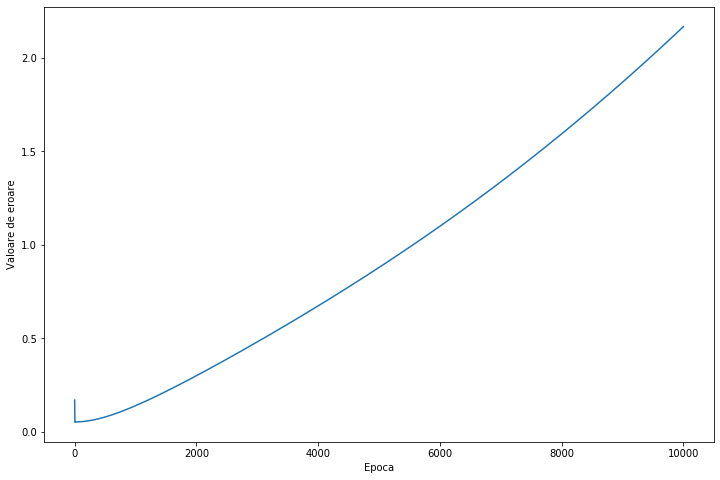

In [55]:
# desenarea curbei de cost pe setul de antrenare

plt.figure(figsize=(12, 8))
plt.xlabel('Epoca')
plt.ylabel('Valoare de eroare')
plt.plot(losses)

In [56]:
# Obtine valorile estimate de model, calculeaza eroarea intre estimare si 
# ground truth.

# estimare facuta de model
y_hat =h(X,w)
# mean squared error pe setul de antrenare
error_sgd = mean_squared_error(y,y_hat)

print('Eroarea determinata prin algoritmul stochastic gradient descent:', error_sgd)
print('Vectorul de ponderi:', w[:, 0])

[[0.70277885]
 [0.24411654]
 [0.38358986]
 ...
 [0.67023211]
 [0.64301725]
 [0.74457665]]
Eroarea determinata prin algoritmul stochastic gradient descent: 0.07136663726160662
Vectorul de ponderi: [ 0.25338567 -0.15071384 -0.21977676  1.88581111  0.02275258  0.92006224
  0.10365016  0.10365016 -1.25040228  0.25338567 -0.45629341  0.46119895
  0.25338567 -3.30872391  1.89465911 -0.01508993 -0.32346782]


### Pseudoinverse method

In [57]:
# se calculeaza w cu metoda pseudoinversei 
w_pinv = np.dot(np.linalg.pinv(X),y)


# se calculeaza estimarea data cu ponderile w_pinv
y_hat_pinv = h(X,w_pinv)

# se calculeaza eroarea patratica medie
error_pinv= mean_squared_error(y,y_hat_pinv)

print('Eroarea determinata prin metoda pseudoinversei:', error_pinv)

[[ 0.33821915]
 [ 0.08456045]
 [-0.01727077]
 ...
 [ 0.96221731]
 [ 1.06959675]
 [ 1.0485869 ]]
Eroarea determinata prin metoda pseudoinversei: 0.008010137201200604


In [58]:
print(np.linalg.norm(gradient(X, w_pinv, y)))

[[ 0.33821915]
 [ 0.08456045]
 [-0.01727077]
 ...
 [ 0.96221731]
 [ 1.06959675]
 [ 1.0485869 ]]
6.147904784172323e-15


In [59]:
# afiseaza ponderile determinate prin metoda pseudoinversei

print(w_pinv[:, 0])

[  0.29015495   0.39839967   5.56767682  40.06318117   5.89697855
   4.03988449 -20.25484653 -20.25484653 -18.34254684   0.29015495
   1.81835155  11.32697686   0.29015495 -37.23147039   1.22929938
  -0.88382777  25.32182337]


## Split validation

In [60]:
# imparte setul initial in 70% antrenare si 30% testare

data =np.random.permutation(data)
split_percentage = 0.7
split_index =int(data.shape[0]*split_percentage)

data_train =data[0:split_index+1][:]
data_test =data[split_index+1:][:]

X_train, y_train = get_input_output(data_train)
X_test, y_test = get_input_output(data_test)

In [61]:
# scaleaza datele de intrare din setul de antrenare si obtine minimele 
# si maximele pe coloane
X_train, min_X_train, max_X_train = scale_matrix(X_train)
# scaleaza datele de iesire din setul de antrenare si obtine minimul si 
# maximul pe coloana
y_train, min_y_train, max_y_train =scale_matrix(y_train)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 14, 15],
      dtype=int64),)
(array([0], dtype=int64),)


In [62]:
# scaleaza datele de intrare din setul de test, folosind minimele si maximele 
# pe coloane aflate de la X_train
# se foloseste functia scale_matrix_with_known_minmax
X_test = scale_matrix_with_known_minmax(X_test,min_X_train,max_X_train) 

# scaleaza datele de iesire din setul de test, folosind minimul si maximul 
# pe coloana aflate de la y_train
y_test = scale_matrix_with_known_minmax(y_test,min_y_train,max_y_train) 

In [63]:
# antreneaza linear regression pe setul de antrenare, obtine ponderile
# modelului

w_train, losses_train = train(X_train, y_train, max_iters=10000, alpha=0.1, lmbda=0.1)
# restul parametrilor ca la apelul de antrenare de mai sus

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[[0.19707392]
 [0.2640282 ]
 [0.36653972]
 ...
 [0.22995637]
 [0.23042117]
 [0.13767532]]
[[0.19707392]
 [0.2640282 ]
 [0.36653972]
 ...
 [0.22995637]
 [0.23042117]
 [0.13767532]]
[[0.299008  ]
 [0.39583466]
 [0.54375479]
 ...
 [0.34659534]
 [0.34727315]
 [0.2128113 ]]
[[0.299008  ]
 [0.39583466]
 [0.54375479]
 ...
 [0.34659534]
 [0.34727315]
 [0.2128113 ]]
[[0.3530159 ]
 [0.46130048]
 [0.62628845]
 ...
 [0.40627957]
 [0.40704501]
 [0.25622373]]
[[0.3530159 ]
 [0.46130048]
 [0.62628845]
 ...
 [0.40627957]
 [0.40704501]
 [0.25622373]]
[[0.38280975]
 [0.49349873]
 [0.66163591]
 ...
 [0.43730913]
 [0.43810018]
 [0.28340116]]
[[0.38280975]
 [0.49349873]
 [0.66163591]
 ...
 [0.43730913]
 [0.43810018]
 [0.28340116]]
[[0.40030235]
 [0.50903148]
 [0.67362306]
 ...
 [0.45389519]
 [0.45468163]
 [0.30213623]]
[[0.40030235]
 [0.50903148]
 [0.67362306]
 ...
 [0.45389519]
 [0.45468163]
 [0.30213623]]
[[0.41148232]
 [

[[0.50813439]
 [0.50301429]
 [0.48313648]
 ...
 [0.50616772]
 [0.50583481]
 [0.49746425]]
[[0.50814173]
 [0.50301635]
 [0.48313449]
 ...
 [0.50616752]
 [0.50583121]
 [0.49745029]]
[[0.50814173]
 [0.50301635]
 [0.48313449]
 ...
 [0.50616752]
 [0.50583121]
 [0.49745029]]
[[0.50814901]
 [0.50301841]
 [0.48313261]
 ...
 [0.5061673 ]
 [0.50582758]
 [0.49743628]]
[[0.50814901]
 [0.50301841]
 [0.48313261]
 ...
 [0.5061673 ]
 [0.50582758]
 [0.49743628]]
[[0.50815624]
 [0.50302046]
 [0.48313083]
 ...
 [0.50616704]
 [0.50582392]
 [0.49742221]]
[[0.50815624]
 [0.50302046]
 [0.48313083]
 ...
 [0.50616704]
 [0.50582392]
 [0.49742221]]
[[0.50816342]
 [0.5030225 ]
 [0.48312914]
 ...
 [0.50616675]
 [0.50582023]
 [0.49740809]]
[[0.50816342]
 [0.5030225 ]
 [0.48312914]
 ...
 [0.50616675]
 [0.50582023]
 [0.49740809]]
[[0.50817056]
 [0.50302454]
 [0.48312753]
 ...
 [0.50616643]
 [0.50581652]
 [0.49739392]]
[[0.50817056]
 [0.50302454]
 [0.48312753]
 ...
 [0.50616643]
 [0.50581652]
 [0.49739392]]
[[0.508177

[[0.50897827]
 [0.50317991]
 [0.48331077]
 ...
 [0.50589593]
 [0.5050438 ]
 [0.4951932 ]]
[[0.50898238]
 [0.50317998]
 [0.48331373]
 ...
 [0.50589299]
 [0.5050376 ]
 [0.49517892]]
[[0.50898238]
 [0.50317998]
 [0.48331373]
 ...
 [0.50589299]
 [0.5050376 ]
 [0.49517892]]
[[0.50898647]
 [0.50318004]
 [0.48331672]
 ...
 [0.50589003]
 [0.50503138]
 [0.49516465]]
[[0.50898647]
 [0.50318004]
 [0.48331672]
 ...
 [0.50589003]
 [0.50503138]
 [0.49516465]]
[[0.50899055]
 [0.50318008]
 [0.48331972]
 ...
 [0.50588706]
 [0.50502516]
 [0.49515038]]
[[0.50899055]
 [0.50318008]
 [0.48331972]
 ...
 [0.50588706]
 [0.50502516]
 [0.49515038]]
[[0.50899462]
 [0.50318012]
 [0.48332274]
 ...
 [0.50588408]
 [0.50501892]
 [0.49513611]]
[[0.50899462]
 [0.50318012]
 [0.48332274]
 ...
 [0.50588408]
 [0.50501892]
 [0.49513611]]
[[0.50899867]
 [0.50318014]
 [0.48332578]
 ...
 [0.50588109]
 [0.50501267]
 [0.49512185]]
[[0.50899867]
 [0.50318014]
 [0.48332578]
 ...
 [0.50588109]
 [0.50501267]
 [0.49512185]]
[[0.509002

[[0.50951536]
 [0.50304755]
 [0.48405598]
 ...
 [0.50522934]
 [0.50382845]
 [0.49280557]]
[[0.50951764]
 [0.50304605]
 [0.48406149]
 ...
 [0.50522467]
 [0.50382066]
 [0.49279207]]
[[0.50951764]
 [0.50304605]
 [0.48406149]
 ...
 [0.50522467]
 [0.50382066]
 [0.49279207]]
[[0.50951991]
 [0.50304454]
 [0.48406701]
 ...
 [0.50521999]
 [0.50381286]
 [0.49277857]]
[[0.50951991]
 [0.50304454]
 [0.48406701]
 ...
 [0.50521999]
 [0.50381286]
 [0.49277857]]
[[0.50952217]
 [0.50304302]
 [0.48407255]
 ...
 [0.5052153 ]
 [0.50380505]
 [0.49276507]]
[[0.50952217]
 [0.50304302]
 [0.48407255]
 ...
 [0.5052153 ]
 [0.50380505]
 [0.49276507]]
[[0.50952443]
 [0.50304149]
 [0.48407809]
 ...
 [0.50521061]
 [0.50379723]
 [0.49275158]]
[[0.50952443]
 [0.50304149]
 [0.48407809]
 ...
 [0.50521061]
 [0.50379723]
 [0.49275158]]
[[0.50952668]
 [0.50303996]
 [0.48408365]
 ...
 [0.50520591]
 [0.50378941]
 [0.49273809]]
[[0.50952668]
 [0.50303996]
 [0.48408365]
 ...
 [0.50520591]
 [0.50378941]
 [0.49273809]]
[[0.509528

[[0.50979511]
 [0.50271737]
 [0.4850854 ]
 ...
 [0.50438217]
 [0.50248183]
 [0.49065538]]
[[0.50979511]
 [0.50271737]
 [0.4850854 ]
 ...
 [0.50438217]
 [0.50248183]
 [0.49065538]]
[[0.50979634]
 [0.50271489]
 [0.48509241]
 ...
 [0.50437653]
 [0.50247318]
 [0.49064249]]
[[0.50979634]
 [0.50271489]
 [0.48509241]
 ...
 [0.50437653]
 [0.50247318]
 [0.49064249]]
[[0.50979757]
 [0.50271239]
 [0.48509943]
 ...
 [0.50437088]
 [0.50246453]
 [0.49062961]]
[[0.50979757]
 [0.50271239]
 [0.48509943]
 ...
 [0.50437088]
 [0.50246453]
 [0.49062961]]
[[0.5097988 ]
 [0.5027099 ]
 [0.48510645]
 ...
 [0.50436523]
 [0.50245587]
 [0.49061672]]
[[0.5097988 ]
 [0.5027099 ]
 [0.48510645]
 ...
 [0.50436523]
 [0.50245587]
 [0.49061672]]
[[0.50980002]
 [0.5027074 ]
 [0.48511349]
 ...
 [0.50435957]
 [0.50244721]
 [0.49060384]]
[[0.50980002]
 [0.5027074 ]
 [0.48511349]
 ...
 [0.50435957]
 [0.50244721]
 [0.49060384]]
[[0.50980123]
 [0.50270489]
 [0.48512052]
 ...
 [0.50435391]
 [0.50243855]
 [0.49059097]]
[[0.509801

 [0.4884133 ]]
[[0.50995185]
 [0.50220473]
 [0.48643584]
 ...
 [0.50331342]
 [0.50088569]
 [0.48840099]]
[[0.50995185]
 [0.50220473]
 [0.48643584]
 ...
 [0.50331342]
 [0.50088569]
 [0.48840099]]
[[0.50995244]
 [0.50220154]
 [0.48644383]
 ...
 [0.50330718]
 [0.50087657]
 [0.48838868]]
[[0.50995244]
 [0.50220154]
 [0.48644383]
 ...
 [0.50330718]
 [0.50087657]
 [0.48838868]]
[[0.50995301]
 [0.50219834]
 [0.48645183]
 ...
 [0.50330095]
 [0.50086745]
 [0.48837637]]
[[0.50995301]
 [0.50219834]
 [0.48645183]
 ...
 [0.50330095]
 [0.50086745]
 [0.48837637]]
[[0.50995359]
 [0.50219514]
 [0.48645983]
 ...
 [0.50329471]
 [0.50085832]
 [0.48836407]]
[[0.50995359]
 [0.50219514]
 [0.48645983]
 ...
 [0.50329471]
 [0.50085832]
 [0.48836407]]
[[0.50995416]
 [0.50219194]
 [0.48646783]
 ...
 [0.50328847]
 [0.50084919]
 [0.48835177]]
[[0.50995416]
 [0.50219194]
 [0.48646783]
 ...
 [0.50328847]
 [0.50084919]
 [0.48835177]]
[[0.50995473]
 [0.50218874]
 [0.48647584]
 ...
 [0.50328222]
 [0.50084006]
 [0.488339

[[0.51002247]
 [0.50159706]
 [0.48790238]
 ...
 [0.5021826 ]
 [0.49925347]
 [0.48626759]]
[[0.51002247]
 [0.50159706]
 [0.48790238]
 ...
 [0.5021826 ]
 [0.49925347]
 [0.48626759]]
[[0.51002273]
 [0.50159342]
 [0.4879109 ]
 ...
 [0.50217609]
 [0.49924418]
 [0.48625579]]
[[0.51002273]
 [0.50159342]
 [0.4879109 ]
 ...
 [0.50217609]
 [0.49924418]
 [0.48625579]]
[[0.51002298]
 [0.50158977]
 [0.48791943]
 ...
 [0.50216959]
 [0.4992349 ]
 [0.48624398]]
[[0.51002298]
 [0.50158977]
 [0.48791943]
 ...
 [0.50216959]
 [0.4992349 ]
 [0.48624398]]
[[0.51002324]
 [0.50158613]
 [0.48792796]
 ...
 [0.50216308]
 [0.49922562]
 [0.48623219]]
[[0.51002324]
 [0.50158613]
 [0.48792796]
 ...
 [0.50216308]
 [0.49922562]
 [0.48623219]]
[[0.51002349]
 [0.50158248]
 [0.48793649]
 ...
 [0.50215658]
 [0.49921633]
 [0.48622039]]
[[0.51002349]
 [0.50158248]
 [0.48793649]
 ...
 [0.50215658]
 [0.49921633]
 [0.48622039]]
[[0.51002374]
 [0.50157883]
 [0.48794502]
 ...
 [0.50215007]
 [0.49920705]
 [0.4862086 ]]
[[0.510023

 [0.48433258]]
[[0.51005323]
 [0.50096406]
 [0.48934935]
 ...
 [0.50108829]
 [0.49770321]
 [0.48433258]]
[[0.51005337]
 [0.50096014]
 [0.48935812]
 ...
 [0.50108171]
 [0.49769395]
 [0.4843212 ]]
[[0.51005337]
 [0.50096014]
 [0.48935812]
 ...
 [0.50108171]
 [0.49769395]
 [0.4843212 ]]
[[0.5100535 ]
 [0.50095622]
 [0.4893669 ]
 ...
 [0.50107513]
 [0.49768469]
 [0.48430983]]
[[0.5100535 ]
 [0.50095622]
 [0.4893669 ]
 ...
 [0.50107513]
 [0.49768469]
 [0.48430983]]
[[0.51005363]
 [0.50095229]
 [0.48937567]
 ...
 [0.50106855]
 [0.49767543]
 [0.48429846]]
[[0.51005363]
 [0.50095229]
 [0.48937567]
 ...
 [0.50106855]
 [0.49767543]
 [0.48429846]]
[[0.51005377]
 [0.50094837]
 [0.48938445]
 ...
 [0.50106198]
 [0.49766617]
 [0.4842871 ]]
[[0.51005377]
 [0.50094837]
 [0.48938445]
 ...
 [0.50106198]
 [0.49766617]
 [0.4842871 ]]
[[0.5100539 ]
 [0.50094444]
 [0.48939323]
 ...
 [0.5010554 ]
 [0.49765691]
 [0.48427573]]
[[0.5100539 ]
 [0.50094444]
 [0.48939323]
 ...
 [0.5010554 ]
 [0.49765691]
 [0.484275

 [0.4824115 ]]
[[0.51007411]
 [0.50027254]
 [0.49086793]
 ...
 [0.49995863]
 [0.49612036]
 [0.4824115 ]]
[[0.51007423]
 [0.50026843]
 [0.4908768 ]
 ...
 [0.49995209]
 [0.49611123]
 [0.48240054]]
[[0.51007423]
 [0.50026843]
 [0.4908768 ]
 ...
 [0.49995209]
 [0.49611123]
 [0.48240054]]
[[0.51007435]
 [0.50026432]
 [0.49088566]
 ...
 [0.49994554]
 [0.4961021 ]
 [0.48238957]]
[[0.51007435]
 [0.50026432]
 [0.49088566]
 ...
 [0.49994554]
 [0.4961021 ]
 [0.48238957]]
[[0.51007448]
 [0.50026021]
 [0.49089452]
 ...
 [0.499939  ]
 [0.49609297]
 [0.48237861]]
[[0.51007448]
 [0.50026021]
 [0.49089452]
 ...
 [0.499939  ]
 [0.49609297]
 [0.48237861]]
[[0.5100746 ]
 [0.5002561 ]
 [0.49090339]
 ...
 [0.49993246]
 [0.49608385]
 [0.48236765]]
[[0.5100746 ]
 [0.5002561 ]
 [0.49090339]
 ...
 [0.49993246]
 [0.49608385]
 [0.48236765]]
[[0.51007473]
 [0.50025199]
 [0.49091225]
 ...
 [0.49992592]
 [0.49607472]
 [0.48235669]]
[[0.51007473]
 [0.50025199]
 [0.49091225]
 ...
 [0.49992592]
 [0.49607472]
 [0.482356

[[0.51009947]
 [0.4995632 ]
 [0.49237449]
 ...
 [0.49885496]
 [0.4945843 ]
 [0.48057895]]
[[0.51009947]
 [0.4995632 ]
 [0.49237449]
 ...
 [0.49885496]
 [0.4945843 ]
 [0.48057895]]
[[0.51009966]
 [0.49955897]
 [0.49238334]
 ...
 [0.49884853]
 [0.49457536]
 [0.48056835]]
[[0.51009966]
 [0.49955897]
 [0.49238334]
 ...
 [0.49884853]
 [0.49457536]
 [0.48056835]]
[[0.51009984]
 [0.49955474]
 [0.49239219]
 ...
 [0.49884209]
 [0.49456643]
 [0.48055776]]
[[0.51009984]
 [0.49955474]
 [0.49239219]
 ...
 [0.49884209]
 [0.49456643]
 [0.48055776]]
[[0.51010003]
 [0.49955051]
 [0.49240103]
 ...
 [0.49883566]
 [0.4945575 ]
 [0.48054717]]
[[0.51010003]
 [0.49955051]
 [0.49240103]
 ...
 [0.49883566]
 [0.4945575 ]
 [0.48054717]]
[[0.51010021]
 [0.49954628]
 [0.49240988]
 ...
 [0.49882923]
 [0.49454857]
 [0.48053658]]
[[0.51010021]
 [0.49954628]
 [0.49240988]
 ...
 [0.49882923]
 [0.49454857]
 [0.48053658]]
[[0.5101004 ]
 [0.49954205]
 [0.49241872]
 ...
 [0.4988228 ]
 [0.49453965]
 [0.480526  ]]
[[0.510100

 [0.47876675]]
[[0.51014033]
 [0.49881564]
 [0.49391608]
 ...
 [0.49774216]
 [0.49304174]
 [0.47875652]]
[[0.51014033]
 [0.49881564]
 [0.49391608]
 ...
 [0.49774216]
 [0.49304174]
 [0.47875652]]
[[0.51014062]
 [0.49881133]
 [0.49392485]
 ...
 [0.49773589]
 [0.49303305]
 [0.47874628]]
[[0.51014062]
 [0.49881133]
 [0.49392485]
 ...
 [0.49773589]
 [0.49303305]
 [0.47874628]]
[[0.51014091]
 [0.49880702]
 [0.49393361]
 ...
 [0.49772961]
 [0.49302436]
 [0.47873605]]
[[0.51014091]
 [0.49880702]
 [0.49393361]
 ...
 [0.49772961]
 [0.49302436]
 [0.47873605]]
[[0.5101412 ]
 [0.49880271]
 [0.49394237]
 ...
 [0.49772333]
 [0.49301567]
 [0.47872582]]
[[0.5101412 ]
 [0.49880271]
 [0.49394237]
 ...
 [0.49772333]
 [0.49301567]
 [0.47872582]]
[[0.51014149]
 [0.4987984 ]
 [0.49395113]
 ...
 [0.49771706]
 [0.49300699]
 [0.47871559]]
[[0.51014149]
 [0.4987984 ]
 [0.49395113]
 ...
 [0.49771706]
 [0.49300699]
 [0.47871559]]
[[0.51014178]
 [0.49879409]
 [0.49395989]
 ...
 [0.49771078]
 [0.4929983 ]
 [0.478705

 [0.47701483]]
[[0.51020104]
 [0.49806568]
 [0.49542135]
 ...
 [0.49667122]
 [0.49156056]
 [0.47701483]]
[[0.51020146]
 [0.49806132]
 [0.49542999]
 ...
 [0.49666512]
 [0.49155213]
 [0.47700493]]
[[0.51020146]
 [0.49806132]
 [0.49542999]
 ...
 [0.49666512]
 [0.49155213]
 [0.47700493]]
[[0.51020187]
 [0.49805696]
 [0.49543862]
 ...
 [0.49665902]
 [0.4915437 ]
 [0.47699503]]
[[0.51020187]
 [0.49805696]
 [0.49543862]
 ...
 [0.49665902]
 [0.4915437 ]
 [0.47699503]]
[[0.51020229]
 [0.4980526 ]
 [0.49544725]
 ...
 [0.49665293]
 [0.49153527]
 [0.47698513]]
[[0.51020229]
 [0.4980526 ]
 [0.49544725]
 ...
 [0.49665293]
 [0.49153527]
 [0.47698513]]
[[0.51020271]
 [0.49804824]
 [0.49545589]
 ...
 [0.49664683]
 [0.49152685]
 [0.47697524]]
[[0.51020271]
 [0.49804824]
 [0.49545589]
 ...
 [0.49664683]
 [0.49152685]
 [0.47697524]]
[[0.51020313]
 [0.49804388]
 [0.49546452]
 ...
 [0.49664074]
 [0.49151843]
 [0.47696534]]
[[0.51020313]
 [0.49804388]
 [0.49546452]
 ...
 [0.49664074]
 [0.49151843]
 [0.476965

[[0.51028375]
 [0.49731787]
 [0.49688526]
 ...
 [0.4956443 ]
 [0.49014179]
 [0.47534851]]
[[0.51028375]
 [0.49731787]
 [0.49688526]
 ...
 [0.4956443 ]
 [0.49014179]
 [0.47534851]]
[[0.5102843 ]
 [0.49731349]
 [0.49689374]
 ...
 [0.49563839]
 [0.49013363]
 [0.47533892]]
[[0.5102843 ]
 [0.49731349]
 [0.49689374]
 ...
 [0.49563839]
 [0.49013363]
 [0.47533892]]
[[0.51028486]
 [0.4973091 ]
 [0.49690223]
 ...
 [0.49563249]
 [0.49012547]
 [0.47532933]]
[[0.51028486]
 [0.4973091 ]
 [0.49690223]
 ...
 [0.49563249]
 [0.49012547]
 [0.47532933]]
[[0.51028541]
 [0.49730471]
 [0.49691071]
 ...
 [0.49562658]
 [0.49011731]
 [0.47531974]]
[[0.51028541]
 [0.49730471]
 [0.49691071]
 ...
 [0.49562658]
 [0.49011731]
 [0.47531974]]
[[0.51028597]
 [0.49730033]
 [0.49691919]
 ...
 [0.49562067]
 [0.49010916]
 [0.47531016]]
[[0.51028597]
 [0.49730033]
 [0.49691919]
 ...
 [0.49562067]
 [0.49010916]
 [0.47531016]]
[[0.51028652]
 [0.49729594]
 [0.49692767]
 ...
 [0.49561477]
 [0.490101  ]
 [0.47530058]]
[[0.510286

[[0.51038608]
 [0.49659285]
 [0.49827208]
 ...
 [0.49468468]
 [0.48881639]
 [0.47378999]]
[[0.51038608]
 [0.49659285]
 [0.49827208]
 ...
 [0.49468468]
 [0.48881639]
 [0.47378999]]
[[0.51038677]
 [0.49658845]
 [0.4982804 ]
 ...
 [0.49467895]
 [0.48880849]
 [0.47378069]]
[[0.51038677]
 [0.49658845]
 [0.4982804 ]
 ...
 [0.49467895]
 [0.48880849]
 [0.47378069]]
[[0.51038745]
 [0.49658405]
 [0.49828872]
 ...
 [0.49467323]
 [0.48880059]
 [0.47377139]]
[[0.51038745]
 [0.49658405]
 [0.49828872]
 ...
 [0.49467323]
 [0.48880059]
 [0.47377139]]
[[0.51038814]
 [0.49657965]
 [0.49829705]
 ...
 [0.49466752]
 [0.48879269]
 [0.47376209]]
[[0.51038814]
 [0.49657965]
 [0.49829705]
 ...
 [0.49466752]
 [0.48879269]
 [0.47376209]]
[[0.51038884]
 [0.49657524]
 [0.49830537]
 ...
 [0.4946618 ]
 [0.4887848 ]
 [0.47375279]]
[[0.51038884]
 [0.49657524]
 [0.49830537]
 ...
 [0.4946618 ]
 [0.4887848 ]
 [0.47375279]]
[[0.51038953]
 [0.49657084]
 [0.49831369]
 ...
 [0.49465608]
 [0.4887769 ]
 [0.47374349]]
[[0.510389

 [0.47218734]]
[[0.51051977]
 [0.49581778]
 [0.49972157]
 ...
 [0.49369543]
 [0.48744979]
 [0.47217833]]
[[0.51051977]
 [0.49581778]
 [0.49972157]
 ...
 [0.49369543]
 [0.48744979]
 [0.47217833]]
[[0.5105206 ]
 [0.49581337]
 [0.49972971]
 ...
 [0.49368991]
 [0.48744216]
 [0.47216931]]
[[0.5105206 ]
 [0.49581337]
 [0.49972971]
 ...
 [0.49368991]
 [0.48744216]
 [0.47216931]]
[[0.51052143]
 [0.49580897]
 [0.49973786]
 ...
 [0.49368439]
 [0.48743453]
 [0.4721603 ]]
[[0.51052143]
 [0.49580897]
 [0.49973786]
 ...
 [0.49368439]
 [0.48743453]
 [0.4721603 ]]
[[0.51052226]
 [0.49580456]
 [0.499746  ]
 ...
 [0.49367887]
 [0.48742691]
 [0.47215129]]
[[0.51052226]
 [0.49580456]
 [0.499746  ]
 ...
 [0.49367887]
 [0.48742691]
 [0.47215129]]
[[0.5105231 ]
 [0.49580016]
 [0.49975414]
 ...
 [0.49367335]
 [0.48741929]
 [0.47214229]]
[[0.5105231 ]
 [0.49580016]
 [0.49975414]
 ...
 [0.49367335]
 [0.48741929]
 [0.47214229]]
[[0.51052393]
 [0.49579575]
 [0.49976228]
 ...
 [0.49366784]
 [0.48741167]
 [0.472133

[[0.51067442]
 [0.49506009]
 [0.50110743]
 ...
 [0.49276279]
 [0.48616061]
 [0.47065147]]
[[0.51067539]
 [0.49505569]
 [0.5011154 ]
 ...
 [0.49275746]
 [0.48615325]
 [0.47064273]]
[[0.51067539]
 [0.49505569]
 [0.5011154 ]
 ...
 [0.49275746]
 [0.48615325]
 [0.47064273]]
[[0.51067636]
 [0.49505129]
 [0.50112336]
 ...
 [0.49275214]
 [0.48614588]
 [0.47063399]]
[[0.51067636]
 [0.49505129]
 [0.50112336]
 ...
 [0.49275214]
 [0.48614588]
 [0.47063399]]
[[0.51067733]
 [0.49504688]
 [0.50113133]
 ...
 [0.49274681]
 [0.48613852]
 [0.47062525]]
[[0.51067733]
 [0.49504688]
 [0.50113133]
 ...
 [0.49274681]
 [0.48613852]
 [0.47062525]]
[[0.5106783 ]
 [0.49504248]
 [0.50113929]
 ...
 [0.49274149]
 [0.48613117]
 [0.47061651]]
[[0.5106783 ]
 [0.49504248]
 [0.50113929]
 ...
 [0.49274149]
 [0.48613117]
 [0.47061651]]
[[0.51067927]
 [0.49503808]
 [0.50114726]
 ...
 [0.49273617]
 [0.48612381]
 [0.47060778]]
[[0.51067927]
 [0.49503808]
 [0.50114726]
 ...
 [0.49273617]
 [0.48612381]
 [0.47060778]]
[[0.510680

 [0.46922094]]
[[0.51084648]
 [0.49432525]
 [0.50242363]
 ...
 [0.49188902]
 [0.48495179]
 [0.46921245]]
[[0.51084648]
 [0.49432525]
 [0.50242363]
 ...
 [0.49188902]
 [0.48495179]
 [0.46921245]]
[[0.51084757]
 [0.49432085]
 [0.50243142]
 ...
 [0.49188389]
 [0.48494468]
 [0.46920395]]
[[0.51084757]
 [0.49432085]
 [0.50243142]
 ...
 [0.49188389]
 [0.48494468]
 [0.46920395]]
[[0.51084866]
 [0.49431645]
 [0.50243922]
 ...
 [0.49187875]
 [0.48493757]
 [0.46919546]]
[[0.51084866]
 [0.49431645]
 [0.50243922]
 ...
 [0.49187875]
 [0.48493757]
 [0.46919546]]
[[0.51084976]
 [0.49431206]
 [0.50244701]
 ...
 [0.49187361]
 [0.48493046]
 [0.46918697]]
[[0.51084976]
 [0.49431206]
 [0.50244701]
 ...
 [0.49187361]
 [0.48493046]
 [0.46918697]]
[[0.51085085]
 [0.49430766]
 [0.5024548 ]
 ...
 [0.49186847]
 [0.48492335]
 [0.46917849]]
[[0.51085085]
 [0.49430766]
 [0.5024548 ]
 ...
 [0.49186847]
 [0.48492335]
 [0.46917849]]
[[0.51085195]
 [0.49430326]
 [0.50246259]
 ...
 [0.49186334]
 [0.48491624]
 [0.46917 

[[0.51105127]
 [0.49354811]
 [0.50378707]
 ...
 [0.49099631]
 [0.48371544]
 [0.46773183]]
[[0.51105127]
 [0.49354811]
 [0.50378707]
 ...
 [0.49099631]
 [0.48371544]
 [0.46773183]]
[[0.51105249]
 [0.49354373]
 [0.50379468]
 ...
 [0.49099136]
 [0.48370859]
 [0.46772359]]
[[0.51105249]
 [0.49354373]
 [0.50379468]
 ...
 [0.49099136]
 [0.48370859]
 [0.46772359]]
[[0.51105371]
 [0.49353934]
 [0.50380229]
 ...
 [0.49098641]
 [0.48370173]
 [0.46771535]]
[[0.51105371]
 [0.49353934]
 [0.50380229]
 ...
 [0.49098641]
 [0.48370173]
 [0.46771535]]
[[0.51105493]
 [0.49353496]
 [0.5038099 ]
 ...
 [0.49098147]
 [0.48369488]
 [0.46770711]]
[[0.51105493]
 [0.49353496]
 [0.5038099 ]
 ...
 [0.49098147]
 [0.48369488]
 [0.46770711]]
[[0.51105615]
 [0.49353057]
 [0.50381751]
 ...
 [0.49097652]
 [0.48368802]
 [0.46769888]]
[[0.51105615]
 [0.49353057]
 [0.50381751]
 ...
 [0.49097652]
 [0.48368802]
 [0.46769888]]
[[0.51105737]
 [0.49352619]
 [0.50382511]
 ...
 [0.49097158]
 [0.48368117]
 [0.46769065]]
[[0.511057

 [0.46639107]]
[[0.51126185]
 [0.49282586]
 [0.50502906]
 ...
 [0.49019417]
 [0.4826032 ]
 [0.46639107]]
[[0.51126318]
 [0.49282149]
 [0.5050365 ]
 ...
 [0.49018939]
 [0.48259657]
 [0.46638305]]
[[0.51126318]
 [0.49282149]
 [0.5050365 ]
 ...
 [0.49018939]
 [0.48259657]
 [0.46638305]]
[[0.51126451]
 [0.49281712]
 [0.50504394]
 ...
 [0.49018462]
 [0.48258995]
 [0.46637504]]
[[0.51126451]
 [0.49281712]
 [0.50504394]
 ...
 [0.49018462]
 [0.48258995]
 [0.46637504]]
[[0.51126585]
 [0.49281275]
 [0.50505138]
 ...
 [0.49017985]
 [0.48258333]
 [0.46636703]]
[[0.51126585]
 [0.49281275]
 [0.50505138]
 ...
 [0.49017985]
 [0.48258333]
 [0.46636703]]
[[0.51126718]
 [0.49280838]
 [0.50505882]
 ...
 [0.49017507]
 [0.48257671]
 [0.46635902]]
[[0.51126718]
 [0.49280838]
 [0.50505882]
 ...
 [0.49017507]
 [0.48257671]
 [0.46635902]]
[[0.51126852]
 [0.49280401]
 [0.50506626]
 ...
 [0.4901703 ]
 [0.48257009]
 [0.46635101]]
[[0.51126852]
 [0.49280401]
 [0.50506626]
 ...
 [0.4901703 ]
 [0.48257009]
 [0.466351

[[0.51149318]
 [0.49209749]
 [0.50625798]
 ...
 [0.48941092]
 [0.48151575]
 [0.46507114]]
[[0.51149462]
 [0.49209313]
 [0.50626525]
 ...
 [0.48940632]
 [0.48150935]
 [0.46506335]]
[[0.51149462]
 [0.49209313]
 [0.50626525]
 ...
 [0.48940632]
 [0.48150935]
 [0.46506335]]
[[0.51149605]
 [0.49208878]
 [0.50627252]
 ...
 [0.48940171]
 [0.48150295]
 [0.46505555]]
[[0.51149605]
 [0.49208878]
 [0.50627252]
 ...
 [0.48940171]
 [0.48150295]
 [0.46505555]]
[[0.51149749]
 [0.49208443]
 [0.5062798 ]
 ...
 [0.48939711]
 [0.48149655]
 [0.46504776]]
[[0.51149749]
 [0.49208443]
 [0.5062798 ]
 ...
 [0.48939711]
 [0.48149655]
 [0.46504776]]
[[0.51149893]
 [0.49208008]
 [0.50628707]
 ...
 [0.48939251]
 [0.48149016]
 [0.46503997]]
[[0.51149893]
 [0.49208008]
 [0.50628707]
 ...
 [0.48939251]
 [0.48149016]
 [0.46503997]]
[[0.51150037]
 [0.49207572]
 [0.50629434]
 ...
 [0.4893879 ]
 [0.48148377]
 [0.46503218]]
[[0.51150037]
 [0.49207572]
 [0.50629434]
 ...
 [0.4893879 ]
 [0.48148377]
 [0.46503218]]
[[0.511501

[[0.51174937]
 [0.4913505 ]
 [0.5074946 ]
 ...
 [0.48863333]
 [0.48043462]
 [0.46374904]]
[[0.51175091]
 [0.49134616]
 [0.5075017 ]
 ...
 [0.48862889]
 [0.48042845]
 [0.46374146]]
[[0.51175091]
 [0.49134616]
 [0.5075017 ]
 ...
 [0.48862889]
 [0.48042845]
 [0.46374146]]
[[0.51175245]
 [0.49134183]
 [0.50750881]
 ...
 [0.48862446]
 [0.48042227]
 [0.46373388]]
[[0.51175245]
 [0.49134183]
 [0.50750881]
 ...
 [0.48862446]
 [0.48042227]
 [0.46373388]]
[[0.51175399]
 [0.4913375 ]
 [0.50751591]
 ...
 [0.48862002]
 [0.4804161 ]
 [0.46372631]]
[[0.51175399]
 [0.4913375 ]
 [0.50751591]
 ...
 [0.48862002]
 [0.4804161 ]
 [0.46372631]]
[[0.51175553]
 [0.49133317]
 [0.50752301]
 ...
 [0.48861559]
 [0.48040994]
 [0.46371873]]
[[0.51175553]
 [0.49133317]
 [0.50752301]
 ...
 [0.48861559]
 [0.48040994]
 [0.46371873]]
[[0.51175707]
 [0.49132884]
 [0.50753011]
 ...
 [0.48861116]
 [0.48040377]
 [0.46371116]]
[[0.51175707]
 [0.49132884]
 [0.50753011]
 ...
 [0.48861116]
 [0.48040377]
 [0.46371116]]
[[0.511758

 [0.46244846]]
[[0.51202582]
 [0.49059848]
 [0.50871613]
 ...
 [0.48787571]
 [0.47937964]
 [0.46244846]]
[[0.51202745]
 [0.49059417]
 [0.50872307]
 ...
 [0.48787144]
 [0.47937369]
 [0.46244109]]
[[0.51202745]
 [0.49059417]
 [0.50872307]
 ...
 [0.48787144]
 [0.47937369]
 [0.46244109]]
[[0.51202909]
 [0.49058986]
 [0.50873   ]
 ...
 [0.48786717]
 [0.47936774]
 [0.46243372]]
[[0.51202909]
 [0.49058986]
 [0.50873   ]
 ...
 [0.48786717]
 [0.47936774]
 [0.46243372]]
[[0.51203073]
 [0.49058555]
 [0.50873694]
 ...
 [0.4878629 ]
 [0.47936178]
 [0.46242635]]
[[0.51203073]
 [0.49058555]
 [0.50873694]
 ...
 [0.4878629 ]
 [0.47936178]
 [0.46242635]]
[[0.51203237]
 [0.49058124]
 [0.50874387]
 ...
 [0.48785863]
 [0.47935584]
 [0.46241899]]
[[0.51203237]
 [0.49058124]
 [0.50874387]
 ...
 [0.48785863]
 [0.47935584]
 [0.46241899]]
[[0.512034  ]
 [0.49057693]
 [0.5087508 ]
 ...
 [0.48785436]
 [0.47934989]
 [0.46241162]]
[[0.512034  ]
 [0.49057693]
 [0.5087508 ]
 ...
 [0.48785436]
 [0.47934989]
 [0.462411

[[0.51233051]
 [0.48982047]
 [0.50995602]
 ...
 [0.48711745]
 [0.47832201]
 [0.46113322]]
[[0.51233224]
 [0.48981618]
 [0.50996278]
 ...
 [0.48711334]
 [0.47831628]
 [0.46112606]]
[[0.51233224]
 [0.48981618]
 [0.50996278]
 ...
 [0.48711334]
 [0.47831628]
 [0.46112606]]
[[0.51233397]
 [0.4898119 ]
 [0.50996954]
 ...
 [0.48710923]
 [0.47831054]
 [0.4611189 ]]
[[0.51233397]
 [0.4898119 ]
 [0.50996954]
 ...
 [0.48710923]
 [0.47831054]
 [0.4611189 ]]
[[0.5123357 ]
 [0.48980761]
 [0.50997631]
 ...
 [0.48710513]
 [0.47830481]
 [0.46111174]]
[[0.5123357 ]
 [0.48980761]
 [0.50997631]
 ...
 [0.48710513]
 [0.47830481]
 [0.46111174]]
[[0.51233743]
 [0.48980333]
 [0.50998307]
 ...
 [0.48710103]
 [0.47829908]
 [0.46110458]]
[[0.51233743]
 [0.48980333]
 [0.50998307]
 ...
 [0.48710103]
 [0.47829908]
 [0.46110458]]
[[0.51233916]
 [0.48979904]
 [0.50998983]
 ...
 [0.48709692]
 [0.47829335]
 [0.46109742]]
[[0.51233916]
 [0.48979904]
 [0.50998983]
 ...
 [0.48709692]
 [0.47829335]
 [0.46109742]]
[[0.512340

[[0.51263323]
 [0.4890897 ]
 [0.51109918]
 ...
 [0.48642799]
 [0.47735869]
 [0.45992441]]
[[0.51263504]
 [0.48908544]
 [0.51110578]
 ...
 [0.48642404]
 [0.47735315]
 [0.45991743]]
[[0.51263504]
 [0.48908544]
 [0.51110578]
 ...
 [0.48642404]
 [0.47735315]
 [0.45991743]]
[[0.51263686]
 [0.48908118]
 [0.51111239]
 ...
 [0.48642008]
 [0.47734762]
 [0.45991046]]
[[0.51263686]
 [0.48908118]
 [0.51111239]
 ...
 [0.48642008]
 [0.47734762]
 [0.45991046]]
[[0.51263867]
 [0.48907692]
 [0.51111899]
 ...
 [0.48641612]
 [0.47734209]
 [0.45990349]]
[[0.51263867]
 [0.48907692]
 [0.51111899]
 ...
 [0.48641612]
 [0.47734209]
 [0.45990349]]
[[0.51264048]
 [0.48907266]
 [0.51112559]
 ...
 [0.48641217]
 [0.47733656]
 [0.45989651]]
[[0.51264048]
 [0.48907266]
 [0.51112559]
 ...
 [0.48641217]
 [0.47733656]
 [0.45989651]]
[[0.51264229]
 [0.4890684 ]
 [0.5111322 ]
 ...
 [0.48640822]
 [0.47733103]
 [0.45988954]]
[[0.51264229]
 [0.4890684 ]
 [0.5111322 ]
 ...
 [0.48640822]
 [0.47733103]
 [0.45988954]]
[[0.512644

[[0.51295307]
 [0.48835485]
 [0.51222843]
 ...
 [0.48575609]
 [0.47641824]
 [0.45873342]]
[[0.51295496]
 [0.48835062]
 [0.51223488]
 ...
 [0.48575228]
 [0.4764129 ]
 [0.45872662]]
[[0.51295496]
 [0.48835062]
 [0.51223488]
 ...
 [0.48575228]
 [0.4764129 ]
 [0.45872662]]
[[0.51295684]
 [0.48834638]
 [0.51224132]
 ...
 [0.48574847]
 [0.47640756]
 [0.45871983]]
[[0.51295684]
 [0.48834638]
 [0.51224132]
 ...
 [0.48574847]
 [0.47640756]
 [0.45871983]]
[[0.51295873]
 [0.48834215]
 [0.51224777]
 ...
 [0.48574466]
 [0.47640223]
 [0.45871304]]
[[0.51295873]
 [0.48834215]
 [0.51224777]
 ...
 [0.48574466]
 [0.47640223]
 [0.45871304]]
[[0.51296062]
 [0.48833792]
 [0.51225422]
 ...
 [0.48574086]
 [0.47639689]
 [0.45870625]]
[[0.51296062]
 [0.48833792]
 [0.51225422]
 ...
 [0.48574086]
 [0.47639689]
 [0.45870625]]
[[0.51296251]
 [0.48833368]
 [0.51226066]
 ...
 [0.48573705]
 [0.47639156]
 [0.45869946]]
[[0.51296251]
 [0.48833368]
 [0.51226066]
 ...
 [0.48573705]
 [0.47639156]
 [0.45869946]]
[[0.512964

[[0.51326011]
 [0.48767939]
 [0.51324893]
 ...
 [0.4851568 ]
 [0.47557792]
 [0.45765937]]
[[0.51326206]
 [0.48767519]
 [0.51325524]
 ...
 [0.48515311]
 [0.47557275]
 [0.45765274]]
[[0.51326206]
 [0.48767519]
 [0.51325524]
 ...
 [0.48515311]
 [0.47557275]
 [0.45765274]]
[[0.51326401]
 [0.48767098]
 [0.51326154]
 ...
 [0.48514944]
 [0.47556759]
 [0.45764611]]
[[0.51326401]
 [0.48767098]
 [0.51326154]
 ...
 [0.48514944]
 [0.47556759]
 [0.45764611]]
[[0.51326596]
 [0.48766677]
 [0.51326785]
 ...
 [0.48514576]
 [0.47556242]
 [0.45763948]]
[[0.51326596]
 [0.48766677]
 [0.51326785]
 ...
 [0.48514576]
 [0.47556242]
 [0.45763948]]
[[0.51326791]
 [0.48766256]
 [0.51327415]
 ...
 [0.48514208]
 [0.47555726]
 [0.45763285]]
[[0.51326791]
 [0.48766256]
 [0.51327415]
 ...
 [0.48514208]
 [0.47555726]
 [0.45763285]]
[[0.51326987]
 [0.48765835]
 [0.51328046]
 ...
 [0.4851384 ]
 [0.4755521 ]
 [0.45762622]]
[[0.51326987]
 [0.48765835]
 [0.51328046]
 ...
 [0.4851384 ]
 [0.4755521 ]
 [0.45762622]]
[[0.513271

[[0.51354098]
 [0.48708341]
 [0.51413579]
 ...
 [0.48464211]
 [0.47485503]
 [0.45672743]]
[[0.51354299]
 [0.48707923]
 [0.51414198]
 ...
 [0.48463854]
 [0.47485001]
 [0.45672093]]
[[0.51354299]
 [0.48707923]
 [0.51414198]
 ...
 [0.48463854]
 [0.47485001]
 [0.45672093]]
[[0.51354499]
 [0.48707504]
 [0.51414816]
 ...
 [0.48463497]
 [0.474845  ]
 [0.45671444]]
[[0.51354499]
 [0.48707504]
 [0.51414816]
 ...
 [0.48463497]
 [0.474845  ]
 [0.45671444]]
[[0.513547  ]
 [0.48707086]
 [0.51415434]
 ...
 [0.48463141]
 [0.47483998]
 [0.45670795]]
[[0.513547  ]
 [0.48707086]
 [0.51415434]
 ...
 [0.48463141]
 [0.47483998]
 [0.45670795]]
[[0.513549  ]
 [0.48706667]
 [0.51416052]
 ...
 [0.48462784]
 [0.47483497]
 [0.45670146]]
[[0.513549  ]
 [0.48706667]
 [0.51416052]
 ...
 [0.48462784]
 [0.47483497]
 [0.45670146]]
[[0.51355101]
 [0.48706249]
 [0.5141667 ]
 ...
 [0.48462428]
 [0.47482996]
 [0.45669497]]
[[0.51355101]
 [0.48706249]
 [0.5141667 ]
 ...
 [0.48462428]
 [0.47482996]
 [0.45669497]]
[[0.513553

 [0.45574486]]
[[0.51385386]
 [0.48644088]
 [0.51507799]
 ...
 [0.48410161]
 [0.4740946 ]
 [0.45573851]]
[[0.51385386]
 [0.48644088]
 [0.51507799]
 ...
 [0.48410161]
 [0.4740946 ]
 [0.45573851]]
[[0.51385591]
 [0.48643673]
 [0.51508404]
 ...
 [0.48409816]
 [0.47408974]
 [0.45573216]]
[[0.51385591]
 [0.48643673]
 [0.51508404]
 ...
 [0.48409816]
 [0.47408974]
 [0.45573216]]
[[0.51385797]
 [0.48643257]
 [0.51509009]
 ...
 [0.48409471]
 [0.47408488]
 [0.45572581]]
[[0.51385797]
 [0.48643257]
 [0.51509009]
 ...
 [0.48409471]
 [0.47408488]
 [0.45572581]]
[[0.51386003]
 [0.48642841]
 [0.51509614]
 ...
 [0.48409126]
 [0.47408002]
 [0.45571946]]
[[0.51386003]
 [0.48642841]
 [0.51509614]
 ...
 [0.48409126]
 [0.47408002]
 [0.45571946]]
[[0.51386209]
 [0.48642425]
 [0.51510219]
 ...
 [0.48408781]
 [0.47407516]
 [0.45571312]]
[[0.51386209]
 [0.48642425]
 [0.51510219]
 ...
 [0.48408781]
 [0.47407516]
 [0.45571312]]
[[0.51386415]
 [0.48642009]
 [0.51510824]
 ...
 [0.48408436]
 [0.47407031]
 [0.455706

[[0.51419368]
 [0.48576525]
 [0.51605346]
 ...
 [0.48354889]
 [0.47331553]
 [0.45471561]]
[[0.51419368]
 [0.48576525]
 [0.51605346]
 ...
 [0.48354889]
 [0.47331553]
 [0.45471561]]
[[0.51419579]
 [0.48576112]
 [0.51605938]
 ...
 [0.48354556]
 [0.47331083]
 [0.45470941]]
[[0.51419579]
 [0.48576112]
 [0.51605938]
 ...
 [0.48354556]
 [0.47331083]
 [0.45470941]]
[[0.5141979 ]
 [0.48575699]
 [0.51606529]
 ...
 [0.48354223]
 [0.47330613]
 [0.45470321]]
[[0.5141979 ]
 [0.48575699]
 [0.51606529]
 ...
 [0.48354223]
 [0.47330613]
 [0.45470321]]
[[0.51420002]
 [0.48575286]
 [0.51607121]
 ...
 [0.4835389 ]
 [0.47330143]
 [0.45469701]]
[[0.51420002]
 [0.48575286]
 [0.51607121]
 ...
 [0.4835389 ]
 [0.47330143]
 [0.45469701]]
[[0.51420213]
 [0.48574873]
 [0.51607712]
 ...
 [0.48353557]
 [0.47329674]
 [0.45469081]]
[[0.51420213]
 [0.48574873]
 [0.51607712]
 ...
 [0.48353557]
 [0.47329674]
 [0.45469081]]
[[0.51420424]
 [0.4857446 ]
 [0.51608304]
 ...
 [0.48353225]
 [0.47329204]
 [0.45468461]]
[[0.514204

 [0.45374054]]
[[0.51453523]
 [0.4851066 ]
 [0.51698965]
 ...
 [0.48302507]
 [0.47257573]
 [0.45373447]]
[[0.51453523]
 [0.4851066 ]
 [0.51698965]
 ...
 [0.48302507]
 [0.47257573]
 [0.45373447]]
[[0.51453739]
 [0.4851025 ]
 [0.51699544]
 ...
 [0.48302185]
 [0.47257119]
 [0.45372841]]
[[0.51453739]
 [0.4851025 ]
 [0.51699544]
 ...
 [0.48302185]
 [0.47257119]
 [0.45372841]]
[[0.51453955]
 [0.4850984 ]
 [0.51700122]
 ...
 [0.48301864]
 [0.47256664]
 [0.45372235]]
[[0.51453955]
 [0.4850984 ]
 [0.51700122]
 ...
 [0.48301864]
 [0.47256664]
 [0.45372235]]
[[0.5145417 ]
 [0.4850943 ]
 [0.517007  ]
 ...
 [0.48301542]
 [0.47256209]
 [0.45371629]]
[[0.5145417 ]
 [0.4850943 ]
 [0.517007  ]
 ...
 [0.48301542]
 [0.47256209]
 [0.45371629]]
[[0.51454386]
 [0.48509019]
 [0.51701279]
 ...
 [0.48301221]
 [0.47255755]
 [0.45371023]]
[[0.51454386]
 [0.48509019]
 [0.51701279]
 ...
 [0.48301221]
 [0.47255755]
 [0.45371023]]
[[0.51454602]
 [0.48508609]
 [0.51701857]
 ...
 [0.48300899]
 [0.472553  ]
 [0.453704

 [0.45274559]]
[[0.51489723]
 [0.48442812]
 [0.51793909]
 ...
 [0.48250052]
 [0.47183339]
 [0.45273967]]
[[0.51489723]
 [0.48442812]
 [0.51793909]
 ...
 [0.48250052]
 [0.47183339]
 [0.45273967]]
[[0.51489943]
 [0.48442405]
 [0.51794474]
 ...
 [0.48249742]
 [0.47182899]
 [0.45273374]]
[[0.51489943]
 [0.48442405]
 [0.51794474]
 ...
 [0.48249742]
 [0.47182899]
 [0.45273374]]
[[0.51490164]
 [0.48441998]
 [0.51795039]
 ...
 [0.48249432]
 [0.4718246 ]
 [0.45272782]]
[[0.51490164]
 [0.48441998]
 [0.51795039]
 ...
 [0.48249432]
 [0.4718246 ]
 [0.45272782]]
[[0.51490384]
 [0.48441591]
 [0.51795605]
 ...
 [0.48249122]
 [0.4718202 ]
 [0.4527219 ]]
[[0.51490384]
 [0.48441591]
 [0.51795605]
 ...
 [0.48249122]
 [0.4718202 ]
 [0.4527219 ]]
[[0.51490604]
 [0.48441183]
 [0.5179617 ]
 ...
 [0.48248812]
 [0.47181581]
 [0.45271598]]
[[0.51490604]
 [0.48441183]
 [0.5179617 ]
 ...
 [0.48248812]
 [0.47181581]
 [0.45271598]]
[[0.51490825]
 [0.48440776]
 [0.51796735]
 ...
 [0.48248502]
 [0.47181142]
 [0.452710

[[0.51522822]
 [0.48382342]
 [0.51877274]
 ...
 [0.48204555]
 [0.47118818]
 [0.45186607]]
[[0.51522822]
 [0.48382342]
 [0.51877274]
 ...
 [0.48204555]
 [0.47118818]
 [0.45186607]]
[[0.51523046]
 [0.48381938]
 [0.51877828]
 ...
 [0.48204254]
 [0.47118391]
 [0.45186027]]
[[0.51523046]
 [0.48381938]
 [0.51877828]
 ...
 [0.48204254]
 [0.47118391]
 [0.45186027]]
[[0.5152327 ]
 [0.48381533]
 [0.51878381]
 ...
 [0.48203954]
 [0.47117965]
 [0.45185447]]
[[0.5152327 ]
 [0.48381533]
 [0.51878381]
 ...
 [0.48203954]
 [0.47117965]
 [0.45185447]]
[[0.51523494]
 [0.48381129]
 [0.51878935]
 ...
 [0.48203654]
 [0.47117539]
 [0.45184866]]
[[0.51523494]
 [0.48381129]
 [0.51878935]
 ...
 [0.48203654]
 [0.47117539]
 [0.45184866]]
[[0.51523718]
 [0.48380725]
 [0.51879488]
 ...
 [0.48203354]
 [0.47117112]
 [0.45184286]]
[[0.51523718]
 [0.48380725]
 [0.51879488]
 ...
 [0.48203354]
 [0.47117112]
 [0.45184286]]
[[0.51523942]
 [0.4838032 ]
 [0.51880041]
 ...
 [0.48203053]
 [0.47116686]
 [0.45183706]]
[[0.515239

 [0.45089654]]
[[0.51560996]
 [0.48314255]
 [0.51969749]
 ...
 [0.48154702]
 [0.4704797 ]
 [0.45089654]]
[[0.51561224]
 [0.48313854]
 [0.5197029 ]
 ...
 [0.48154413]
 [0.47047558]
 [0.45089087]]
[[0.51561224]
 [0.48313854]
 [0.5197029 ]
 ...
 [0.48154413]
 [0.47047558]
 [0.45089087]]
[[0.51561452]
 [0.48313453]
 [0.5197083 ]
 ...
 [0.48154123]
 [0.47047146]
 [0.4508852 ]]
[[0.51561452]
 [0.48313453]
 [0.5197083 ]
 ...
 [0.48154123]
 [0.47047146]
 [0.4508852 ]]
[[0.5156168 ]
 [0.48313052]
 [0.51971371]
 ...
 [0.48153834]
 [0.47046734]
 [0.45087953]]
[[0.5156168 ]
 [0.48313052]
 [0.51971371]
 ...
 [0.48153834]
 [0.47046734]
 [0.45087953]]
[[0.51561907]
 [0.4831265 ]
 [0.51971911]
 ...
 [0.48153545]
 [0.47046323]
 [0.45087386]]
[[0.51561907]
 [0.4831265 ]
 [0.51971911]
 ...
 [0.48153545]
 [0.47046323]
 [0.45087386]]
[[0.51562135]
 [0.48312249]
 [0.51972452]
 ...
 [0.48153255]
 [0.47045911]
 [0.4508682 ]]
[[0.51562135]
 [0.48312249]
 [0.51972452]
 ...
 [0.48153255]
 [0.47045911]
 [0.450868

 [0.44994887]]
[[0.51599779]
 [0.48246707]
 [0.52060061]
 ...
 [0.48106648]
 [0.46979518]
 [0.44994887]]
[[0.5160001 ]
 [0.48246309]
 [0.52060589]
 ...
 [0.48106369]
 [0.4697912 ]
 [0.44994333]]
[[0.5160001 ]
 [0.48246309]
 [0.52060589]
 ...
 [0.48106369]
 [0.4697912 ]
 [0.44994333]]
[[0.51600241]
 [0.48245911]
 [0.52061117]
 ...
 [0.4810609 ]
 [0.46978722]
 [0.44993778]]
[[0.51600241]
 [0.48245911]
 [0.52061117]
 ...
 [0.4810609 ]
 [0.46978722]
 [0.44993778]]
[[0.51600472]
 [0.48245513]
 [0.52061645]
 ...
 [0.48105811]
 [0.46978324]
 [0.44993224]]
[[0.51600472]
 [0.48245513]
 [0.52061645]
 ...
 [0.48105811]
 [0.46978324]
 [0.44993224]]
[[0.51600703]
 [0.48245115]
 [0.52062173]
 ...
 [0.48105532]
 [0.46977926]
 [0.4499267 ]]
[[0.51600703]
 [0.48245115]
 [0.52062173]
 ...
 [0.48105532]
 [0.46977926]
 [0.4499267 ]]
[[0.51600935]
 [0.48244717]
 [0.52062701]
 ...
 [0.48105253]
 [0.46977528]
 [0.44992116]]
[[0.51600935]
 [0.48244717]
 [0.52062701]
 ...
 [0.48105253]
 [0.46977528]
 [0.449921

 [0.44906564]]
[[0.51637468]
 [0.48182468]
 [0.52144647]
 ...
 [0.48062213]
 [0.4691607 ]
 [0.44906022]]
[[0.51637468]
 [0.48182468]
 [0.52144647]
 ...
 [0.48062213]
 [0.4691607 ]
 [0.44906022]]
[[0.51637702]
 [0.48182073]
 [0.52145163]
 ...
 [0.48061944]
 [0.46915685]
 [0.44905479]]
[[0.51637702]
 [0.48182073]
 [0.52145163]
 ...
 [0.48061944]
 [0.46915685]
 [0.44905479]]
[[0.51637936]
 [0.48181678]
 [0.52145679]
 ...
 [0.48061674]
 [0.469153  ]
 [0.44904936]]
[[0.51637936]
 [0.48181678]
 [0.52145679]
 ...
 [0.48061674]
 [0.469153  ]
 [0.44904936]]
[[0.5163817 ]
 [0.48181283]
 [0.52146195]
 ...
 [0.48061405]
 [0.46914915]
 [0.44904394]]
[[0.5163817 ]
 [0.48181283]
 [0.52146195]
 ...
 [0.48061405]
 [0.46914915]
 [0.44904394]]
[[0.51638405]
 [0.48180888]
 [0.52146711]
 ...
 [0.48061136]
 [0.4691453 ]
 [0.44903851]]
[[0.51638405]
 [0.48180888]
 [0.52146711]
 ...
 [0.48061136]
 [0.4691453 ]
 [0.44903851]]
[[0.51638639]
 [0.48180493]
 [0.52147227]
 ...
 [0.48060867]
 [0.46914145]
 [0.449033

[[0.51674424]
 [0.48120693]
 [0.52224806]
 ...
 [0.48020618]
 [0.46856538]
 [0.44821679]]
[[0.51674661]
 [0.48120301]
 [0.52225311]
 ...
 [0.48020358]
 [0.46856164]
 [0.44821148]]
[[0.51674661]
 [0.48120301]
 [0.52225311]
 ...
 [0.48020358]
 [0.46856164]
 [0.44821148]]
[[0.51674897]
 [0.48119909]
 [0.52225816]
 ...
 [0.48020097]
 [0.46855791]
 [0.44820616]]
[[0.51674897]
 [0.48119909]
 [0.52225816]
 ...
 [0.48020097]
 [0.46855791]
 [0.44820616]]
[[0.51675134]
 [0.48119517]
 [0.52226321]
 ...
 [0.48019837]
 [0.46855418]
 [0.44820084]]
[[0.51675134]
 [0.48119517]
 [0.52226321]
 ...
 [0.48019837]
 [0.46855418]
 [0.44820084]]
[[0.51675371]
 [0.48119125]
 [0.52226825]
 ...
 [0.48019577]
 [0.46855045]
 [0.44819553]]
[[0.51675371]
 [0.48119125]
 [0.52226825]
 ...
 [0.48019577]
 [0.46855045]
 [0.44819553]]
[[0.51675607]
 [0.48118733]
 [0.5222733 ]
 ...
 [0.48019317]
 [0.46854673]
 [0.44819021]]
[[0.51675607]
 [0.48118733]
 [0.5222733 ]
 ...
 [0.48019317]
 [0.46854673]
 [0.44819021]]
[[0.516758

 [0.44734863]]
[[0.51713908]
 [0.48055897]
 [0.52307659]
 ...
 [0.47978157]
 [0.46795616]
 [0.44734342]]
[[0.51713908]
 [0.48055897]
 [0.52307659]
 ...
 [0.47978157]
 [0.46795616]
 [0.44734342]]
[[0.51714147]
 [0.48055508]
 [0.52308152]
 ...
 [0.47977906]
 [0.46795255]
 [0.44733822]]
[[0.51714147]
 [0.48055508]
 [0.52308152]
 ...
 [0.47977906]
 [0.46795255]
 [0.44733822]]
[[0.51714386]
 [0.48055119]
 [0.52308645]
 ...
 [0.47977654]
 [0.46794894]
 [0.44733301]]
[[0.51714386]
 [0.48055119]
 [0.52308645]
 ...
 [0.47977654]
 [0.46794894]
 [0.44733301]]
[[0.51714625]
 [0.4805473 ]
 [0.52309139]
 ...
 [0.47977403]
 [0.46794533]
 [0.44732781]]
[[0.51714625]
 [0.4805473 ]
 [0.52309139]
 ...
 [0.47977403]
 [0.46794533]
 [0.44732781]]
[[0.51714864]
 [0.48054342]
 [0.52309632]
 ...
 [0.47977152]
 [0.46794173]
 [0.44732261]]
[[0.51714864]
 [0.48054342]
 [0.52309632]
 ...
 [0.47977152]
 [0.46794173]
 [0.44732261]]
[[0.51715103]
 [0.48053953]
 [0.52310125]
 ...
 [0.47976901]
 [0.46793812]
 [0.447317

 [0.44642718]]
[[0.51756658]
 [0.47987014]
 [0.52394376]
 ...
 [0.47934299]
 [0.46732519]
 [0.44642718]]
[[0.517569  ]
 [0.47986628]
 [0.52394857]
 ...
 [0.47934057]
 [0.46732171]
 [0.44642209]]
[[0.517569  ]
 [0.47986628]
 [0.52394857]
 ...
 [0.47934057]
 [0.46732171]
 [0.44642209]]
[[0.51757141]
 [0.47986243]
 [0.52395338]
 ...
 [0.47933816]
 [0.46731823]
 [0.446417  ]]
[[0.51757141]
 [0.47986243]
 [0.52395338]
 ...
 [0.47933816]
 [0.46731823]
 [0.446417  ]]
[[0.51757382]
 [0.47985858]
 [0.52395819]
 ...
 [0.47933574]
 [0.46731475]
 [0.44641192]]
[[0.51757382]
 [0.47985858]
 [0.52395819]
 ...
 [0.47933574]
 [0.46731475]
 [0.44641192]]
[[0.51757624]
 [0.47985473]
 [0.523963  ]
 ...
 [0.47933333]
 [0.46731127]
 [0.44640683]]
[[0.51757624]
 [0.47985473]
 [0.523963  ]
 ...
 [0.47933333]
 [0.46731127]
 [0.44640683]]
[[0.51757865]
 [0.47985088]
 [0.52396781]
 ...
 [0.47933091]
 [0.46730779]
 [0.44640174]]
[[0.51757865]
 [0.47985088]
 [0.52396781]
 ...
 [0.47933091]
 [0.46730779]
 [0.446401

 [0.44561089]]
[[0.51795889]
 [0.47924862]
 [0.5247143 ]
 ...
 [0.47895835]
 [0.46677029]
 [0.44561089]]
[[0.51796132]
 [0.4792448 ]
 [0.524719  ]
 ...
 [0.47895602]
 [0.46676693]
 [0.4456059 ]]
[[0.51796132]
 [0.4792448 ]
 [0.524719  ]
 ...
 [0.47895602]
 [0.46676693]
 [0.4456059 ]]
[[0.51796375]
 [0.47924098]
 [0.5247237 ]
 ...
 [0.47895369]
 [0.46676356]
 [0.44560091]]
[[0.51796375]
 [0.47924098]
 [0.5247237 ]
 ...
 [0.47895369]
 [0.46676356]
 [0.44560091]]
[[0.51796618]
 [0.47923716]
 [0.5247284 ]
 ...
 [0.47895135]
 [0.46676019]
 [0.44559593]]
[[0.51796618]
 [0.47923716]
 [0.5247284 ]
 ...
 [0.47895135]
 [0.46676019]
 [0.44559593]]
[[0.51796861]
 [0.47923334]
 [0.5247331 ]
 ...
 [0.47894902]
 [0.46675682]
 [0.44559094]]
[[0.51796861]
 [0.47923334]
 [0.5247331 ]
 ...
 [0.47894902]
 [0.46675682]
 [0.44559094]]
[[0.51797104]
 [0.47922952]
 [0.5247378 ]
 ...
 [0.47894669]
 [0.46675345]
 [0.44558595]]
[[0.51797104]
 [0.47922952]
 [0.5247378 ]
 ...
 [0.47894669]
 [0.46675345]
 [0.445585

 [0.4447619 ]]
[[0.5183783 ]
 [0.4785944 ]
 [0.52551334]
 ...
 [0.47856457]
 [0.46620061]
 [0.4447619 ]]
[[0.51838074]
 [0.47859061]
 [0.52551793]
 ...
 [0.47856232]
 [0.46619736]
 [0.44475701]]
[[0.51838074]
 [0.47859061]
 [0.52551793]
 ...
 [0.47856232]
 [0.46619736]
 [0.44475701]]
[[0.51838319]
 [0.47858682]
 [0.52552252]
 ...
 [0.47856007]
 [0.4661941 ]
 [0.44475213]]
[[0.51838319]
 [0.47858682]
 [0.52552252]
 ...
 [0.47856007]
 [0.4661941 ]
 [0.44475213]]
[[0.51838564]
 [0.47858304]
 [0.52552711]
 ...
 [0.47855783]
 [0.46619085]
 [0.44474725]]
[[0.51838564]
 [0.47858304]
 [0.52552711]
 ...
 [0.47855783]
 [0.46619085]
 [0.44474725]]
[[0.51838808]
 [0.47857925]
 [0.5255317 ]
 ...
 [0.47855558]
 [0.4661876 ]
 [0.44474237]]
[[0.51838808]
 [0.47857925]
 [0.5255317 ]
 ...
 [0.47855558]
 [0.4661876 ]
 [0.44474237]]
[[0.51839053]
 [0.47857547]
 [0.52553628]
 ...
 [0.47855334]
 [0.46618434]
 [0.44473748]]
[[0.51839053]
 [0.47857547]
 [0.52553628]
 ...
 [0.47855334]
 [0.46618434]
 [0.444737

[[0.51878055]
 [0.47797603]
 [0.52625733]
 ...
 [0.47820261]
 [0.46567545]
 [0.44396879]]
[[0.51878055]
 [0.47797603]
 [0.52625733]
 ...
 [0.47820261]
 [0.46567545]
 [0.44396879]]
[[0.51878301]
 [0.47797227]
 [0.52626182]
 ...
 [0.47820045]
 [0.4656723 ]
 [0.443964  ]]
[[0.51878301]
 [0.47797227]
 [0.52626182]
 ...
 [0.47820045]
 [0.4656723 ]
 [0.443964  ]]
[[0.51878547]
 [0.47796852]
 [0.5262663 ]
 ...
 [0.47819828]
 [0.46566915]
 [0.44395921]]
[[0.51878547]
 [0.47796852]
 [0.5262663 ]
 ...
 [0.47819828]
 [0.46566915]
 [0.44395921]]
[[0.51878793]
 [0.47796477]
 [0.52627078]
 ...
 [0.47819611]
 [0.46566601]
 [0.44395442]]
[[0.51878793]
 [0.47796477]
 [0.52627078]
 ...
 [0.47819611]
 [0.46566601]
 [0.44395442]]
[[0.51879039]
 [0.47796101]
 [0.52627527]
 ...
 [0.47819395]
 [0.46566286]
 [0.44394964]]
[[0.51879039]
 [0.47796101]
 [0.52627527]
 ...
 [0.47819395]
 [0.46566286]
 [0.44394964]]
[[0.51879285]
 [0.47795726]
 [0.52627975]
 ...
 [0.47819178]
 [0.46565971]
 [0.44394485]]
[[0.518792

 [0.44316298]]
[[0.51919953]
 [0.47734064]
 [0.52701052]
 ...
 [0.47784086]
 [0.46514901]
 [0.44316298]]
[[0.519202  ]
 [0.47733692]
 [0.5270149 ]
 ...
 [0.47783877]
 [0.46514596]
 [0.44315828]]
[[0.519202  ]
 [0.47733692]
 [0.5270149 ]
 ...
 [0.47783877]
 [0.46514596]
 [0.44315828]]
[[0.51920447]
 [0.4773332 ]
 [0.52701927]
 ...
 [0.47783668]
 [0.46514292]
 [0.44315359]]
[[0.51920447]
 [0.4773332 ]
 [0.52701927]
 ...
 [0.47783668]
 [0.46514292]
 [0.44315359]]
[[0.51920694]
 [0.47732948]
 [0.52702365]
 ...
 [0.4778346 ]
 [0.46513988]
 [0.4431489 ]]
[[0.51920694]
 [0.47732948]
 [0.52702365]
 ...
 [0.4778346 ]
 [0.46513988]
 [0.4431489 ]]
[[0.51920941]
 [0.47732576]
 [0.52702802]
 ...
 [0.47783251]
 [0.46513684]
 [0.44314421]]
[[0.51920941]
 [0.47732576]
 [0.52702802]
 ...
 [0.47783251]
 [0.46513684]
 [0.44314421]]
[[0.51921188]
 [0.47732204]
 [0.5270324 ]
 ...
 [0.47783042]
 [0.46513379]
 [0.44313952]]
[[0.51921188]
 [0.47732204]
 [0.5270324 ]
 ...
 [0.47783042]
 [0.46513379]
 [0.443139

[[0.51963998]
 [0.47668145]
 [0.52777992]
 ...
 [0.47747622]
 [0.46461666]
 [0.44233644]]
[[0.51964246]
 [0.47667777]
 [0.52778418]
 ...
 [0.47747421]
 [0.46461372]
 [0.44233184]]
[[0.51964246]
 [0.47667777]
 [0.52778418]
 ...
 [0.47747421]
 [0.46461372]
 [0.44233184]]
[[0.51964494]
 [0.47667408]
 [0.52778845]
 ...
 [0.4774722 ]
 [0.46461079]
 [0.44232725]]
[[0.51964494]
 [0.47667408]
 [0.52778845]
 ...
 [0.4774722 ]
 [0.46461079]
 [0.44232725]]
[[0.51964742]
 [0.4766704 ]
 [0.52779272]
 ...
 [0.4774702 ]
 [0.46460785]
 [0.44232265]]
[[0.51964742]
 [0.4766704 ]
 [0.52779272]
 ...
 [0.4774702 ]
 [0.46460785]
 [0.44232265]]
[[0.51964989]
 [0.47666671]
 [0.52779698]
 ...
 [0.47746819]
 [0.46460492]
 [0.44231806]]
[[0.51964989]
 [0.47666671]
 [0.52779698]
 ...
 [0.47746819]
 [0.46460492]
 [0.44231806]]
[[0.51965237]
 [0.47666303]
 [0.52780125]
 ...
 [0.47746618]
 [0.46460198]
 [0.44231347]]
[[0.51965237]
 [0.47666303]
 [0.52780125]
 ...
 [0.47746618]
 [0.46460198]
 [0.44231347]]
[[0.519654

[[0.52003956]
 [0.4760906 ]
 [0.52845926]
 ...
 [0.47715843]
 [0.46415121]
 [0.44160348]]
[[0.52003956]
 [0.4760906 ]
 [0.52845926]
 ...
 [0.47715843]
 [0.46415121]
 [0.44160348]]
[[0.52004205]
 [0.47608694]
 [0.52846343]
 ...
 [0.47715649]
 [0.46414836]
 [0.44159897]]
[[0.52004205]
 [0.47608694]
 [0.52846343]
 ...
 [0.47715649]
 [0.46414836]
 [0.44159897]]
[[0.52004453]
 [0.47608329]
 [0.5284676 ]
 ...
 [0.47715455]
 [0.46414552]
 [0.44159446]]
[[0.52004453]
 [0.47608329]
 [0.5284676 ]
 ...
 [0.47715455]
 [0.46414552]
 [0.44159446]]
[[0.52004702]
 [0.47607964]
 [0.52847177]
 ...
 [0.47715261]
 [0.46414267]
 [0.44158995]]
[[0.52004702]
 [0.47607964]
 [0.52847177]
 ...
 [0.47715261]
 [0.46414267]
 [0.44158995]]
[[0.5200495 ]
 [0.47607598]
 [0.52847594]
 ...
 [0.47715068]
 [0.46413983]
 [0.44158544]]
[[0.5200495 ]
 [0.47607598]
 [0.52847594]
 ...
 [0.47715068]
 [0.46413983]
 [0.44158544]]
[[0.52005199]
 [0.47607233]
 [0.52848011]
 ...
 [0.47714874]
 [0.46413699]
 [0.44158093]]
[[0.520051

 [0.44085741]]
[[0.52045739]
 [0.47547948]
 [0.52915173]
 ...
 [0.47683857]
 [0.4636812 ]
 [0.44085299]]
[[0.52045739]
 [0.47547948]
 [0.52915173]
 ...
 [0.47683857]
 [0.4636812 ]
 [0.44085299]]
[[0.52045988]
 [0.47547586]
 [0.5291558 ]
 ...
 [0.4768367 ]
 [0.46367845]
 [0.44084856]]
[[0.52045988]
 [0.47547586]
 [0.5291558 ]
 ...
 [0.4768367 ]
 [0.46367845]
 [0.44084856]]
[[0.52046237]
 [0.47547224]
 [0.52915987]
 ...
 [0.47683483]
 [0.4636757 ]
 [0.44084414]]
[[0.52046237]
 [0.47547224]
 [0.52915987]
 ...
 [0.47683483]
 [0.4636757 ]
 [0.44084414]]
[[0.52046486]
 [0.47546862]
 [0.52916394]
 ...
 [0.47683297]
 [0.46367295]
 [0.44083972]]
[[0.52046486]
 [0.47546862]
 [0.52916394]
 ...
 [0.47683297]
 [0.46367295]
 [0.44083972]]
[[0.52046735]
 [0.475465  ]
 [0.52916801]
 ...
 [0.4768311 ]
 [0.4636702 ]
 [0.4408353 ]]
[[0.52046735]
 [0.475465  ]
 [0.52916801]
 ...
 [0.4768311 ]
 [0.4636702 ]
 [0.4408353 ]]
[[0.52046984]
 [0.47546138]
 [0.52917208]
 ...
 [0.47682923]
 [0.46366745]
 [0.440830

[[0.5208733 ]
 [0.47487749]
 [0.52982381]
 ...
 [0.4765321 ]
 [0.46322934]
 [0.44012102]]
[[0.5208758 ]
 [0.4748739 ]
 [0.52982779]
 ...
 [0.4765303 ]
 [0.46322668]
 [0.44011668]]
[[0.5208758 ]
 [0.4748739 ]
 [0.52982779]
 ...
 [0.4765303 ]
 [0.46322668]
 [0.44011668]]
[[0.52087829]
 [0.47487031]
 [0.52983176]
 ...
 [0.4765285 ]
 [0.46322402]
 [0.44011234]]
[[0.52087829]
 [0.47487031]
 [0.52983176]
 ...
 [0.4765285 ]
 [0.46322402]
 [0.44011234]]
[[0.52088078]
 [0.47486672]
 [0.52983574]
 ...
 [0.4765267 ]
 [0.46322136]
 [0.440108  ]]
[[0.52088078]
 [0.47486672]
 [0.52983574]
 ...
 [0.4765267 ]
 [0.46322136]
 [0.440108  ]]
[[0.52088327]
 [0.47486313]
 [0.52983971]
 ...
 [0.4765249 ]
 [0.4632187 ]
 [0.44010366]]
[[0.52088327]
 [0.47486313]
 [0.52983971]
 ...
 [0.4765249 ]
 [0.4632187 ]
 [0.44010366]]
[[0.52088576]
 [0.47485955]
 [0.52984369]
 ...
 [0.4765231 ]
 [0.46321604]
 [0.44009932]]
[[0.52088576]
 [0.47485955]
 [0.52984369]
 ...
 [0.4765231 ]
 [0.46321604]
 [0.44009932]]
[[0.520888

 [0.4394666 ]]
[[0.5212521 ]
 [0.47433429]
 [0.53042172]
 ...
 [0.47626278]
 [0.46283093]
 [0.4394666 ]]
[[0.5212546 ]
 [0.47433073]
 [0.53042562]
 ...
 [0.47626104]
 [0.46282835]
 [0.43946233]]
[[0.5212546 ]
 [0.47433073]
 [0.53042562]
 ...
 [0.47626104]
 [0.46282835]
 [0.43946233]]
[[0.52125709]
 [0.47432717]
 [0.53042951]
 ...
 [0.4762593 ]
 [0.46282577]
 [0.43945807]]
[[0.52125709]
 [0.47432717]
 [0.53042951]
 ...
 [0.4762593 ]
 [0.46282577]
 [0.43945807]]
[[0.52125958]
 [0.47432362]
 [0.5304334 ]
 ...
 [0.47625756]
 [0.46282319]
 [0.4394538 ]]
[[0.52125958]
 [0.47432362]
 [0.5304334 ]
 ...
 [0.47625756]
 [0.46282319]
 [0.4394538 ]]
[[0.52126207]
 [0.47432006]
 [0.53043728]
 ...
 [0.47625582]
 [0.46282061]
 [0.43944953]]
[[0.52126207]
 [0.47432006]
 [0.53043728]
 ...
 [0.47625582]
 [0.46282061]
 [0.43944953]]
[[0.52126457]
 [0.4743165 ]
 [0.53044117]
 ...
 [0.47625408]
 [0.46281803]
 [0.43944526]]
[[0.52126457]
 [0.4743165 ]
 [0.53044117]
 ...
 [0.47625408]
 [0.46281803]
 [0.439445

 [0.43876018]]
[[0.52166829]
 [0.47374267]
 [0.5310638 ]
 ...
 [0.47597711]
 [0.46240686]
 [0.43876018]]
[[0.52167078]
 [0.47373914]
 [0.5310676 ]
 ...
 [0.47597543]
 [0.46240437]
 [0.43875599]]
[[0.52167078]
 [0.47373914]
 [0.5310676 ]
 ...
 [0.47597543]
 [0.46240437]
 [0.43875599]]
[[0.52167327]
 [0.47373561]
 [0.53107139]
 ...
 [0.47597375]
 [0.46240187]
 [0.4387518 ]]
[[0.52167327]
 [0.47373561]
 [0.53107139]
 ...
 [0.47597375]
 [0.46240187]
 [0.4387518 ]]
[[0.52167577]
 [0.47373209]
 [0.53107519]
 ...
 [0.47597207]
 [0.46239937]
 [0.43874761]]
[[0.52167577]
 [0.47373209]
 [0.53107519]
 ...
 [0.47597207]
 [0.46239937]
 [0.43874761]]
[[0.52167826]
 [0.47372856]
 [0.53107899]
 ...
 [0.47597039]
 [0.46239688]
 [0.43874342]]
[[0.52167826]
 [0.47372856]
 [0.53107899]
 ...
 [0.47597039]
 [0.46239688]
 [0.43874342]]
[[0.52168075]
 [0.47372504]
 [0.53108279]
 ...
 [0.47596872]
 [0.46239438]
 [0.43873923]]
[[0.52168075]
 [0.47372504]
 [0.53108279]
 ...
 [0.47596872]
 [0.46239438]
 [0.438739

[[0.52207178]
 [0.47317391]
 [0.5316721 ]
 ...
 [0.47570988]
 [0.46200872]
 [0.43808711]]
[[0.52207178]
 [0.47317391]
 [0.5316721 ]
 ...
 [0.47570988]
 [0.46200872]
 [0.43808711]]
[[0.52207427]
 [0.47317041]
 [0.53167581]
 ...
 [0.47570826]
 [0.46200631]
 [0.438083  ]]
[[0.52207427]
 [0.47317041]
 [0.53167581]
 ...
 [0.47570826]
 [0.46200631]
 [0.438083  ]]
[[0.52207676]
 [0.47316692]
 [0.53167952]
 ...
 [0.47570664]
 [0.46200389]
 [0.43807888]]
[[0.52207676]
 [0.47316692]
 [0.53167952]
 ...
 [0.47570664]
 [0.46200389]
 [0.43807888]]
[[0.52207925]
 [0.47316342]
 [0.53168323]
 ...
 [0.47570502]
 [0.46200147]
 [0.43807476]]
[[0.52207925]
 [0.47316342]
 [0.53168323]
 ...
 [0.47570502]
 [0.46200147]
 [0.43807476]]
[[0.52208174]
 [0.47315993]
 [0.53168694]
 ...
 [0.4757034 ]
 [0.46199905]
 [0.43807064]]
[[0.52208174]
 [0.47315993]
 [0.53168694]
 ...
 [0.4757034 ]
 [0.46199905]
 [0.43807064]]
[[0.52208423]
 [0.47315643]
 [0.53169065]
 ...
 [0.47570178]
 [0.46199664]
 [0.43806653]]
[[0.522084

 [0.43740548]]
[[0.52248725]
 [0.47259287]
 [0.53228449]
 ...
 [0.47544425]
 [0.46161148]
 [0.43740548]]
[[0.52248973]
 [0.47258941]
 [0.53228812]
 ...
 [0.47544269]
 [0.46160914]
 [0.43740143]]
[[0.52248973]
 [0.47258941]
 [0.53228812]
 ...
 [0.47544269]
 [0.46160914]
 [0.43740143]]
[[0.52249222]
 [0.47258594]
 [0.53229174]
 ...
 [0.47544113]
 [0.4616068 ]
 [0.43739739]]
[[0.52249222]
 [0.47258594]
 [0.53229174]
 ...
 [0.47544113]
 [0.4616068 ]
 [0.43739739]]
[[0.5224947 ]
 [0.47258248]
 [0.53229536]
 ...
 [0.47543957]
 [0.46160446]
 [0.43739334]]
[[0.5224947 ]
 [0.47258248]
 [0.53229536]
 ...
 [0.47543957]
 [0.46160446]
 [0.43739334]]
[[0.52249719]
 [0.47257902]
 [0.53229898]
 ...
 [0.47543801]
 [0.46160213]
 [0.4373893 ]]
[[0.52249719]
 [0.47257902]
 [0.53229898]
 ...
 [0.47543801]
 [0.46160213]
 [0.4373893 ]]
[[0.52249968]
 [0.47257556]
 [0.5323026 ]
 ...
 [0.47543645]
 [0.46159979]
 [0.43738526]]
[[0.52249968]
 [0.47257556]
 [0.5323026 ]
 ...
 [0.47543645]
 [0.46159979]
 [0.437385

 [0.4367637 ]]
[[0.5228871 ]
 [0.47203775]
 [0.53286107]
 ...
 [0.47519732]
 [0.46124076]
 [0.43675972]]
[[0.5228871 ]
 [0.47203775]
 [0.53286107]
 ...
 [0.47519732]
 [0.46124076]
 [0.43675972]]
[[0.52288958]
 [0.47203432]
 [0.53286461]
 ...
 [0.47519582]
 [0.4612385 ]
 [0.43675574]]
[[0.52288958]
 [0.47203432]
 [0.53286461]
 ...
 [0.47519582]
 [0.4612385 ]
 [0.43675574]]
[[0.52289207]
 [0.47203089]
 [0.53286815]
 ...
 [0.47519431]
 [0.46123623]
 [0.43675177]]
[[0.52289207]
 [0.47203089]
 [0.53286815]
 ...
 [0.47519431]
 [0.46123623]
 [0.43675177]]
[[0.52289455]
 [0.47202745]
 [0.53287169]
 ...
 [0.47519281]
 [0.46123397]
 [0.43674779]]
[[0.52289455]
 [0.47202745]
 [0.53287169]
 ...
 [0.47519281]
 [0.46123397]
 [0.43674779]]
[[0.52289703]
 [0.47202402]
 [0.53287523]
 ...
 [0.4751913 ]
 [0.4612317 ]
 [0.43674381]]
[[0.52289703]
 [0.47202402]
 [0.53287523]
 ...
 [0.4751913 ]
 [0.4612317 ]
 [0.43674381]]
[[0.52289951]
 [0.47202059]
 [0.53287876]
 ...
 [0.4751898 ]
 [0.46122944]
 [0.436739

 [0.43616002]]
[[0.52326629]
 [0.47151477]
 [0.53339668]
 ...
 [0.47497072]
 [0.46089926]
 [0.43615611]]
[[0.52326629]
 [0.47151477]
 [0.53339668]
 ...
 [0.47497072]
 [0.46089926]
 [0.43615611]]
[[0.52326877]
 [0.47151137]
 [0.53340015]
 ...
 [0.47496927]
 [0.46089706]
 [0.43615219]]
[[0.52326877]
 [0.47151137]
 [0.53340015]
 ...
 [0.47496927]
 [0.46089706]
 [0.43615219]]
[[0.52327124]
 [0.47150796]
 [0.53340361]
 ...
 [0.47496781]
 [0.46089487]
 [0.43614828]]
[[0.52327124]
 [0.47150796]
 [0.53340361]
 ...
 [0.47496781]
 [0.46089487]
 [0.43614828]]
[[0.52327372]
 [0.47150456]
 [0.53340707]
 ...
 [0.47496636]
 [0.46089267]
 [0.43614437]]
[[0.52327372]
 [0.47150456]
 [0.53340707]
 ...
 [0.47496636]
 [0.46089267]
 [0.43614437]]
[[0.52327619]
 [0.47150116]
 [0.53341053]
 ...
 [0.4749649 ]
 [0.46089047]
 [0.43614046]]
[[0.52327619]
 [0.47150116]
 [0.53341053]
 ...
 [0.4749649 ]
 [0.46089047]
 [0.43614046]]
[[0.52327867]
 [0.47149775]
 [0.53341399]
 ...
 [0.47496345]
 [0.46088827]
 [0.436136

[[0.52364207]
 [0.47099957]
 [0.53391715]
 ...
 [0.47475314]
 [0.46057008]
 [0.43556588]]
[[0.52364207]
 [0.47099957]
 [0.53391715]
 ...
 [0.47475314]
 [0.46057008]
 [0.43556588]]
[[0.52364454]
 [0.4709962 ]
 [0.53392054]
 ...
 [0.47475173]
 [0.46056795]
 [0.43556203]]
[[0.52364454]
 [0.4709962 ]
 [0.53392054]
 ...
 [0.47475173]
 [0.46056795]
 [0.43556203]]
[[0.52364701]
 [0.47099282]
 [0.53392392]
 ...
 [0.47475032]
 [0.46056582]
 [0.43555818]]
[[0.52364701]
 [0.47099282]
 [0.53392392]
 ...
 [0.47475032]
 [0.46056582]
 [0.43555818]]
[[0.52364948]
 [0.47098945]
 [0.53392731]
 ...
 [0.47474892]
 [0.46056368]
 [0.43555433]]
[[0.52364948]
 [0.47098945]
 [0.53392731]
 ...
 [0.47474892]
 [0.46056368]
 [0.43555433]]
[[0.52365195]
 [0.47098607]
 [0.53393069]
 ...
 [0.47474751]
 [0.46056155]
 [0.43555048]]
[[0.52365195]
 [0.47098607]
 [0.53393069]
 ...
 [0.47474751]
 [0.46056155]
 [0.43555048]]
[[0.52365442]
 [0.4709827 ]
 [0.53393408]
 ...
 [0.4747461 ]
 [0.46055942]
 [0.43554663]]
[[0.523654

 [0.43495449]]
[[0.52403647]
 [0.47046192]
 [0.53445271]
 ...
 [0.47453195]
 [0.46023411]
 [0.43495449]]
[[0.52403893]
 [0.47045858]
 [0.53445602]
 ...
 [0.47453059]
 [0.46023204]
 [0.4349507 ]]
[[0.52403893]
 [0.47045858]
 [0.53445602]
 ...
 [0.47453059]
 [0.46023204]
 [0.4349507 ]]
[[0.52404139]
 [0.47045523]
 [0.53445933]
 ...
 [0.47452924]
 [0.46022998]
 [0.43494691]]
[[0.52404139]
 [0.47045523]
 [0.53445933]
 ...
 [0.47452924]
 [0.46022998]
 [0.43494691]]
[[0.52404385]
 [0.47045189]
 [0.53446263]
 ...
 [0.47452788]
 [0.46022791]
 [0.43494312]]
[[0.52404385]
 [0.47045189]
 [0.53446263]
 ...
 [0.47452788]
 [0.46022791]
 [0.43494312]]
[[0.52404631]
 [0.47044854]
 [0.53446594]
 ...
 [0.47452652]
 [0.46022584]
 [0.43493934]]
[[0.52404631]
 [0.47044854]
 [0.53446594]
 ...
 [0.47452652]
 [0.46022584]
 [0.43493934]]
[[0.52404877]
 [0.4704452 ]
 [0.53446925]
 ...
 [0.47452517]
 [0.46022378]
 [0.43493555]]
[[0.52404877]
 [0.4704452 ]
 [0.53446925]
 ...
 [0.47452517]
 [0.46022378]
 [0.434935

 [0.43433806]]
[[0.52444177]
 [0.46991244]
 [0.53499207]
 ...
 [0.47431202]
 [0.45989859]
 [0.43433434]]
[[0.52444177]
 [0.46991244]
 [0.53499207]
 ...
 [0.47431202]
 [0.45989859]
 [0.43433434]]
[[0.52444423]
 [0.46990913]
 [0.5349953 ]
 ...
 [0.47431071]
 [0.45989659]
 [0.43433061]]
[[0.52444423]
 [0.46990913]
 [0.5349953 ]
 ...
 [0.47431071]
 [0.45989659]
 [0.43433061]]
[[0.52444668]
 [0.46990581]
 [0.53499853]
 ...
 [0.47430941]
 [0.45989459]
 [0.43432688]]
[[0.52444668]
 [0.46990581]
 [0.53499853]
 ...
 [0.47430941]
 [0.45989459]
 [0.43432688]]
[[0.52444913]
 [0.4699025 ]
 [0.53500175]
 ...
 [0.4743081 ]
 [0.45989259]
 [0.43432316]]
[[0.52444913]
 [0.4699025 ]
 [0.53500175]
 ...
 [0.4743081 ]
 [0.45989259]
 [0.43432316]]
[[0.52445158]
 [0.46989918]
 [0.53500498]
 ...
 [0.47430679]
 [0.45989059]
 [0.43431943]]
[[0.52445158]
 [0.46989918]
 [0.53500498]
 ...
 [0.47430679]
 [0.45989059]
 [0.43431943]]
[[0.52445403]
 [0.46989587]
 [0.53500821]
 ...
 [0.47430548]
 [0.4598886 ]
 [0.434315

 [0.4337574 ]]
[[0.52482595]
 [0.46939425]
 [0.53549332]
 ...
 [0.47411021]
 [0.45958935]
 [0.43375373]]
[[0.52482595]
 [0.46939425]
 [0.53549332]
 ...
 [0.47411021]
 [0.45958935]
 [0.43375373]]
[[0.52482839]
 [0.46939096]
 [0.53549647]
 ...
 [0.47410895]
 [0.45958741]
 [0.43375006]]
[[0.52482839]
 [0.46939096]
 [0.53549647]
 ...
 [0.47410895]
 [0.45958741]
 [0.43375006]]
[[0.52483083]
 [0.46938768]
 [0.53549963]
 ...
 [0.47410768]
 [0.45958547]
 [0.43374639]]
[[0.52483083]
 [0.46938768]
 [0.53549963]
 ...
 [0.47410768]
 [0.45958547]
 [0.43374639]]
[[0.52483328]
 [0.46938439]
 [0.53550278]
 ...
 [0.47410642]
 [0.45958353]
 [0.43374273]]
[[0.52483328]
 [0.46938439]
 [0.53550278]
 ...
 [0.47410642]
 [0.45958353]
 [0.43374273]]
[[0.52483572]
 [0.46938111]
 [0.53550594]
 ...
 [0.47410516]
 [0.45958159]
 [0.43373906]]
[[0.52483572]
 [0.46938111]
 [0.53550594]
 ...
 [0.47410516]
 [0.45958159]
 [0.43373906]]
[[0.52483816]
 [0.46937782]
 [0.53550909]
 ...
 [0.4741039 ]
 [0.45957965]
 [0.433735

 [0.43319658]]
[[0.52520125]
 [0.46889032]
 [0.53597389]
 ...
 [0.47391909]
 [0.45929519]
 [0.43319297]]
[[0.52520125]
 [0.46889032]
 [0.53597389]
 ...
 [0.47391909]
 [0.45929519]
 [0.43319297]]
[[0.52520368]
 [0.46888706]
 [0.53597698]
 ...
 [0.47391787]
 [0.45929331]
 [0.43318935]]
[[0.52520368]
 [0.46888706]
 [0.53597698]
 ...
 [0.47391787]
 [0.45929331]
 [0.43318935]]
[[0.52520611]
 [0.4688838 ]
 [0.53598006]
 ...
 [0.47391665]
 [0.45929143]
 [0.43318574]]
[[0.52520611]
 [0.4688838 ]
 [0.53598006]
 ...
 [0.47391665]
 [0.45929143]
 [0.43318574]]
[[0.52520855]
 [0.46888054]
 [0.53598315]
 ...
 [0.47391543]
 [0.45928955]
 [0.43318213]]
[[0.52520855]
 [0.46888054]
 [0.53598315]
 ...
 [0.47391543]
 [0.45928955]
 [0.43318213]]
[[0.52521098]
 [0.46887729]
 [0.53598623]
 ...
 [0.47391421]
 [0.45928767]
 [0.43317851]]
[[0.52521098]
 [0.46887729]
 [0.53598623]
 ...
 [0.47391421]
 [0.45928767]
 [0.43317851]]
[[0.52521341]
 [0.46887403]
 [0.53598931]
 ...
 [0.47391299]
 [0.45928579]
 [0.433174

 [0.43269051]]
[[0.52554344]
 [0.46843268]
 [0.53640444]
 ...
 [0.47374986]
 [0.4590336 ]
 [0.43268694]]
[[0.52554344]
 [0.46843268]
 [0.53640444]
 ...
 [0.47374986]
 [0.4590336 ]
 [0.43268694]]
[[0.52554586]
 [0.46842945]
 [0.53640746]
 ...
 [0.47374868]
 [0.45903177]
 [0.43268338]]
[[0.52554586]
 [0.46842945]
 [0.53640746]
 ...
 [0.47374868]
 [0.45903177]
 [0.43268338]]
[[0.52554828]
 [0.46842622]
 [0.53641048]
 ...
 [0.4737475 ]
 [0.45902994]
 [0.43267982]]
[[0.52554828]
 [0.46842622]
 [0.53641048]
 ...
 [0.4737475 ]
 [0.45902994]
 [0.43267982]]
[[0.52555071]
 [0.46842298]
 [0.53641351]
 ...
 [0.47374632]
 [0.45902811]
 [0.43267625]]
[[0.52555071]
 [0.46842298]
 [0.53641351]
 ...
 [0.47374632]
 [0.45902811]
 [0.43267625]]
[[0.52555313]
 [0.46841975]
 [0.53641653]
 ...
 [0.47374513]
 [0.45902628]
 [0.43267269]]
[[0.52555313]
 [0.46841975]
 [0.53641653]
 ...
 [0.47374513]
 [0.45902628]
 [0.43267269]]
[[0.52555555]
 [0.46841652]
 [0.53641955]
 ...
 [0.47374396]
 [0.45902445]
 [0.432669

[[0.5258673 ]
 [0.46800106]
 [0.53680539]
 ...
 [0.47359398]
 [0.45879166]
 [0.43221245]]
[[0.5258673 ]
 [0.46800106]
 [0.53680539]
 ...
 [0.47359398]
 [0.45879166]
 [0.43221245]]
[[0.52586971]
 [0.46799785]
 [0.53680835]
 ...
 [0.47359284]
 [0.45878987]
 [0.43220894]]
[[0.52586971]
 [0.46799785]
 [0.53680835]
 ...
 [0.47359284]
 [0.45878987]
 [0.43220894]]
[[0.52587212]
 [0.46799464]
 [0.53681131]
 ...
 [0.47359169]
 [0.45878809]
 [0.43220542]]
[[0.52587212]
 [0.46799464]
 [0.53681131]
 ...
 [0.47359169]
 [0.45878809]
 [0.43220542]]
[[0.52587453]
 [0.46799144]
 [0.53681427]
 ...
 [0.47359055]
 [0.45878631]
 [0.4322019 ]]
[[0.52587453]
 [0.46799144]
 [0.53681427]
 ...
 [0.47359055]
 [0.45878631]
 [0.4322019 ]]
[[0.52587694]
 [0.46798823]
 [0.53681724]
 ...
 [0.4735894 ]
 [0.45878453]
 [0.43219838]]
[[0.52587694]
 [0.46798823]
 [0.53681724]
 ...
 [0.4735894 ]
 [0.45878453]
 [0.43219838]]
[[0.52587935]
 [0.46798502]
 [0.5368202 ]
 ...
 [0.47358826]
 [0.45878275]
 [0.43219487]]
[[0.525879

 [0.43183796]]
[[0.52612491]
 [0.4676587 ]
 [0.53711988]
 ...
 [0.4734729 ]
 [0.45860301]
 [0.43183796]]
[[0.52612731]
 [0.46765551]
 [0.5371228 ]
 ...
 [0.47347178]
 [0.45860126]
 [0.43183448]]
[[0.52612731]
 [0.46765551]
 [0.5371228 ]
 ...
 [0.47347178]
 [0.45860126]
 [0.43183448]]
[[0.52612971]
 [0.46765232]
 [0.53712571]
 ...
 [0.47347066]
 [0.45859952]
 [0.431831  ]]
[[0.52612971]
 [0.46765232]
 [0.53712571]
 ...
 [0.47347066]
 [0.45859952]
 [0.431831  ]]
[[0.52613212]
 [0.46764913]
 [0.53712863]
 ...
 [0.47346954]
 [0.45859778]
 [0.43182752]]
[[0.52613212]
 [0.46764913]
 [0.53712863]
 ...
 [0.47346954]
 [0.45859778]
 [0.43182752]]
[[0.52613452]
 [0.46764594]
 [0.53713154]
 ...
 [0.47346843]
 [0.45859603]
 [0.43182404]]
[[0.52613452]
 [0.46764594]
 [0.53713154]
 ...
 [0.47346843]
 [0.45859603]
 [0.43182404]]
[[0.52613692]
 [0.46764275]
 [0.53713446]
 ...
 [0.47346731]
 [0.45859429]
 [0.43182055]]
[[0.52613692]
 [0.46764275]
 [0.53713446]
 ...
 [0.47346731]
 [0.45859429]
 [0.431820

[[0.5264558 ]
 [0.46722013]
 [0.53751818]
 ...
 [0.47332105]
 [0.45836552]
 [0.43136061]]
[[0.52645819]
 [0.46721696]
 [0.53752104]
 ...
 [0.47331997]
 [0.45836382]
 [0.43135718]]
[[0.52645819]
 [0.46721696]
 [0.53752104]
 ...
 [0.47331997]
 [0.45836382]
 [0.43135718]]
[[0.52646058]
 [0.46721379]
 [0.53752389]
 ...
 [0.47331888]
 [0.45836213]
 [0.43135374]]
[[0.52646058]
 [0.46721379]
 [0.53752389]
 ...
 [0.47331888]
 [0.45836213]
 [0.43135374]]
[[0.52646298]
 [0.46721063]
 [0.53752675]
 ...
 [0.4733178 ]
 [0.45836043]
 [0.4313503 ]]
[[0.52646298]
 [0.46721063]
 [0.53752675]
 ...
 [0.4733178 ]
 [0.45836043]
 [0.4313503 ]]
[[0.52646537]
 [0.46720746]
 [0.5375296 ]
 ...
 [0.47331672]
 [0.45835873]
 [0.43134687]]
[[0.52646537]
 [0.46720746]
 [0.5375296 ]
 ...
 [0.47331672]
 [0.45835873]
 [0.43134687]]
[[0.52646776]
 [0.4672043 ]
 [0.53753246]
 ...
 [0.47331564]
 [0.45835704]
 [0.43134343]]
[[0.52646776]
 [0.4672043 ]
 [0.53753246]
 ...
 [0.47331564]
 [0.45835704]
 [0.43134343]]
[[0.526470

[[0.52685886]
 [0.46668756]
 [0.53799493]
 ...
 [0.47314154]
 [0.45808336]
 [0.4307845 ]]
[[0.52686123]
 [0.46668442]
 [0.53799771]
 ...
 [0.47314049]
 [0.45808172]
 [0.43078112]]
[[0.52686123]
 [0.46668442]
 [0.53799771]
 ...
 [0.47314049]
 [0.45808172]
 [0.43078112]]
[[0.52686361]
 [0.46668129]
 [0.5380005 ]
 ...
 [0.47313945]
 [0.45808008]
 [0.43077774]]
[[0.52686361]
 [0.46668129]
 [0.5380005 ]
 ...
 [0.47313945]
 [0.45808008]
 [0.43077774]]
[[0.52686599]
 [0.46667815]
 [0.53800328]
 ...
 [0.47313841]
 [0.45807844]
 [0.43077436]]
[[0.52686599]
 [0.46667815]
 [0.53800328]
 ...
 [0.47313841]
 [0.45807844]
 [0.43077436]]
[[0.52686837]
 [0.46667501]
 [0.53800606]
 ...
 [0.47313737]
 [0.4580768 ]
 [0.43077098]]
[[0.52686837]
 [0.46667501]
 [0.53800606]
 ...
 [0.47313737]
 [0.4580768 ]
 [0.43077098]]
[[0.52687074]
 [0.46667188]
 [0.53800885]
 ...
 [0.47313633]
 [0.45807516]
 [0.4307676 ]]
[[0.52687074]
 [0.46667188]
 [0.53800885]
 ...
 [0.47313633]
 [0.45807516]
 [0.4307676 ]]
[[0.526873

In [65]:
# obtine estimarile date de model pe setul de testare

y_hat_test =h(X_test,w_train) 
print('MSE pentru setul de testare:', mean_squared_error(y_test, y_hat_test))

[[0.49404473]
 [0.40885513]
 [0.56280435]
 ...
 [0.54668953]
 [0.46529182]
 [0.51096493]]
MSE pentru setul de testare: 0.07757404789001501


Text(0, 0.5, 'Diferenta intre ground truth si valoarea estimata')

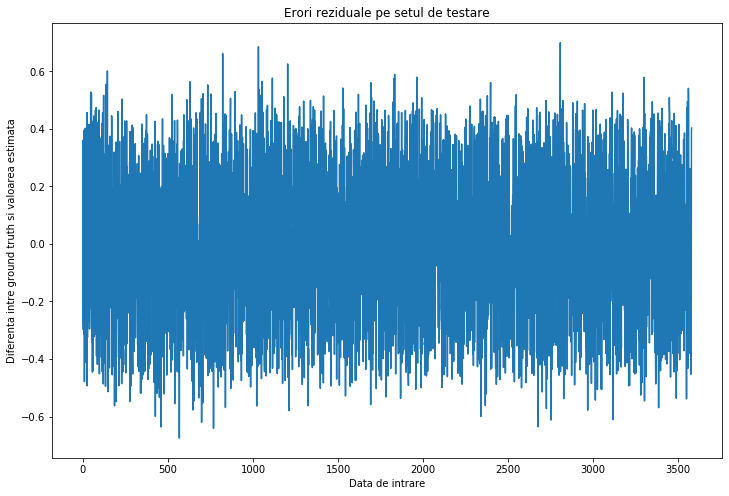

In [46]:
# reprezentarea diferentei intre ground truth si estimare pe setul de testare
plt.figure(figsize=(12, 8))
plt.title('Erori reziduale pe setul de testare')
plt.plot(y_test - y_hat_test)
plt.xlabel('Data de intrare')
plt.ylabel('Diferenta intre ground truth si valoarea estimata')